# setup and imports

In [1]:
import fnmatch
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *
from VIGOR_Figure5_Functions import compute_intercept
from VIGOR_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [2]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    histologyroot="/home/david/Desktop/HISTOLOGY"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/ALLDATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to histology is: %s"%histologyroot)
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(histologyroot+"/*"))} rats in the histology folder')
print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')


Path to histology is: /home/david/Desktop/HISTOLOGY
Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 13 rats in the histology folder
Found 34 rats in the data folder


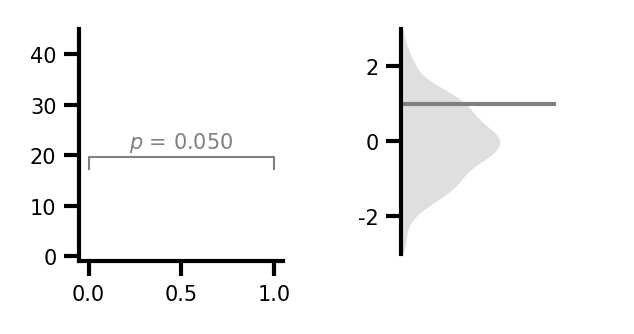

In [3]:

def plot_shuffling(shuffles=np.random.randn(1000), observed=1, ylim=[-3, 3], xlim=[0, .5], ylabel=' ', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    # half violin
    violin_parts = ax.violinplot(shuffles, positions=[0], showextrema=False, widths=0.5)
    for pc in violin_parts['bodies']:

        pc.set_facecolor('gray')
        pc.set_edgecolor('gray')
        pc.set_alpha(0.25)
        pc.set_linewidth(0)

    # observed
    ax.axhline(observed, 0, .75, color='gray')

    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.set_xlim(xlim)
    ax.set_xticks([])
    ax.spines['bottom'].set_visible(False)
    space_axes(ax, x_ratio_left=.0)



fig, axs = plt.subplots(1, 2, figsize=(2, 1))

axs[0].set_ylim(-1, 45)
barplot_annotate_brackets(axs[0], 0, 1, 0.05, [0, 1, 0], [10, 15, 0], maxasterix=3)
plot_shuffling(shuffles=np.random.randn(1000), observed=1, ylim=[-3, 3], xlim=[0, .5], ylabel=' ', ax=axs[1])

In [4]:
rat_markers = {}
sequence = {}
XtrackRunToLeftBin, XtrackRunToRightBin = {}, {}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
            #    'RatF20': 'thcre', 'RatF21': 'thcre', 'RatF22': 'thcre',
            #    'RatM20': 'thcre', 'RatM21': 'thcre', 'RatM22': 'thcre',
               'RatF30': 'DLS', 'RatF31': 'DLS', 'RatF32': 'normal', 'RatF33': 'normal',
               'RatM30': 'DLS', 'RatM31': 'normal', 'RatM32': 'normal',
               'RatF40': 'DLS', 'RatF41': 'DMS', 'RatF42': 'normal',
               'RatM40': 'normal', 'RatM41': 'DLS', 'RatM42': 'DMS', 'RatM43': 'normal', 

                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'
               }

intact_map = plt.cm.get_cmap('hsv')
lesion_map = plt.cm.get_cmap('autumn')

# markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
# lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

markers = {'normal': 'o', 'DLS': 'X', 'DMS': 'x'}
lines = {'normal': '-', 'DLS': '-', 'DMS': '-'}
colormaps = {'normal': intact_map, 'DLS': lesion_map, 'DMS': lesion_map}
c = {'normal': 'silver', 'DLS': 'gold', 'DMS': 'gold'}

################################################
c = {'normal': 'silver', 'DLS': 'xkcd:kiwi green', 'DMS': 'xkcd:kiwi green'}


animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

lesioned = ['RatF30', 'RatF31', 'RatM30', 'RatF40', 'RatF41', 'RatM41', 'RatM42',
            'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52']

rat_example_intact = 'RatM00'
rat_example_lesion = 'RatF52'#'RatF50': # 'RatF52'
for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    # if fnmatch.fnmatch(animal, 'RatF*'):
    #     rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'o', lines[brainstatus[animal]]]
    # elif fnmatch.fnmatch(animal, 'RatM*'):
    #     rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'o', lines[brainstatus[animal]]]
    # elif fnmatch.fnmatch(animal, 'Rat00*'):
    #     rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    # else:
    #     print("error, this is not a rat you got here")
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[c[brainstatus[animal]], 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[c[brainstatus[animal]], 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")


    if animal == rat_example_lesion: 
        rat_markers[animal][0] = 'xkcd:emerald'
        ##############################
        # rat_markers[animal][0] = 'orange'
        rat_markers[animal][1] = '^'

    if animal == rat_example_intact:
        rat_markers[animal][0] = 'dodgerblue'
        rat_markers[animal][1] = '^'

    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):
        pass
        # get the preprocessed data from the pickle file
        # biglesion = True if 'L' in session else False/
        
        # params[animal, session]     = get_from_pickle(root, animal, session, name="params.p")
        # sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)
        # XtrackRunToLeftBin[animal, session], XtrackRunToRightBin[animal, session] = get_from_pickle(root, animal, session, name="trackPos.p")
        # trackTimeToLeftBin[animal, session], trackTimeToRightBin[animal, session] = get_from_pickle(root, animal, session, name="trackTime.p")
        # instantSpeedLeftBin[animal, session],instantSpeedRightBin[animal, session]= get_from_pickle(root, animal, session, name="trackSpeed.p")      

effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, power = pickle.load(open('picklejar/effort_sensitivity_fit.p', 'rb'))

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF30
Loading data for RatF31
Loading data for RatF32
Loading data for RatF33
Loading data for RatM30
Loading data for RatM31
Loading data for RatM32
Loading data for RatF40
Loading data for RatF41
Loading data for RatF42
Loading data for RatM40
Loading data for RatM41
Loading data for RatM42
Loading data for RatM43
Loading data for RatF50
Loading data for RatF51
Loading data for RatF52
Loading data for RatM50
Loading data for RatM51
Loading data for RatM52
Loading data for RatM53
Loading data for RatM54


In [43]:
pickle.load(open('picklejar/effort_sensitivity_fit.p', 'rb'))[0]

{'RatF00': 8.750695934751331,
 'RatF01': 10.420143656811938,
 'RatF02': 13.512953315250323,
 'RatM00': 11.90239776690201,
 'RatM01': 9.551820812874873,
 'RatM02': 9.40261754548387,
 'RatF30': 15.453225062662277,
 'RatF31': 6.5721302484179445,
 'RatF32': 5.487428677823306,
 'RatF33': 6.410641442586926,
 'RatM30': 17.512289649924448,
 'RatM31': 15.74859297950476,
 'RatM32': 16.008467052246036,
 'RatF40': 22.11287370805851,
 'RatF41': 54.01500785620064,
 'RatF42': 5.5962190707351755,
 'RatM40': 9.323232052588871,
 'RatM41': 8.605001993981384,
 'RatM42': 15.443805453476834,
 'RatM43': 12.279061707076924,
 'RatF50': 21.790595601760828,
 'RatF51': 17.097240149020212,
 'RatF52': 24.919052135086705,
 'RatM50': 9.310575750655993,
 'RatM51': 27.06016271717598,
 'RatM52': 12.491748755035129,
 'RatM53': 28.336664802156065,
 'RatM54': 15.053000400146338}

In [5]:
def cohen_d(x,y):
    ''' function to compute Cohen's d for two samples x and y
    input: x and y are lists or arrays of numbers
    output: Cohen's d
    '''
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2

    if nx == ny:
        return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
    else:
        return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

x = [2,4,7,3,7,35,8,9]
y = [i*2 for i in x]

#correct only if nx=ny
print ("d if len(x) == len(y): " + str(cohen_d(x,y)))

#correct for more general case including nx !=ny
print ("d if len(x) != len(y): " + str(cohen_d([2,4,7,3,7,35,8,9, 10],y)))

d if len(x) == len(y): -0.5567679522645598
d if len(x) != len(y): -0.5720156046660209


In [6]:
import csv

def read_ROI_from_csv(file_path):
    ROI = []
    try:
        with open(file_path, mode='r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                if len(row) == 2:
                    try:
                        x = round(float(row[0]))
                        y = round(float(row[1]))
                        ROI.append((x, y))
                    except ValueError:
                        if row[0] == 'X' and row[1] == 'Y':
                            continue
                        else:
                            print(f"Skipping invalid row: {row}")
                else:
                    print(f"Skipping row with incorrect number of columns: {row}")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred while reading the file: {str(e)}")

    return np.array(ROI)

def compute_area(ROI):
    '''Compute the area of a polygonal ROI using the shoelace formula'''
    n = len(ROI)
    area = 0.0

    for i in range(n):
        x1, y1 = ROI[i]
        x2, y2 = ROI[(i + 1) % n]
        area += (x1 * y2 - x2 * y1)

    area = abs(area) / 2.0
    return area

def compute_centroid(ROI):
    '''Compute the centroid of a polygonal ROI using the shoelace formula'''
    n = len(ROI)
    if n == 0:
        return None

    sum_x = 0
    sum_y = 0
    signed_area = 0

    for i in range(n):
        x1, y1 = ROI[i]
        x2, y2 = ROI[(i + 1) % n]  # Wrap around for the last point

        cross_product = (x1 * y2 - x2 * y1)
        signed_area += cross_product
        sum_x += (x1 + x2) * cross_product
        sum_y += (y1 + y2) * cross_product

    signed_area /= 2.0
    centroid_x = sum_x / (6 * signed_area)
    centroid_y = sum_y / (6 * signed_area)

    return (centroid_x, centroid_y)

lesion_area = {animal: [] for animal in lesioned}
shifts = {animal: [] for animal in lesioned}
for animal in lesioned:
    print(animal)
    animalFolder = histologyroot + '/' + animal
    # slices = glob.glob(animalFolder + '/slice*.czi')

    slices = glob.glob(histologyroot + '/' + animal + '/slice*.csv')
    slices = [slice.split('_')[0] for slice in slices]
    slices = np.unique(slices)

    for slice in slices:
        print(slice)
        ROI_Left_Striatum = read_ROI_from_csv(slice + '_Left_Striatum.csv')
        ROI_Right_Striatum = read_ROI_from_csv(slice + '_Right_Striatum.csv')
        ROI_Left_Lesion = read_ROI_from_csv(slice + '_Left_Lesion.csv')
        ROI_Right_Lesion = read_ROI_from_csv(slice + '_Right_Lesion.csv')


        AREA_Left_Striatum = compute_area(ROI_Left_Striatum)
        AREA_Right_Striatum = compute_area(ROI_Right_Striatum)
        AREA_Left_Lesion = compute_area(ROI_Left_Lesion)
        AREA_Right_Lesion = compute_area(ROI_Right_Lesion)

        CENTROID_Left_Striatum, _ = compute_centroid(ROI_Left_Striatum)
        CENTROID_Right_Striatum, _ = compute_centroid(ROI_Right_Striatum)
        CENTROID_Left_Lesion, _ = compute_centroid(ROI_Left_Lesion)
        CENTROID_Right_Lesion, _ = compute_centroid(ROI_Right_Lesion)

        RATIO_Left = AREA_Left_Lesion / AREA_Left_Striatum
        RATIO_Right = AREA_Right_Lesion / AREA_Right_Striatum
        print(f"Left: {RATIO_Left:.2f}, Right: {RATIO_Right:.2f}")
        lesion_area[animal].extend((RATIO_Left, RATIO_Right))

        # mediolateralily
        XSHIFT_Left = CENTROID_Left_Lesion - CENTROID_Left_Striatum
        XSHIFT_Right = CENTROID_Right_Lesion - CENTROID_Right_Striatum
        print(f"Left: {-XSHIFT_Left:.2f}, Right: {XSHIFT_Right:.2f}")
        shifts[animal].extend((-XSHIFT_Left, XSHIFT_Right))

lesion_area = {animal: np.mean(lesion_area[animal]) for animal in lesioned}
lesion_pos = {animal: np.mean(shifts[animal]) for animal in lesioned}


# lesion_area = pickle.load(open('picklejar/lesion_size', 'rb'))
# # pickle.dump(lesion_area, open('picklejar/lesion_size', 'wb'))
# lesion_area

RatF30
/home/david/Desktop/HISTOLOGY/RatF30/slice3
Left: 0.19, Right: 0.07
Left: 463.27, Right: 338.50
/home/david/Desktop/HISTOLOGY/RatF30/slice5
Left: 0.11, Right: 0.07
Left: 205.42, Right: 175.84
/home/david/Desktop/HISTOLOGY/RatF30/slice8
Left: 0.41, Right: 0.35
Left: -215.05, Right: -93.73
RatF31
/home/david/Desktop/HISTOLOGY/RatF31/slice2
Left: 0.01, Right: 0.25
Left: 351.72, Right: 330.97
/home/david/Desktop/HISTOLOGY/RatF31/slice5
Left: 0.11, Right: 0.05
Left: 274.32, Right: 319.57
/home/david/Desktop/HISTOLOGY/RatF31/slice8
Left: 0.03, Right: 0.08
Left: 350.64, Right: 135.68
RatM30
/home/david/Desktop/HISTOLOGY/RatM30/slice2
Left: 0.13, Right: 0.38
Left: -243.32, Right: 184.30
/home/david/Desktop/HISTOLOGY/RatM30/slice5
Left: 0.16, Right: 0.02
Left: 48.28, Right: 36.23
/home/david/Desktop/HISTOLOGY/RatM30/slice9
Left: 0.30, Right: 0.24
Left: -55.50, Right: -186.58
RatF40
/home/david/Desktop/HISTOLOGY/RatF40/slice4
Left: 0.18, Right: 0.12
Left: -559.52, Right: -203.66
/home/dav

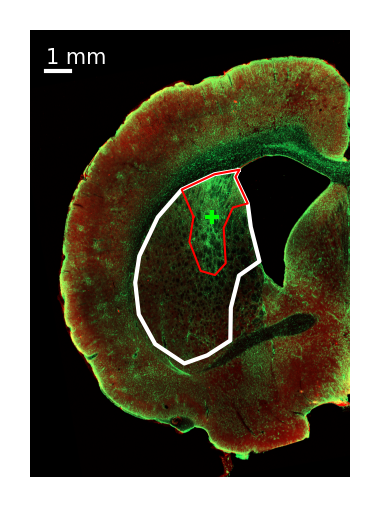

In [7]:
def Figure_6A(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(1, 1))

    if path is None:
        path = "/home/david/Desktop/HISTOLOGY/RatF52/prettyonetest.tif"

    img = plt.imread(path)
    ax.imshow(img)

    animalFolder = histologyroot + '/' + rat_example_lesion
    x = read_ROI_from_csv(animalFolder + '/prettyslice_Left_Striatum.csv')[:, 0]
    y = read_ROI_from_csv(animalFolder + '/prettyslice_Left_Striatum.csv')[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    ax.plot(x, y, 'w', lw=1)

    cx, cy = compute_centroid(read_ROI_from_csv(animalFolder + '/prettyslice_Left_Striatum.csv'))
    # ax.scatter(cx, cy, s=10, marker='+', zorder=10, c='w')


    x_lesion = read_ROI_from_csv(animalFolder + '/prettyslice_Left_Lesion.csv')[:, 0]
    y_lesion = read_ROI_from_csv(animalFolder + '/prettyslice_Left_Lesion.csv')[:, 1]
    x_lesion = np.append(x_lesion, x_lesion[0])
    y_lesion = np.append(y_lesion, y_lesion[0])
    ax.plot(x_lesion, y_lesion, 'r', lw=.5)

    cx, cy = compute_centroid(read_ROI_from_csv(animalFolder + '/prettyslice_Left_Lesion.csv'))
    ax.scatter(cx, cy, s=10, marker='+', zorder=10, c='lime')

    ax.set_xlim(250, 5250)
    ax.set_ylim(7000, 0)
    ax.axis("off")

    # annotate scale
    dpi = 300
    obj_zoom = 5
    inch = 2.54
    one_mm = 0.1 * inch * dpi * obj_zoom
    
    ax.plot([500, 500+one_mm], [650, 650], 'w', lw=1)
    ax.text(500, 600, '1 mm', color='w', ha='left', va='bottom', fontsize=5)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(16), cm2inch(4)))

Figure_6A(ax=ax)

In [8]:

def compute_median_contour(x, y, stat='Med.'):
    # eps, zmax, lenlim used in outlier detection. Here they are set so they don't exclude any outlier in the median computation. Outlying runs will be//are removed beforehand.
    eps = 0.001
    zmax = np.inf
    lenlim=(-np.inf, np.inf)
    data = list(zip(x, y))

    ss = SampleSet(data)
    # ss.getAvg(zmax, lenlim, eps, stat) # not supposed to do anything but has to be here to work ??????? Therefore, no touchy. 
    X, Y = ss.getAvg(zmax, lenlim, eps, stat)
    return X, Y

from scipy.interpolate import interp1d
def smooth_polygon(x, y, num_points=25):
    t = np.linspace(0, 1, len(x))
    t_new = np.linspace(0, 1, num_points)
    spline_x = interp1d(t, x, kind='cubic')
    spline_y = interp1d(t, y, kind='cubic')
    smoothed_x = spline_x(t_new)
    smoothed_y = spline_y(t_new)
    smoothed_x = np.append(smoothed_x, smoothed_x[0])
    smoothed_y = np.append(smoothed_y, smoothed_y[0])
    return smoothed_x, smoothed_y


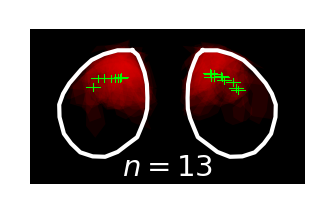

In [9]:
def Figure_6B(ax=None):
    # lesioned = [rat_example_lesion]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(1, 1))

    x_striatum_left, y_striatum_left = [], []
    x_lesion_left, y_lesion_left = [], []
    x_centroid_left, y_centroid_left = [], []
    x_centroid_right, y_centroid_right = [], []
    
    for animal in lesioned:
        animalFolder = histologyroot + '/' + animal
        slices = glob.glob(animalFolder + '/slice*.czi')

        for slice in slices:
            x = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x) + 1250
            offset_y = np.mean(y)
            x_striatum_left.append(x - offset_x)
            y_striatum_left.append(y - offset_y)

            # ax.plot(x - offset_x, y - offset_y, 'k', alpha=0.2, lw=.5)

            x_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, 
                              True, facecolor='r', alpha=.075)
            ax.add_patch(polygon)

            # ax.plot(x_lesion - offset_x, y_lesion - offset_y, 'r', alpha=0.2)
            x_lesion_left.append(x_lesion - offset_x)
            y_lesion_left.append(y_lesion - offset_y)


            cx, cy = compute_centroid(read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv'))
            cx -= offset_x
            cy = -cy - offset_y
            # ax.scatter(cx, cy, s=10, marker='+', zorder=10, c='g' if brainstatus[animal] == 'DMS' else 'c')
            x_centroid_left.append(cx)
            y_centroid_left.append(cy)

        _x, _y = (np.median(x_centroid_left), np.median(y_centroid_left))
        s = 150
        ax.plot([_x-s, _x+s], [_y, _y], 'lime', lw=.25)
        s=100
        ax.plot([_x, _x], [_y-s, _y+s], 'lime', lw=.25)

            

    x_striatum_right, y_striatum_right = [], []
    x_lesion_right, y_lesion_right = [], []
    x_centroid_right, y_centroid_right = [], []

    for animal in lesioned:
        animalFolder = histologyroot + '/' + animal
        slices = glob.glob(animalFolder + '/slice*.czi')

        for slice in slices:

            x = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x) - 1250
            offset_y = np.mean(y)
            # ax.plot(x - offset_x, y - offset_y, 'k', alpha=0.2, lw=.5)
            x_striatum_right.append(x - offset_x)
            y_striatum_right.append(y - offset_y)


            x_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, 
                              True, facecolor='r', alpha=.075)
            ax.add_patch(polygon)

            # axs[i, 1].plot(x_lesion - offset_x, y_lesion - offset_y, 'r', alpha=0.2)
            x_lesion_right.append(x_lesion - offset_x)
            y_lesion_right.append(y_lesion - offset_y)

            cx, cy = compute_centroid(read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv'))
            cx -= offset_x
            cy = -cy - offset_y
            # ax.scatter(cx, cy, s=10, marker='+', zorder=10, c='g' if brainstatus[animal] == 'DMS' else 'c')
            x_centroid_right.append(cx)
            y_centroid_right.append(cy)
        _x, _y = (np.median(x_centroid_right), np.median(y_centroid_right))
        s = 150
        ax.plot([_x-s, _x+s], [_y, _y], 'lime', lw=.25)
        s=100
        ax.plot([_x, _x], [_y-s, _y+s], 'lime', lw=.25)

        # ax.scatter(*average_centroid_right, s=0.5, marker='+', zorder=10, c='k')

    x_left = [ -769, -1090, -1394, -1655, -1886, -2141, -2278, -2363, -2356, -2260, -2103, -1903, 
        -1633, -1361, -1088 ,  -889, -662,  -580,  -492,  -444 , -438,  -450,  -500 ,  -580, -650,  -769]
    y_left = [ 1300,  1300,  1200,   1050, 800,   449,   180,  -102, -423,  -852, -1105, -1333,
        -1437, -1448, -1322, -1142, -942,  -711,  -451,  -213, 73,   428,   728,   986, 1177,  1300]
    ax.plot(x_left, y_left, 'w', lw=1)

    x_right = [ 769, 1090, 1394, 1655, 1886, 2141, 2278, 2363, 2356, 2260, 2103, 1903, 
        1633, 1361, 1088 , 889, 662, 580, 492, 444 , 438, 450, 500 , 580, 650, 769]
    y_right = [ 1300,  1300,  1200,   1050, 800,   449,   180,  -102, -423,  -852, -1105, -1333,
        -1437, -1448, -1322, -1142, -942,  -711,  -451,  -213, 73,   428,   728,   986, 1177,  1300]
    ax.plot(x_right, y_right, 'w', lw=1)


    
    ax.set_xlim(-3000, 3000)  # 6000
    ax.set_ylim(-2150, 1850)  # 4000
    # ratio x/y is 1.5
    # ax.axis('off')
    ax.set_facecolor('k')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.annotate(r'$n=$'+str(len(lesioned)), xy=(.50, .2), 
                xycoords='axes fraction', fontsize=7, ha='center', va='top', color='w')


fig, ax = plt.subplots(1, 1, figsize=(1, .6))
Figure_6B(ax)


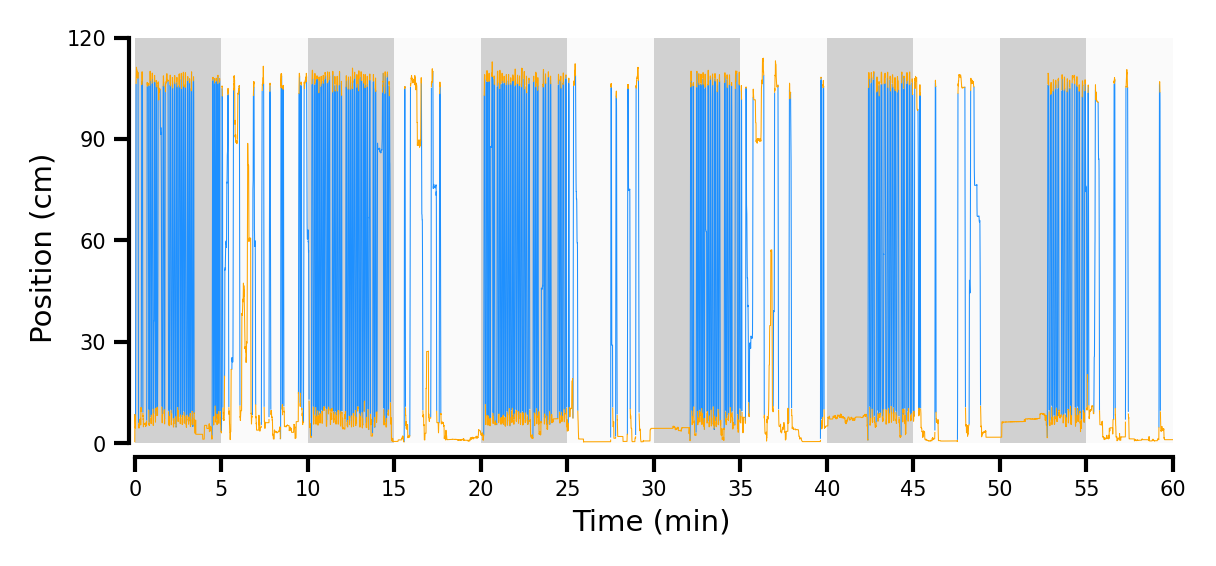

In [10]:
# plot session track without analysis files, session 120cm
def Figure1B(root="/home/david/Desktop/ALLDATA", 
            animal='RatF52', session='RatF52_2023_08_02_16_55_51', 
            ax=None):
    '''
    read position file and plot animal trajectory
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize = (cm2inch(10), cm2inch(4.5)))

    params = get_from_pickle(root, animal, session, name="params.p")
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    pos  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    mask = stitch([get_from_pickle(root, animal, session, name="mask.p")])[0]   
    pos = smooth(pos.astype('float32'), 2)

    running_Xs = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(pos, mask)]]
    idle_Xs = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(pos, mask)]]

    for i in range(0, len(params['blocks'])):
        ax.axvspan(params['blocks'][i][0], params['blocks'][i][1], ymin=1/30, ymax=1,
                    color='grey', alpha=params['rewardProbaBlock'][i]/250, linewidth=0)

    ax.plot(time, running_Xs, color="dodgerblue", lw=.25)
    ax.plot(time, idle_Xs, color="orange", lw=.25)

    ax.set_xlim(0, 3600)
    ax.set_ylim(0, 120)
    ax.set_xticks(np.arange(0, 3601, 300))
    ax.set_xticklabels(np.arange(0, 61, 5))
    ax.set_yticks(np.arange(0, 121, 30))
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Position (cm)")
    space_axes(ax, x_ratio_right=0, x_ratio_left=1/180)

rat_example_lesion = 'RatF52'
session_example_lesion = 'RatF52_2023_08_02_16_55_51' # 2nd afternoon at 120, as in Figure 1B

fig, ax = plt.subplots(1, 1, figsize = (cm2inch(10), cm2inch(4.5)))
Figure1B(ax=ax, animal=rat_example_lesion, session=session_example_lesion)

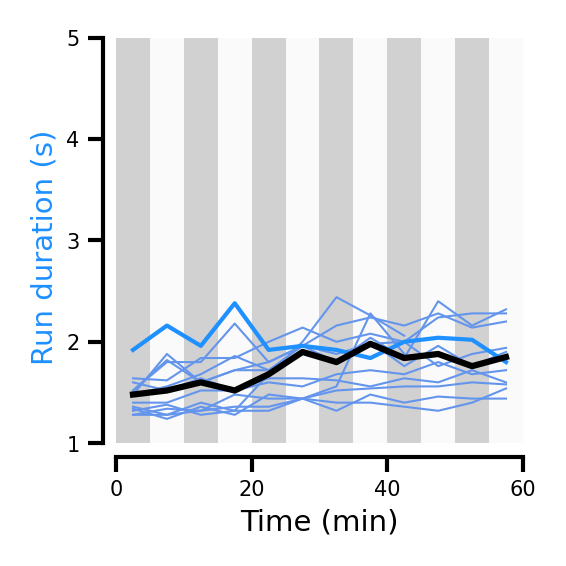

In [11]:
def Figure1F(root="/home/david/Desktop/ALLDATA", 
             sessionindex=-3, 
             ax=None):
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()

    median_all_animals = np.empty([len(lesioned), 12])
    for idx, animal in enumerate(lesioned):

        session = matchsession(animal, dist120)[sessionindex]
        params = get_from_pickle(root, animal, session, name="params.p")
        blocks = params['blocks']
        rewardProbaBlock = params['rewardProbaBlock']
        example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
        data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]
        if animal == 'RatF52':
            ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.nanmedian(data[i]) for i in range(0, len(blocks))],  # or use median
                # marker='o', ms=3, markeredgecolor='k', markeredgewidth=0.5, 
                color='dodgerblue', 
                zorder=4, label=f'Example lesion rat')
        else:
            ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                # [np.nanmedian(data[i]) for i in range(0, len(blocks))],
                [np.nanmedian(data[i]) if np.nanmedian(data[i]) < 10 else np.nan for i in range(0, len(blocks))],  # RatM52 session block 9 separation is bad because he did not go to the end of the track
                color='cornflowerblue', lw=.5,
                zorder=3, markeredgecolor='k', markeredgewidth=0.5, alpha=1,
                label=f'Individuals')
            
        median_all_animals[idx] = [np.median(data[i]) for i in range(0, len(blocks))]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            np.nanmedian(median_all_animals, axis=0),
            color='k', lw=1.5, zorder=5, markeredgecolor='k', markeredgewidth=0.25, 
            label=f'Median (n={len(lesioned)})')
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Run duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(1, 5)
    ax.set_yticks([1, 2, 3, 4, 5])

    # handles, labels = ax.get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure1F(ax=ax)


plt.savefig("/home/david/Desktop/code/svg/run.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

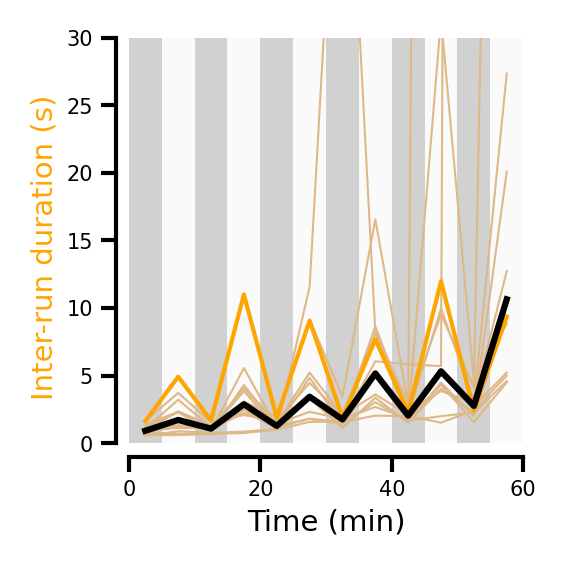

In [12]:
# plot idle time mean for each block
def Figure1G(root="/home/david/Desktop/ALLDATA", 
             sessionindex=-3, 
             ax=None):
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()
        
    median_all_animals = np.empty([len(lesioned), 12])
    for idx, animal in enumerate(lesioned):
        session = matchsession(animal, dist120)[sessionindex]
        params = get_from_pickle(root, animal, session, name="params.p")
        blocks = params['blocks']
        rewardProbaBlock = params['rewardProbaBlock']

        example_idleTimeInLeftBin, example_idleTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
        data = [example_idleTimeInLeftBin[i]+example_idleTimeInRightBin[i] for i in range(0, 12)]

        if animal == 'RatF52':
            ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.median(data[i]) for i in range(0, len(blocks))],  # or use median
                # marker='o', ms=3, markeredgecolor='k', markeredgewidth=0.5,
                color='orange', zorder=4, label=f'Example lesion rat')
            
        else:
            ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [np.median(data[i]) for i in range(0, len(blocks))],
                linewidth=.5, color='burlywood', 
                zorder=3, markeredgecolor='k', markeredgewidth=0.5, alpha=1, 
                label=f'Individuals')
    
        median_all_animals[idx] = [np.median(data[i]) for i in range(0, len(blocks))]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            np.nanmedian(median_all_animals, axis=0),
            color='k', lw=1.5, zorder=5, markeredgecolor='k', markeredgewidth=0.25,
            label=f'Median (n={len(lesioned)})')


    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
        
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Inter-run duration (s)", color='orange')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)

    # handles, labels = ax.get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize = (cm2inch(4.5), cm2inch(4.5)))
Figure1G(ax=ax)

plt.savefig("/home/david/Desktop/code/svg/irun.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

In [13]:
effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, power = pickle.load(open('picklejar/effort_sensitivity_fit.p', 'rb'))
alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
median_alpha_0 = {animal: np.median([alpha_0[animal][cond] for cond in conds]) for animal in animalList}
median_alpha_t = {animal: np.median([alpha_t[animal][cond] for cond in conds]) for animal in animalList}
median_alpha_u = {animal: np.median([alpha_u[animal][cond] for cond in conds]) for animal in animalList}
median_gamma_0 = {animal: np.median([gamma_0[animal][cond] for cond in conds]) for animal in animalList}
median_gamma_t = {animal: np.median([gamma_t[animal][cond] for cond in conds]) for animal in animalList}
median_gamma_u = {animal: np.median([gamma_u[animal][cond] for cond in conds]) for animal in animalList}
median_mu_0 = {animal: np.median([mu_0[animal][cond] for cond in conds]) for animal in animalList}
median_mu_t = {animal: np.median([mu_t[animal][cond] for cond in conds]) for animal in animalList}
median_mu_u = {animal: np.median([mu_u[animal][cond] for cond in conds]) for animal in animalList}
median_sigma_0 = {animal: np.median([sigma_0[animal][cond] for cond in conds]) for animal in animalList}
median_sigma_t = {animal: np.median([sigma_t[animal][cond] for cond in conds]) for animal in animalList}
median_sigma_u = {animal: np.median([sigma_u[animal][cond] for cond in conds]) for animal in animalList}

vars = [effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, median_alpha_0, median_alpha_t, median_alpha_u, median_gamma_0, median_gamma_t, median_gamma_u, median_mu_0, median_mu_t, median_mu_u, median_sigma_0, median_sigma_t, median_sigma_u]
names = ['effort_sensitivity_0', 'effort_sensitivity_t', 'effort_sensitivity_u', 'alpha_0', 'alpha_t', 'alpha_u', 'gamma_0', 'gamma_t', 'gamma_u', 'mu_0', 'mu_t', 'mu_u', 'sigma_0', 'sigma_t', 'sigma_u']


Text(0, 0.5, '$\\gamma_u$')

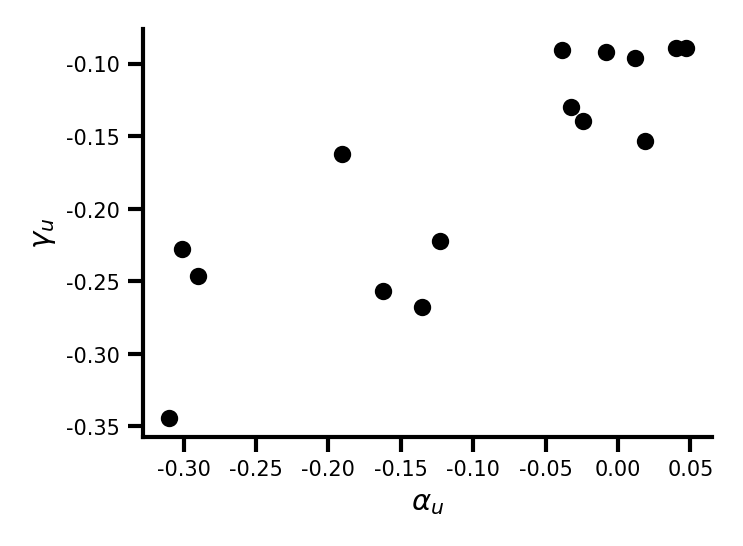

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(cm2inch(6), cm2inch(13)/3))

for animal in animalList:
    if brainstatus[animal] == 'normal':
        ax.scatter(median_alpha_u[animal], median_gamma_u[animal], s=10, c='k')

ax.set_xlabel(r'$\alpha_u$')
ax.set_ylabel(r'$\gamma_u$')


 corr: 0.16, p: 0.5635


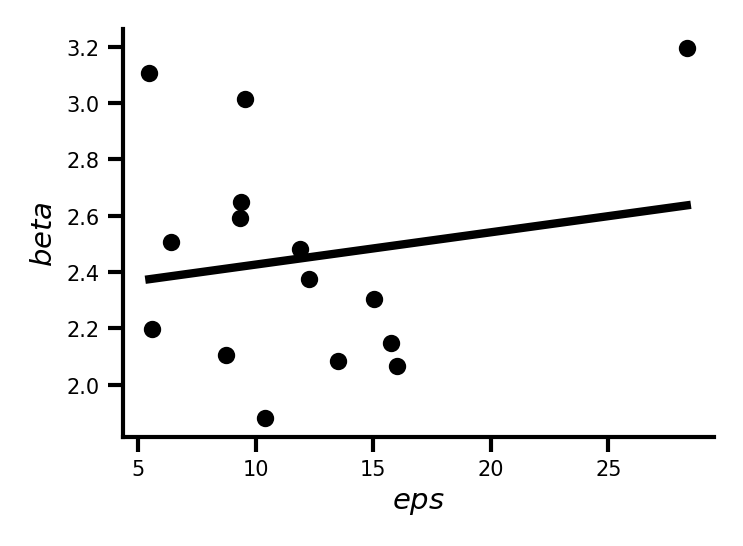

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(cm2inch(6), cm2inch(13)/3))
_x, _y = [], []
for animal in animalList:
    if brainstatus[animal] == 'normal':
        ax.scatter(effort_sensitivity_0[animal], power[animal], s=10, c='k')
        _x.append(effort_sensitivity_0[animal])
        _y.append(power[animal])
ax.set_xlabel(r'$eps$')
ax.set_ylabel(r'$beta$')


pearson = stats.pearsonr(_x, _y)
print(f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
ax.plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)

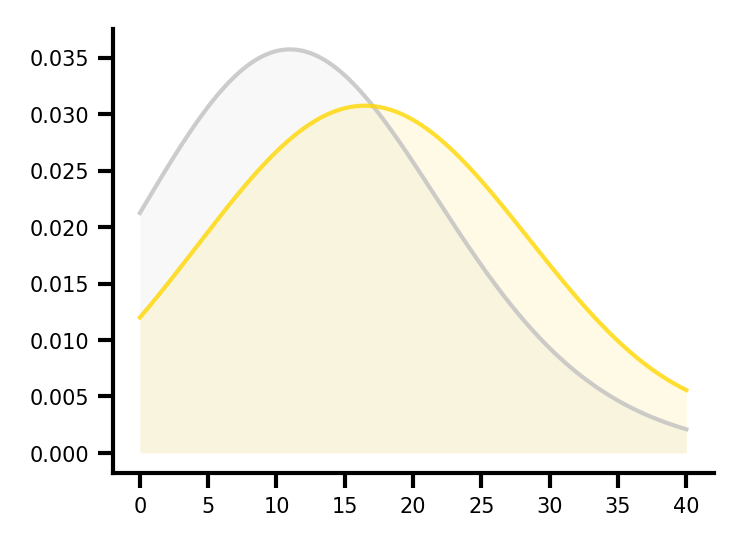

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(cm2inch(6), cm2inch(13)/3))

intact_effort_sensitivity_0 = {animal: effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] == 'normal'}
lesion_effort_sensitivity_0 = {animal: effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] != 'normal'}

# ax.hist(intact_effort_sensitivity_0.values(),color='silver',label='Intact', weights=np.ones(len(intact_effort_sensitivity_0.values())) / len(intact_effort_sensitivity_0.values()))
# ax.hist(lesion_effort_sensitivity_0.values(), color='gold', weights=np.ones(len(lesion_effort_sensitivity_0.values())) / len(lesion_effort_sensitivity_0.values()))

def _plot_kde(data, bandwidth=10, ax=None, color='k', xx=[-4, 4]):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    data = np.array(data).reshape(-1, 1)
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(data)

    # Compute log density scores
    xx = np.linspace(xx[0], xx[1], 1000).reshape(-1, 1)
    log_densities = kde.score_samples(xx)
    densities = np.exp(log_densities)
    
    ax.plot(xx, densities, color=color, lw=1, alpha=0.8)
    ax.fill_between(xx.flatten(), densities, color=color, alpha=0.1, lw=0)

_plot_kde(list(intact_effort_sensitivity_0.values()), ax=ax, color='silver', xx=[0, 40])
_plot_kde(list(lesion_effort_sensitivity_0.values()),  ax=ax, color='gold', xx=[0, 40])

Intact: 10.420143656811938 IQR: 5.246012864028229
Lesion: 17.097240149020212 IQR: 9.62112495302338
Intact: 2.375843241433299 IQR: 0.4936492708426461
Lesion: 2.9205782944291547 IQR: 0.2496857368054366


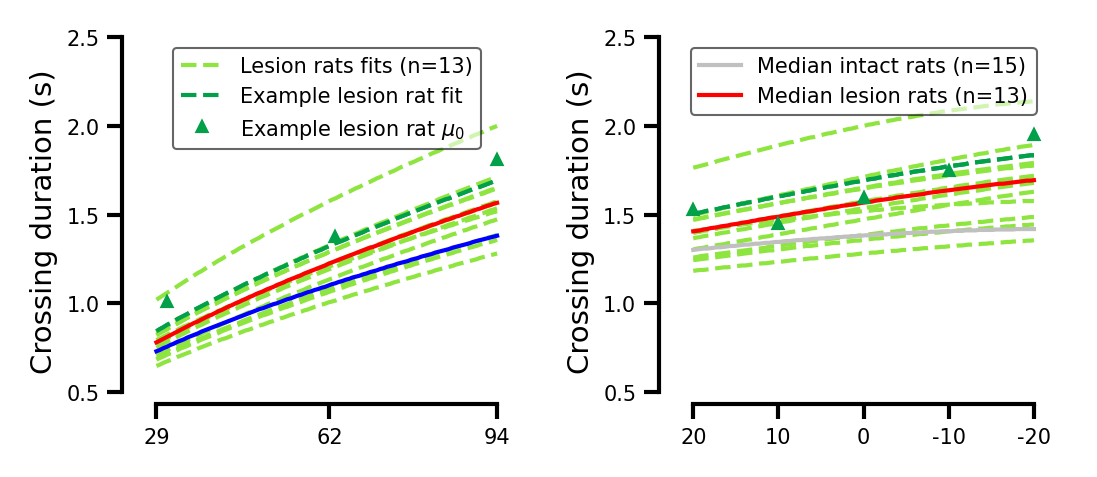

In [17]:
def T_opt_n(D, vbelt, effort_sensitivity, power_effort, power_time):
    '''Dirty Compute the optimal time to cross a distance D with a belt speed vbelt and an effort sensitivity'''
    T = np.linspace(0.0, 2.5, 1000)
    vmax = (D - vbelt * T) / (T)
    cost = effort_sensitivity * T * vmax ** power_effort + T**power_time
    Topt = T[np.nanargmin(cost)]
    return Topt


median_effort_sensitivity_intact_rat = np.median([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] == 'normal'])
median_effort_sensitivity_lesion_rat = np.median([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] != 'normal'])

median_power_intact_rat = np.median([power[animal] for animal in animalList if brainstatus[animal] == 'normal'])
median_power_lesion_rat = np.median([power[animal] for animal in animalList if brainstatus[animal] != 'normal'])

interquartile_effort_sensitivity_intact_rat = np.percentile([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] == 'normal'], 75) - np.percentile([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] == 'normal'], 25)
interquartile_effort_sensitivity_lesion_rat = np.percentile([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] != 'normal'], 75) - np.percentile([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] != 'normal'], 25)

interquartile_power_intact_rat = np.percentile([power[animal] for animal in animalList if brainstatus[animal] == 'normal'], 75) - np.percentile([power[animal] for animal in animalList if brainstatus[animal] == 'normal'], 25)
interquartile_power_lesion_rat = np.percentile([power[animal] for animal in animalList if brainstatus[animal] != 'normal'], 75) - np.percentile([power[animal] for animal in animalList if brainstatus[animal] != 'normal'], 25)


print(f'Intact: {median_effort_sensitivity_intact_rat} IQR: {interquartile_effort_sensitivity_intact_rat}')
print(f'Lesion: {median_effort_sensitivity_lesion_rat} IQR: {interquartile_effort_sensitivity_lesion_rat}')

print(f'Intact: {median_power_intact_rat} IQR: {interquartile_power_intact_rat}')
print(f'Lesion: {median_power_lesion_rat} IQR: {interquartile_power_lesion_rat}')


# Topt as a function of D
def Figure3F(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(.29, .94, 100)

    for animal in lesioned:
        if animal == rat_example_lesion:
            _rmu = r'$\mu_0$'
            ax.plot(D, [T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D], 
                    c=rat_markers[animal][0], ls='--', label=f'Example lesion rat fit', zorder=10)
            ax.plot([.31, .63, .94], [mu_0[animal]['60'], mu_0[animal]['90'], mu_0[animal]['120']], 
                color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                markersize=2, ls='--', lw=0, zorder=10, label=f'Example lesion rat {_rmu}')
            
        ax.plot(D, [T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D], 
                c=rat_markers[animal][0], ls='--', label=f'Lesion rats fits (n={len(lesioned)})')

    # plot median intact rat
    ax.plot(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for d in D], 
                    # label=f'Median intact rats (n={len(animalList) - len(lesioned)})', 
                    c='b', lw=1, alpha=1, zorder=10)
    # ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat - interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat - interquartile_power_intact_rat/2, power_time=3) for d in D],
    #                     [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat + interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat + interquartile_power_intact_rat/2, power_time=3) for d in D],
    #                     color='c', alpha=.1, lw=0, zorder=10)

    # # plot median lesion rat
    ax.plot(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for d in D],
                    # label=f'Median lesion rats (n={len(lesioned)})',
                    c='r')
    # ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat - interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat - interquartile_power_lesion_rat/2, power_time=3) for d in D],
    #                     [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat + interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat + interquartile_power_lesion_rat/2, power_time=3) for d in D],
    #                     label=f'Example animal', color='r', alpha=.1)
    
    _ = r'$d$'
    # ax.set_xlabel(f'{_} (cm)')
    ax.set_ylabel('Crossing duration (s)')
    ax.set_xlim(0.29, .94)
    ax.set_ylim(0.5, 2.5)
    ax.set_xticks([.29, .62, .94])
    ax.set_yticks([.5, 1, 1.5, 2, 2.5])
    ax.set_xticklabels([29, 62, 94])
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper center', bbox_to_anchor=(0.5, 1), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)



# Topt as a function of Vbelt
def Figure3G(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(.2, -.2, 100)

    for animal in lesioned:
        if animal == rat_example_lesion:
            ax.plot(VBELT, [T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT], 
                c=rat_markers[animal][0], zorder=10, ls='--')
            ax.plot([.2, .1, 0, -.1, -.2], [mu_0[animal]['20'], mu_0[animal]['10'], mu_0[animal]['2'], mu_0[animal]['rev10'], mu_0[animal]['rev20']], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=2, lw=0, zorder=10)
        ax.plot(VBELT, [T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT], 
                c=rat_markers[animal][0], ls='--')
    

    # plot median intact rat
    ax.plot(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for vbelt in VBELT], 
                    label=f'Median intact rats (n={len(animalList) - len(lesioned)})', c='silver', lw=1, alpha=1, zorder=10)
    # ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat - interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat - interquartile_power_intact_rat/2, power_time=3) for vbelt in VBELT],
    #                     [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat + interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat + interquartile_power_intact_rat/2, power_time=3) for vbelt in VBELT],
    #                     label=f'Example animal', color='c', alpha=.1, lw=0, zorder=10)

    # # plot median lesion rat
    ax.plot(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for vbelt in VBELT],
                    label=f'Median lesion rats (n={len(lesioned)})', c='r')
    # ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat - interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat - interquartile_power_lesion_rat/2, power_time=3) for vbelt in VBELT],
    #                     [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat + interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat + interquartile_power_lesion_rat/2, power_time=3) for vbelt in VBELT],
    #                     label=f'Example animal', color='r', alpha=.1)
    
    _ = r'$d$'
    _ = r'$v_{\mathrm{belt}}$'
    # ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel('Crossing duration (s)')
    ax.set_xlim(.2, -.2)
    ax.set_ylim(0.5, 2.5)
    ax.set_xticks([.2, .1, 0, -.1, -.2])
    ax.set_yticks([.5, 1, 1.5, 2, 2.5])
    ax.set_xticklabels([20, 10, 0, -10, -20])
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper center', bbox_to_anchor=(0.5, 1), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

    
fig, axs = plt.subplots(1, 2, figsize=(cm2inch(9), cm2inch(15/4)))
Figure3F(ax=axs[0])
Figure3G(ax=axs[1])

Intact: 10.420143656811938 IQR: 5.246012864028229
Lesion: 17.097240149020212 IQR: 9.62112495302338
Intact: 2.375843241433299 IQR: 0.4936492708426461
Lesion: 2.9205782944291547 IQR: 0.2496857368054366


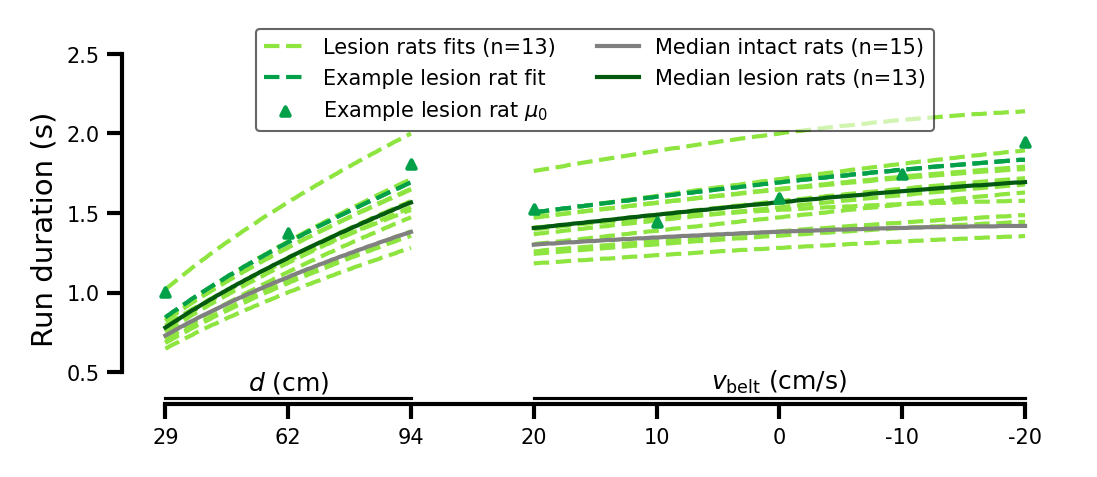

In [18]:
def T_opt_n(D, vbelt, effort_sensitivity, power_effort, power_time):
    '''Dirty Compute the optimal time to cross a distance D with a belt speed vbelt and an effort_sensitivity'''
    T = np.linspace(0.0, 2.5, 1000)
    vmax = (D - vbelt * T) / (T)
    cost = effort_sensitivity * T * vmax ** power_effort + T**power_time
    Topt = T[np.nanargmin(cost)]
    return Topt


median_effort_sensitivity_intact_rat = np.median([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] == 'normal'])
median_effort_sensitivity_lesion_rat = np.median([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] != 'normal'])

median_power_intact_rat = np.median([power[animal] for animal in animalList if brainstatus[animal] == 'normal'])
median_power_lesion_rat = np.median([power[animal] for animal in animalList if brainstatus[animal] != 'normal'])

interquartile_effort_sensitivity_intact_rat = np.percentile([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] == 'normal'], 75) - np.percentile([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] == 'normal'], 25)
interquartile_effort_sensitivity_lesion_rat = np.percentile([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] != 'normal'], 75) - np.percentile([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] != 'normal'], 25)

interquartile_power_intact_rat = np.percentile([power[animal] for animal in animalList if brainstatus[animal] == 'normal'], 75) - np.percentile([power[animal] for animal in animalList if brainstatus[animal] == 'normal'], 25)
interquartile_power_lesion_rat = np.percentile([power[animal] for animal in animalList if brainstatus[animal] != 'normal'], 75) - np.percentile([power[animal] for animal in animalList if brainstatus[animal] != 'normal'], 25)


print(f'Intact: {median_effort_sensitivity_intact_rat} IQR: {interquartile_effort_sensitivity_intact_rat}')
print(f'Lesion: {median_effort_sensitivity_lesion_rat} IQR: {interquartile_effort_sensitivity_lesion_rat}')

print(f'Intact: {median_power_intact_rat} IQR: {interquartile_power_intact_rat}')
print(f'Lesion: {median_power_lesion_rat} IQR: {interquartile_power_lesion_rat}')


# Topt as a function of D
def Figure3FF(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(.29, .94, 100)
    xx = np.linspace(0, 2, 100)

    for animal in lesioned:
        if animal == rat_example_lesion:
            rmu_0 = r'$\mu_0$'
            ax.plot(xx, [T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D], 
                    c=rat_markers[animal][0], ls='--', label=f'Example lesion rat fit', zorder=10)
            ax.scatter([0, 1, 2], [mu_0[animal]['60'], mu_0[animal]['90'], mu_0[animal]['120']], 
                color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                s=4, zorder=10, label=f'Example lesion rat {rmu_0}')
            
        ax.plot(xx, [T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D], 
                c=rat_markers[animal][0], ls='--', label=f'Lesion rats fits (n={len(lesioned)})')

    # plot median intact rat
    ax.plot(xx, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for d in D], 
                    # label=f'Median intact rats (n={len(animalList) - len(lesioned)})', 
                    c='gray', lw=1, alpha=1, zorder=10)
    # ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat - interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat - interquartile_power_intact_rat/2, power_time=3) for d in D],
    #                     [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat + interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat + interquartile_power_intact_rat/2, power_time=3) for d in D],
    #                     color='c', alpha=.1, lw=0, zorder=10)

    # # plot median lesion rat
    ax.plot(xx, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for d in D],
                    # label=f'Median lesion rats (n={len(lesioned)})',
                    c='xkcd:deep green')
    # ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat - interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat - interquartile_power_lesion_rat/2, power_time=3) for d in D],
    #                     [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat + interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat + interquartile_power_lesion_rat/2, power_time=3) for d in D],
    #                     label=f'Example animal', color='r', alpha=.1)
    
    ##########################################################



    VBELT = np.linspace(.2, -.2, 100)
    xxx = np.linspace(3, 7, 100)
    for animal in lesioned:
        if animal == rat_example_lesion:
            ax.plot(xxx, [T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT], 
                c=rat_markers[animal][0], zorder=10, ls='--')
            ax.scatter([3, 4, 5, 6, 7], [mu_0[animal]['20'], mu_0[animal]['10'], mu_0[animal]['2'], mu_0[animal]['rev10'], mu_0[animal]['rev20']], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10)
        ax.plot(xxx, [T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT], 
                c=rat_markers[animal][0], ls='--')
    

    # plot median intact rat
    ax.plot(xxx, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for vbelt in VBELT], 
                    label=f'Median intact rats (n={len(animalList) - len(lesioned)})', c='gray', lw=1, alpha=1, zorder=10)
    # ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat - interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat - interquartile_power_intact_rat/2, power_time=3) for vbelt in VBELT],
    #                     [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat + interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat + interquartile_power_intact_rat/2, power_time=3) for vbelt in VBELT],
    #                     label=f'Example animal', color='c', alpha=.1, lw=0, zorder=10)

    # # plot median lesion rat
    ax.plot(xxx, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for vbelt in VBELT],
                    label=f'Median lesion rats (n={len(lesioned)})', c='xkcd:deep green')
    # ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat - interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat - interquartile_power_lesion_rat/2, power_time=3) for vbelt in VBELT],
    #                     [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat + interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat + interquartile_power_lesion_rat/2, power_time=3) for vbelt in VBELT],
    #                     label=f'Example animal', color='r', alpha=.1)
    
    _ = r'$d$'
    _ = r'$v_{\mathrm{belt}}$'
    # ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel('Run duration (s)')
    ax.set_xlim(0, 7)
    ax.set_ylim(0.5, 2.5)
    ax.set_yticks([.5, 1, 1.5, 2, 2.5])
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(["29", "62", "94", "20", "10", "0", "-10", "-20"]) #±2
    space_axes(ax, y_ratio=.1, x_ratio_left=.05, x_ratio_right=.05)
    annotation_d_vbelt(ax=ax, miny=0.5)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    unique = [unique[0], unique[1], unique[4], unique[2], unique[3]]
    ax.legend(*zip(*unique), loc='upper center', bbox_to_anchor=(0.5, 1.1), 
                            frameon=True, fontsize=5, markerscale=1, ncol=2,
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

    
fig, axs = plt.subplots(1, 1, figsize=(cm2inch(9), cm2inch(15/4)))
Figure3FF(ax=axs)

In [19]:

# if os.path.exists('picklejar/fig6_permutation.p'):
#     observed_diff, permuted_diffs, p_values = pickle.load(open('picklejar/fig6_permutation.p', 'rb'))
# else:
D = [.31, .63, .96]
VBELT = [.2, .1, 0, -.1, -.2]
Vbelt_cst = 0
D_cst = .94
group1_data = []
group2_data = []
for animal in animalList:
    if brainstatus[animal] == 'normal':
        # group1_data.append([mu_0[animal][cond] for cond in ['60', '90', '120', 'rev20', 'rev10', '2', '10', '20']])
        group1_data.append([T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D]+[T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT])
    else:
        # group2_data.append([mu_0[animal][cond] for cond in ['60', '90', '120', 'rev20', 'rev10', '2', '10', '20']])
        group2_data.append([T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D]+[T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT])

ngroup1 = len(group1_data)
num_permutations = 10000

observed_diff = np.median(group1_data, axis=0) - np.median(group2_data, axis=0)
permuted_diffs = np.zeros((num_permutations, 8))

for i in range(num_permutations):
    combined_data = np.concatenate([group1_data, group2_data], axis=0)
    np.random.shuffle(combined_data)

    permuted_diff = np.median(combined_data[:ngroup1], axis=0) - np.median(combined_data[ngroup1:], axis=0)
    permuted_diffs[i] = permuted_diff

p_values = np.mean(permuted_diffs <= observed_diff, axis=0)
    # pickle.dump([observed_diff, permuted_diffs, p_values], open('picklejar/fig6_permutation.p', 'wb'))
    
print(p_values)

[0.17   0.0064 0.0067 0.0724 0.0064 0.0064 0.0031 0.0031]


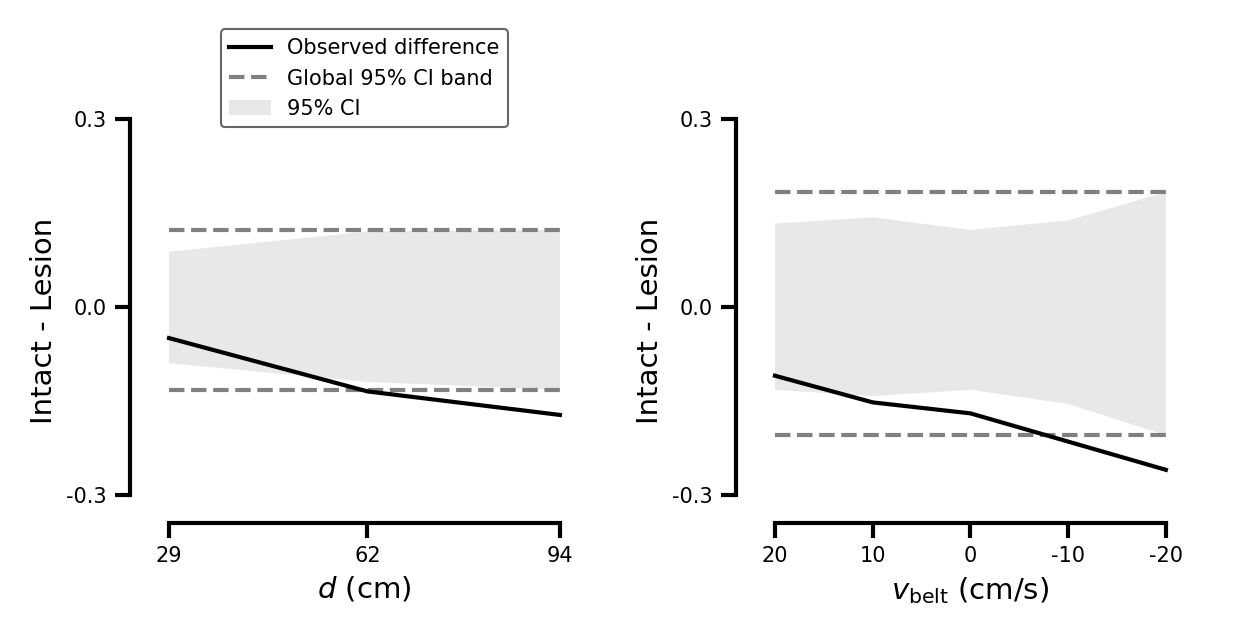

In [20]:
def plot_permutationDist(permuted_diffs, observed_diff, p_values, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    CI = np.percentile(permuted_diffs[:, 0:3], [2.5, 97.5], axis=0)
    y = np.concatenate([CI[0], CI[1][::-1]])
    x = np.concatenate([[.29, .62, .94], [.94, .62, .29]])
    ax.fill(x, y, alpha=.5, color='lightgray', label='95% CI', zorder=0, lw=0)
    ax.plot([.29, .62, .94], observed_diff[0:3], color='k', label='Observed difference', zorder=10)

    global_band_bot = [min(np.percentile(permuted_diffs, 2.5, axis=0)[0:3]) for _ in range(3)]
    global_band_top = [max(np.percentile(permuted_diffs, 97.5, axis=0)[0:3]) for _ in range(3)]
    ax.plot([.29, .62, .94], global_band_bot, color='gray', ls='--', label='Global 95% CI band')
    ax.plot([.29, .62, .94], global_band_top, color='gray', ls='--', label='Global 95% CI band')

    # for i, (pos, p) in enumerate(zip([.29, .62, .94], p_values[0:3])):
    #     if observed_diff[i] < global_band_bot[i] or observed_diff[i] > global_band_top[i]:
    #         ax.annotate(stars(p) if p < 0.05 else '', 
    #                     xy=(pos, observed_diff[i]), xytext=(pos, observed_diff[i]), 
    #                     fontsize=5, ha='right', va='top', rotation=45)

    ax.set_ylim(-0.3, 0.3)
    _ = r'$d$'
    ax.set_xlabel(f'{_} (cm)')
    ax.set_ylabel('Intact - Lesion')
    ax.set_yticks([-.3, 0, .3])
    ax.set_xlim(.29, .94)
    ax.set_xticks([.29, .62, .94])
    ax.set_xticklabels([29, 62, 94])
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1, y_ratio=.075)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.5, 1.1), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


def plot_permutationVbelt(permuted_diffs, observed_diff, p_values, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    CI = np.percentile(permuted_diffs[:, 3:8], [2.5, 97.5], axis=0)
    y = np.concatenate([CI[0], CI[1][::-1]])
    x = np.concatenate([[.2, .1, 0, -.1, -.2], [-.2, -.1, 0, .1, .2]])
    ax.fill(x, y, alpha=.5, color='lightgray', label='95% CI', zorder=0, lw=0)
    ax.plot([.2, .1, 0, -.1, -.2], observed_diff[3:8], color='k', label='Observed difference', zorder=10)

    global_band_bot = [min(np.percentile(permuted_diffs, 2.5, axis=0)[3:8]) for _ in range(5)]
    global_band_top = [max(np.percentile(permuted_diffs, 97.5, axis=0)[3:8]) for _ in range(5)]
    ax.plot([.2, .1, 0, -.1, -.2], global_band_bot, color='gray', ls='--', label='Global band')
    ax.plot([.2, .1, 0, -.1, -.2], global_band_top, color='gray', ls='--', label='Global band')

    # for i, (pos, p) in enumerate(zip([.2, .1, 0, -.1, -.2], p_values[3:8])):
    #     if observed_diff[i+3] < global_band_bot[i] or observed_diff[i+3] > global_band_top[i]:
    #         ax.annotate(stars(p) if p < 0.05 else '', 
    #                     xy=(pos, observed_diff[i+3]), xytext=(pos, observed_diff[i+3]), 
    #                     fontsize=5, ha='right', va='top', rotation=45)
    
    ax.set_ylim(-0.3, 0.3)
    _ = r'$d$'
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel('Intact - Lesion')
    ax.set_yticks([-.3, 0, .3])
    ax.set_xlim(.2, -.2)
    ax.set_xticks([.2, .1, 0, -.1, -.2])
    ax.set_xticklabels([20, 10, 0, -10, -20])
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1, y_ratio=.075)
    
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
plot_permutationDist(permuted_diffs, observed_diff, p_values, ax=axs[0])
plot_permutationVbelt(permuted_diffs, observed_diff, p_values, ax=axs[1])

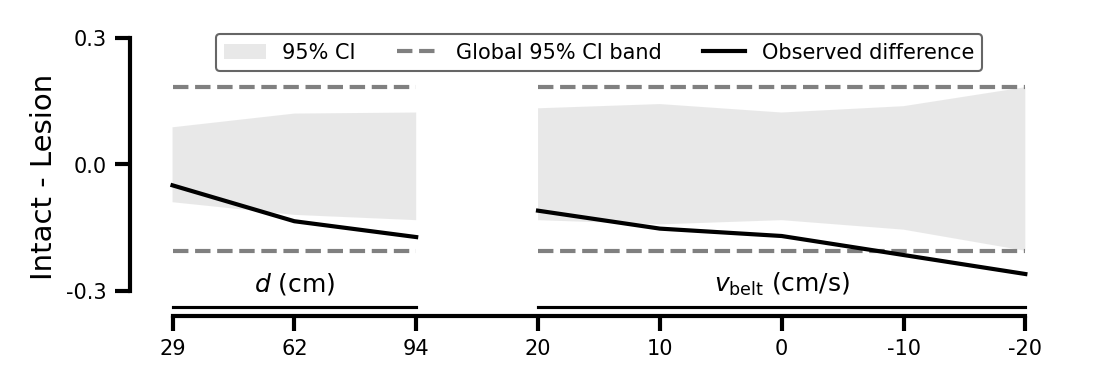

In [21]:
def plot_permutation(permuted_diffs, observed_diff, p_values, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    CI = np.percentile(permuted_diffs[:, 0:3], [2.5, 97.5], axis=0)
    y = np.concatenate([CI[0], CI[1][::-1]])
    x = np.concatenate([[0, 1, 2], [2, 1, 0]])
    ax.fill(x, y, alpha=.5, color='lightgray', label='95% CI', zorder=0, lw=0)
    ax.plot([0, 1, 2], observed_diff[0:3], color='k', label='Observed difference', zorder=10)

    # global_band_bot = [min(np.percentile(permuted_diffs, 2.5, axis=0)[0:3]) for _ in range(3)]
    # global_band_top = [max(np.percentile(permuted_diffs, 97.5, axis=0)[0:3]) for _ in range(3)]
    global_band_bot = [min(np.percentile(permuted_diffs, 2.5, axis=0)) for _ in range(3)]
    global_band_top = [max(np.percentile(permuted_diffs, 97.5, axis=0)) for _ in range(3)]
    ax.plot([0, 1, 2], global_band_bot, color='gray', ls='--', label='Global 95% CI band')
    ax.plot([0, 1, 2], global_band_top, color='gray', ls='--', label='Global 95% CI band')



    ######################################""""

    CI = np.percentile(permuted_diffs[:, 3:8], [2.5, 97.5], axis=0)
    y = np.concatenate([CI[0], CI[1][::-1]])
    x = np.concatenate([[3, 4, 5, 6, 7], [7, 6, 5, 4, 3]])
    ax.fill(x, y, alpha=.5, color='lightgray', label='95% CI', zorder=0, lw=0)
    ax.plot([3, 4, 5, 6, 7], observed_diff[3:8], color='k', label='Observed difference', zorder=10)

    # global_band_bot = [min(np.percentile(permuted_diffs, 2.5, axis=0)[3:8]) for _ in range(5)]
    # global_band_top = [max(np.percentile(permuted_diffs, 97.5, axis=0)[3:8]) for _ in range(5)]
    global_band_bot = [min(np.percentile(permuted_diffs, 2.5, axis=0)) for _ in range(5)]
    global_band_top = [max(np.percentile(permuted_diffs, 97.5, axis=0)) for _ in range(5)]
    ax.plot([3, 4, 5, 6, 7], global_band_bot, color='gray', ls='--', label='Global 95% CI band')
    ax.plot([3, 4, 5, 6, 7], global_band_top, color='gray', ls='--', label='Global 95% CI band')

    ax.set_ylim(-0.3, 0.3)
    ax.set_ylabel('Intact - Lesion')
    ax.set_yticks([-.3, 0, .3])
    ax.set_xlim(0, 7)
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(["29", "62", "94", "20", "10", "0", "-10", "-20"])
    space_axes(ax, x_ratio_left=.05, x_ratio_right=.05, y_ratio=.1)
    annotation_d_vbelt(ax=ax, miny=-0.25)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]][::-1]
    ax.legend(*zip(*unique), loc='upper center', bbox_to_anchor=(0.5, 1.05), 
                            frameon=True, fontsize=5, markerscale=1, ncol=3,
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

fig, axs = plt.subplots(1, 1, figsize=(cm2inch(9), cm2inch(3)))
plot_permutation(permuted_diffs, observed_diff, p_values, ax=axs)

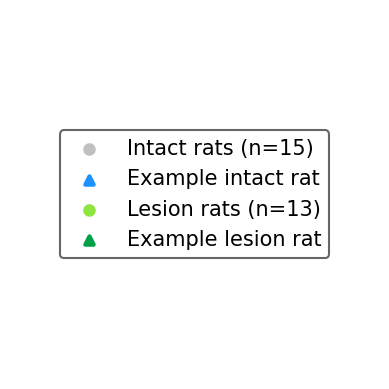

In [22]:
def dummy_legend(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    for animal in animalList:
        if animal ==rat_example_lesion:
            ax.scatter(0, 0, color=rat_markers[animal][0], marker=rat_markers[animal][1], label=f'Example lesion rat', s=4, zorder=10)
        elif animal == rat_example_intact:
            ax.scatter(0, 0, color=rat_markers[animal][0], marker=rat_markers[animal][1], label=f'Example intact rat', s=4, zorder=10)
        else:
            if brainstatus[animal] == 'normal':
                ax.scatter(0, 0, color=rat_markers[animal][0], marker=rat_markers[animal][1], label=f'Intact rats (n={len(animalList) - len(lesioned)})', s=4, zorder=5)
            else:
                ax.scatter(0, 0, color=rat_markers[animal][0], marker=rat_markers[animal][1], label=f'Lesion rats (n={len(lesioned)})', s=4, zorder=5)

    ax.axis('off')
    ax.set_xlim(10, 11)
    ax.set_ylim(10, 11)
    
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.5, 0.5), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

fig, axs = plt.subplots(1, 1, figsize=(cm2inch(3), cm2inch(3)))
dummy_legend(ax=axs)

effort_sensitivity_0 0.0087
effort_sensitivity_t 0.155
effort_sensitivity_u 0.8366
power 0.0067


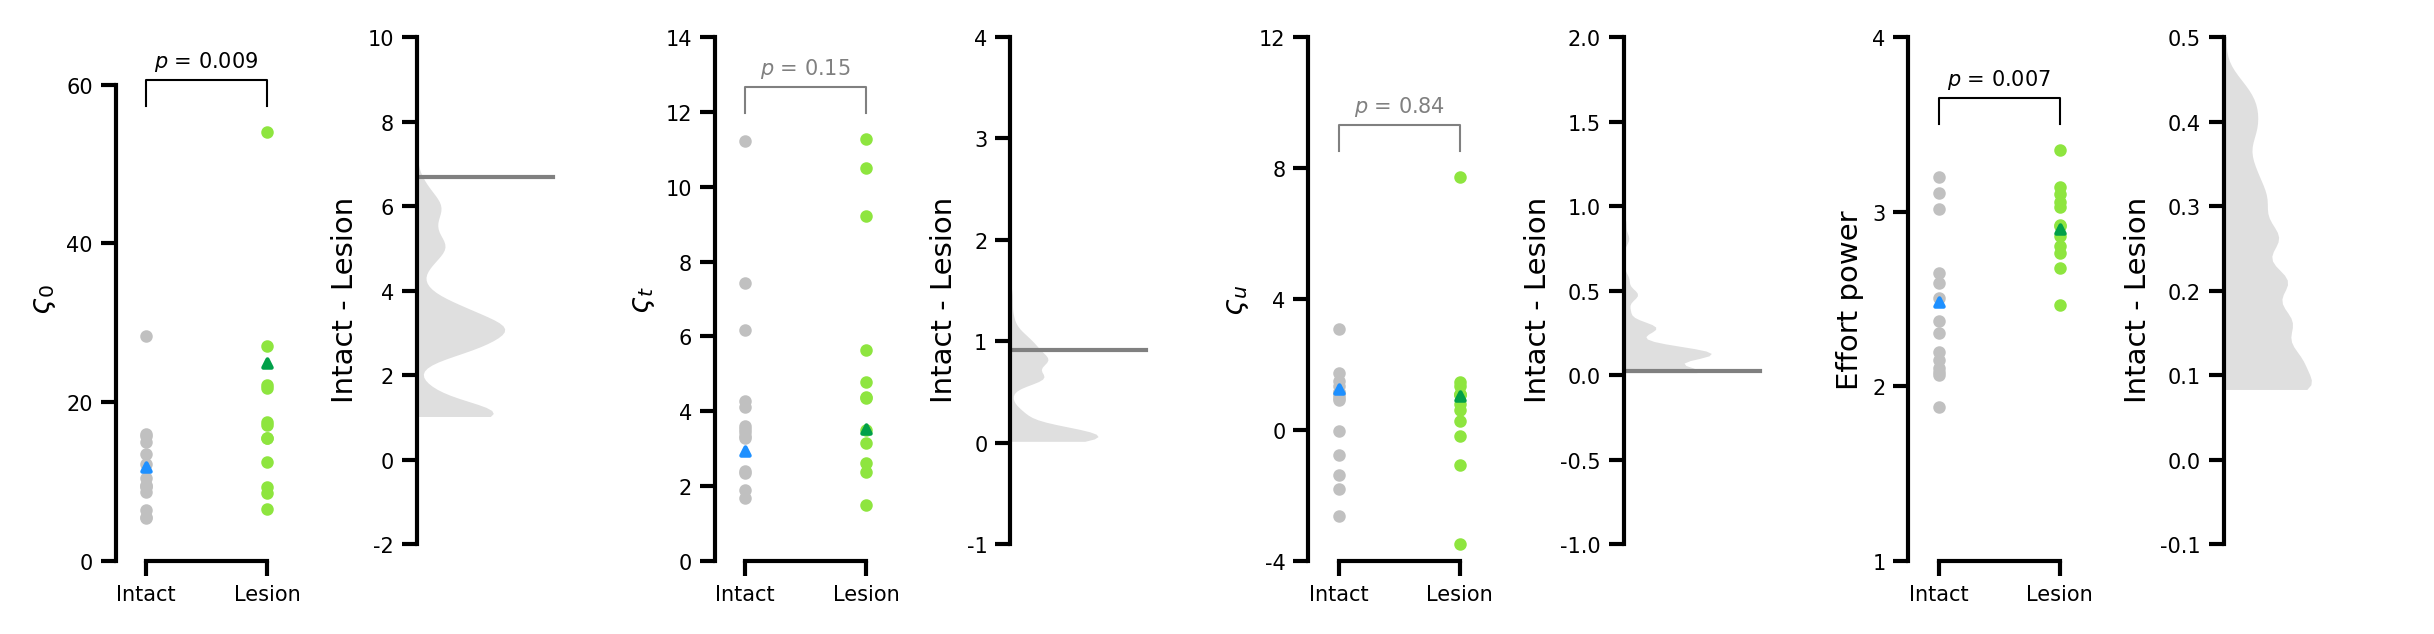

In [23]:
def Figure6_H1(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if animal ==rat_example_lesion:
            x = 1
            lesion.append(effort_sensitivity_0[animal])
            ax.scatter(x, effort_sensitivity_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], label=f'Example lesion rat', s=4, zorder=10)
        elif animal == rat_example_intact:
            x = 0
            intact.append(effort_sensitivity_0[animal])
            ax.scatter(x, effort_sensitivity_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], label=f'Example intact rat', s=4, zorder=10)
        else:
            if brainstatus[animal] == 'normal':
                x = 0
                intact.append(effort_sensitivity_0[animal])
                ax.scatter(x, effort_sensitivity_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], label=f'Intact rats (n={len(animalList) - len(lesioned)})', s=4, zorder=5)
            else:
                x = 1
                lesion.append(effort_sensitivity_0[animal])
                ax.scatter(x, effort_sensitivity_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], label=f'lesion rats (n={len(lesioned)})', s=4, zorder=5)

    
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 60)
    ax.set_yticks([0, 20, 40, 60])
    ax.set_ylabel(r'$\varsigma_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25, top_y=.1)


    # handles, labels = ax.get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # ax.legend(*zip(*unique), loc='center left', bbox_to_anchor=(1, 0.75), 
    #                         frameon=True, fontsize=5, markerscale=1, 
    #                         edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)



    perm, shuffles, observed_diff = exact_mc_perm_test(intact, lesion, return_shuffled=True)
    print("effort_sensitivity_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
    return shuffles, observed_diff


def Figure6_H2(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(effort_sensitivity_t[animal])
            x = 0
        else:
            lesion.append(effort_sensitivity_t[animal])
            x = 1
        ax.scatter(x, effort_sensitivity_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 14)
    ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 14])
    ax.set_ylabel(r'$\varsigma_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm, shuffles, observed_diff = exact_mc_perm_test(intact, lesion, return_shuffled=True)
    print("effort_sensitivity_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
    return shuffles, observed_diff

def Figure6_H3(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(effort_sensitivity_u[animal])
            x = 0
        else:
            lesion.append(effort_sensitivity_u[animal])
            x = 1
        ax.scatter(x, effort_sensitivity_u[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-4, 12)
    ax.set_yticks([-4, 0, 4, 8, 12])
    ax.set_ylabel(r'$\varsigma_u$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm, shuffles, observed_diff = exact_mc_perm_test(intact, lesion, return_shuffled=True)
    print("effort_sensitivity_u", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
    return shuffles, observed_diff

def Figure6_H4(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(power[animal])
            x = 0
        else:
            lesion.append(power[animal])
            x = 1
        ax.scatter(x, power[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 4)
    ax.set_yticks([1, 2, 3, 4])
    # ax.set_ylabel(r'$E^{power}$')
    ax.set_ylabel('Effort power')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm, shuffles, observed_diff = exact_mc_perm_test(intact, lesion, return_shuffled=True)
    print("power", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
    return shuffles, observed_diff

        
fig, axs = plt.subplots(1, 8, figsize=(8, 2))

s, o = Figure6_H1(axs[0])
plot_shuffling(shuffles=s, observed=o, ylim=[-2, 10], xlim=[0, .5], ax=axs[1], ylabel='Intact - Lesion')
s, o = Figure6_H2(axs[2])
plot_shuffling(shuffles=s, observed=o, ylim=[-1, 4], xlim=[0, .5], ax=axs[3], ylabel='Intact - Lesion')
s, o = Figure6_H3(axs[4])
plot_shuffling(shuffles=s, observed=o, ylim=[-1, 2], xlim=[0, .5], ax=axs[5], ylabel='Intact - Lesion')
s, o = Figure6_H4(axs[6])
plot_shuffling(shuffles=s, observed=o, ylim=[-.1, .5], xlim=[0, .5], ax=axs[7], ylabel='Intact - Lesion')

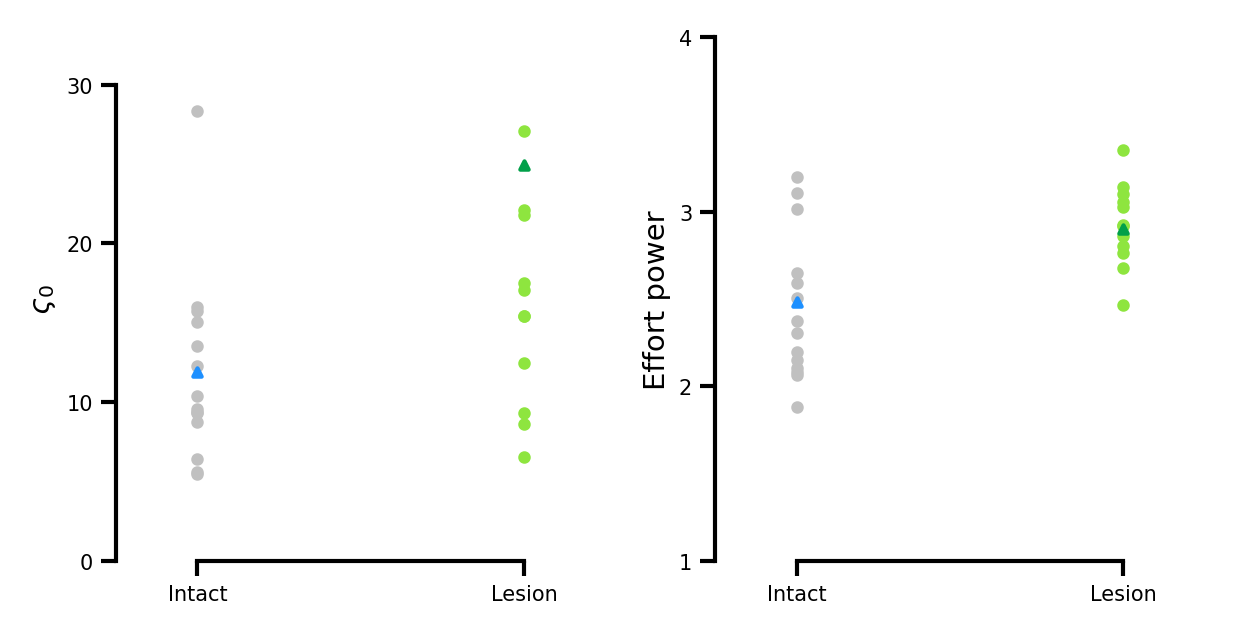

In [24]:
def Figure6_H1_(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if animal ==rat_example_lesion:
            x = 1
            lesion.append(effort_sensitivity_0[animal])
            ax.scatter(x, effort_sensitivity_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], label=f'Example lesion rat', s=4, zorder=10)
        elif animal == rat_example_intact:
            x = 0
            intact.append(effort_sensitivity_0[animal])
            ax.scatter(x, effort_sensitivity_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], label=f'Example intact rat', s=4, zorder=10)
        else:
            if brainstatus[animal] == 'normal':
                x = 0
                intact.append(effort_sensitivity_0[animal])
                ax.scatter(x, effort_sensitivity_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], label=f'Intact rats (n={len(animalList) - len(lesioned)})', s=4, zorder=5)
            else:
                x = 1
                lesion.append(effort_sensitivity_0[animal])
                ax.scatter(x, effort_sensitivity_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], label=f'lesion rats (n={len(lesioned)})', s=4, zorder=5)

    
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 30)
    ax.set_yticks([0, 10, 20, 30])
    ax.set_ylabel(r'$\varsigma_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25, top_y=.1)


def Figure6_H4_(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(power[animal])
            x = 0
        else:
            lesion.append(power[animal])
            x = 1
        ax.scatter(x, power[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 4)
    ax.set_yticks([1, 2, 3, 4])
    # ax.set_ylabel(r'$E^{power}$')
    ax.set_ylabel('Effort power')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)


        
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

Figure6_H1_(axs[0])
Figure6_H4_(axs[1])


plt.savefig("/home/david/Desktop/code/svg/DISTRIB.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

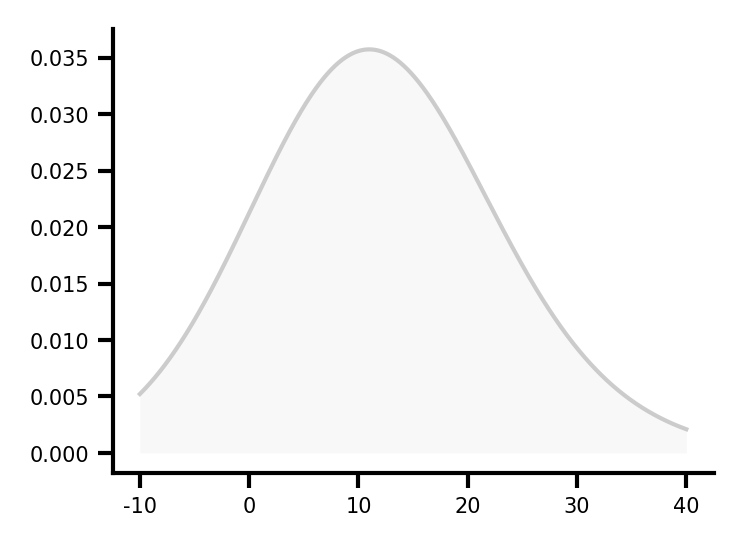

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(cm2inch(6), cm2inch(13)/3))

intact_effort_sensitivity_0 = {animal: effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] == 'normal'}


def _plot_kde(data, bandwidth=10, ax=None, color='k', xx=[-4, 4]):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    data = np.array(data).reshape(-1, 1)
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(data)

    # Compute log density scores
    xx = np.linspace(xx[0], xx[1], 1000).reshape(-1, 1)
    log_densities = kde.score_samples(xx)
    densities = np.exp(log_densities)
    
    ax.plot(xx, densities, color=color, lw=1, alpha=0.8)
    ax.fill_between(xx.flatten(), densities, color=color, alpha=0.1, lw=0)

_plot_kde(list(intact_effort_sensitivity_0.values()), ax=ax, color='silver', xx=[-10, 40])

plt.savefig("/home/david/Desktop/code/svg/DISTRIB2.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

Observed Slope: 121.9824
P-value: 0.0123


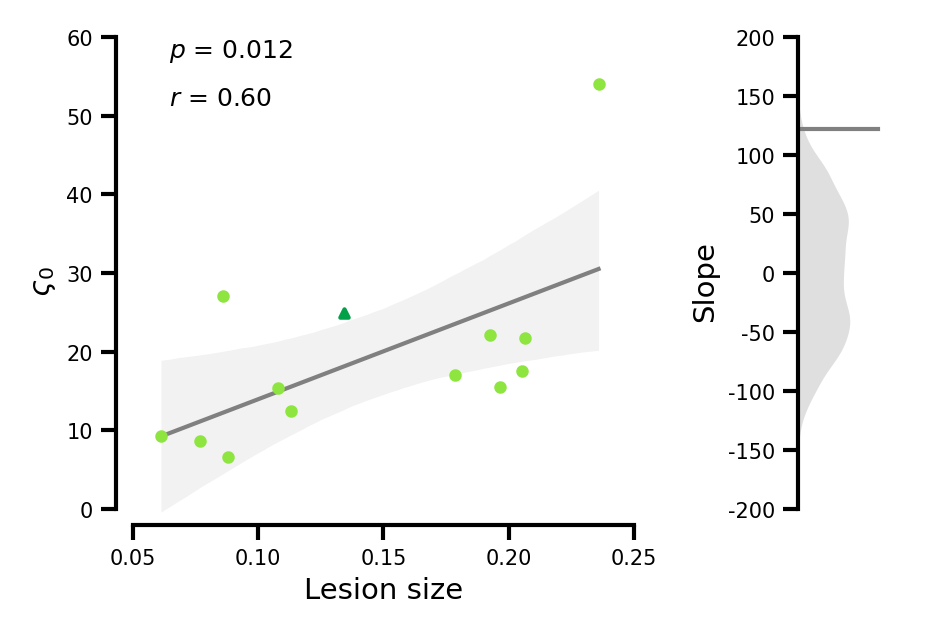

In [26]:
from scipy.optimize import curve_fit

def Figure6_I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_area[animal], effort_sensitivity_0[animal], color=rat_markers[animal][0], zorder=10, s=4, marker=rat_markers[animal][1])
        x.append(lesion_area[animal])
        y.append(effort_sensitivity_0[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # calculate confidence intervals for fitted line
    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000)
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0)
    upper = np.percentile(ysample, 97.5, axis=0)

    # plot the regression and confidence intervals
    y_fit = np.poly1d(p)(xi)
    ax.plot(xi, y_fit, color='gray', zorder=1)
    ax.fill_between(xi, lower, upper, color='gray', alpha=.1, zorder=0, lw=0)


    # shuffle to get p-value
    observed_slope = p[0]
    num_iterations = 10000
    shuffled_slopes = []

    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        p_shuffled, _ = curve_fit(f, x, shuffled_y, [1, 1])
        shuffled_slope = p_shuffled[0]
        shuffled_slopes.append(shuffled_slope)

    # Calculate the p-value
    p_value = (np.abs(shuffled_slopes) >= np.abs(observed_slope)).mean()

    # compute r
    y_mean = np.mean(y)
    y_pred = f(x, *p)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_total)
    r = np.sqrt(r_squared)

    # pvalue annotation
    annotate_regression(p_value, r, ax)



    ax.set_xlabel('Lesion size')
    ax.set_xlim(0.05, .25)
    ax.set_ylabel(r'$\varsigma_0$')
    ax.set_ylim(0, 60)
    ax.set_yticks([0, 10, 20, 30, 40, 50, 60])
    space_axes(ax)
    
    print(f"Observed Slope: {observed_slope:.4f}")
    print(f"P-value: {p_value:.4f}")

    return shuffled_slopes, observed_slope


fig, axs = plt.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios': [5, 1]})
shuffled_slopes, observed_slope = Figure6_I(ax=axs[0])
plot_shuffling(shuffles=shuffled_slopes, observed=observed_slope, ylim=[-200, 200], ax=axs[1], ylabel='Slope')

In [27]:
def Figure6_Ipower(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_area[animal], power[animal], color=rat_markers[animal][0], zorder=10, s=4, marker=rat_markers[animal][1])
        x.append(lesion_area[animal])
        y.append(power[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # calculate confidence intervals for fitted line
    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000)
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0)
    upper = np.percentile(ysample, 97.5, axis=0)

    # plot the regression and confidence intervals
    y_fit = np.poly1d(p)(xi)
    ax.plot(xi, y_fit, color='gray', zorder=1)
    ax.fill_between(xi, lower, upper, color='gray', alpha=.1, zorder=0, lw=0)


    # shuffle to get p-value
    observed_slope = p[0]
    num_iterations = 10000
    shuffled_slopes = []

    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        p_shuffled, _ = curve_fit(f, x, shuffled_y, [1, 1])
        shuffled_slope = p_shuffled[0]
        shuffled_slopes.append(shuffled_slope)

    # Calculate the p-value
    p_value = (np.abs(shuffled_slopes) >= np.abs(observed_slope)).mean()

    # compute r
    y_mean = np.mean(y)
    y_pred = f(x, *p)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_total)
    r = np.sqrt(r_squared)

    # pvalue annotation
    ax.annotate(f"$p$ = {p_value:.3f}", xy=(.50, .18), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.3f}", xy=(.50, .1), xycoords='axes fraction', fontsize=7, ha='left', va='top')

    ax.set_xlabel('Lesion size')
    ax.set_xlim(0.05, .25)
    ax.set_ylabel(r'power')
    ax.set_ylim(2.2, 3.4)
    space_axes(ax)
    
    print(f"Observed Slope: {observed_slope:.4f}")
    print(f"P-value: {p_value:.4f}")

    return shuffled_slopes, observed_slope

Observed Slope: 0.0560
P-value: 0.9598


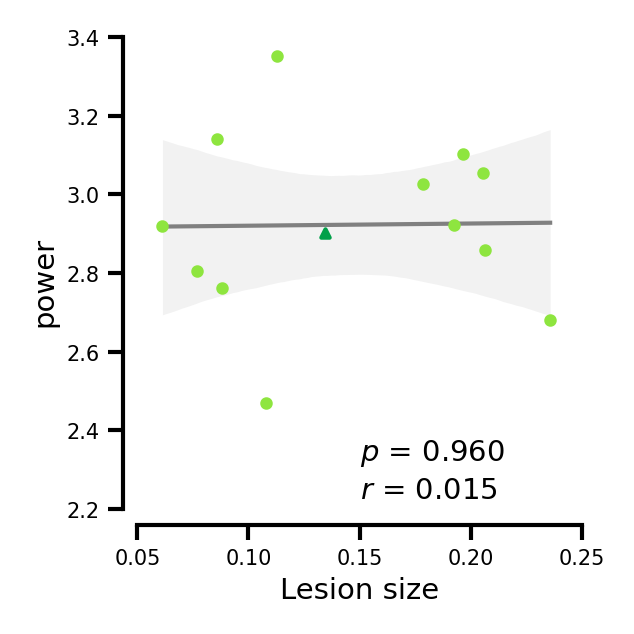

In [28]:
Figure6_Ipower();

$\alpha_0$ 0.2964
$\alpha_t$ 0.098
$\alpha_u$ 0.6512
$\gamma_0$ 1.0
$\gamma_t$ 0.6804
$\gamma_u$ 0.7663


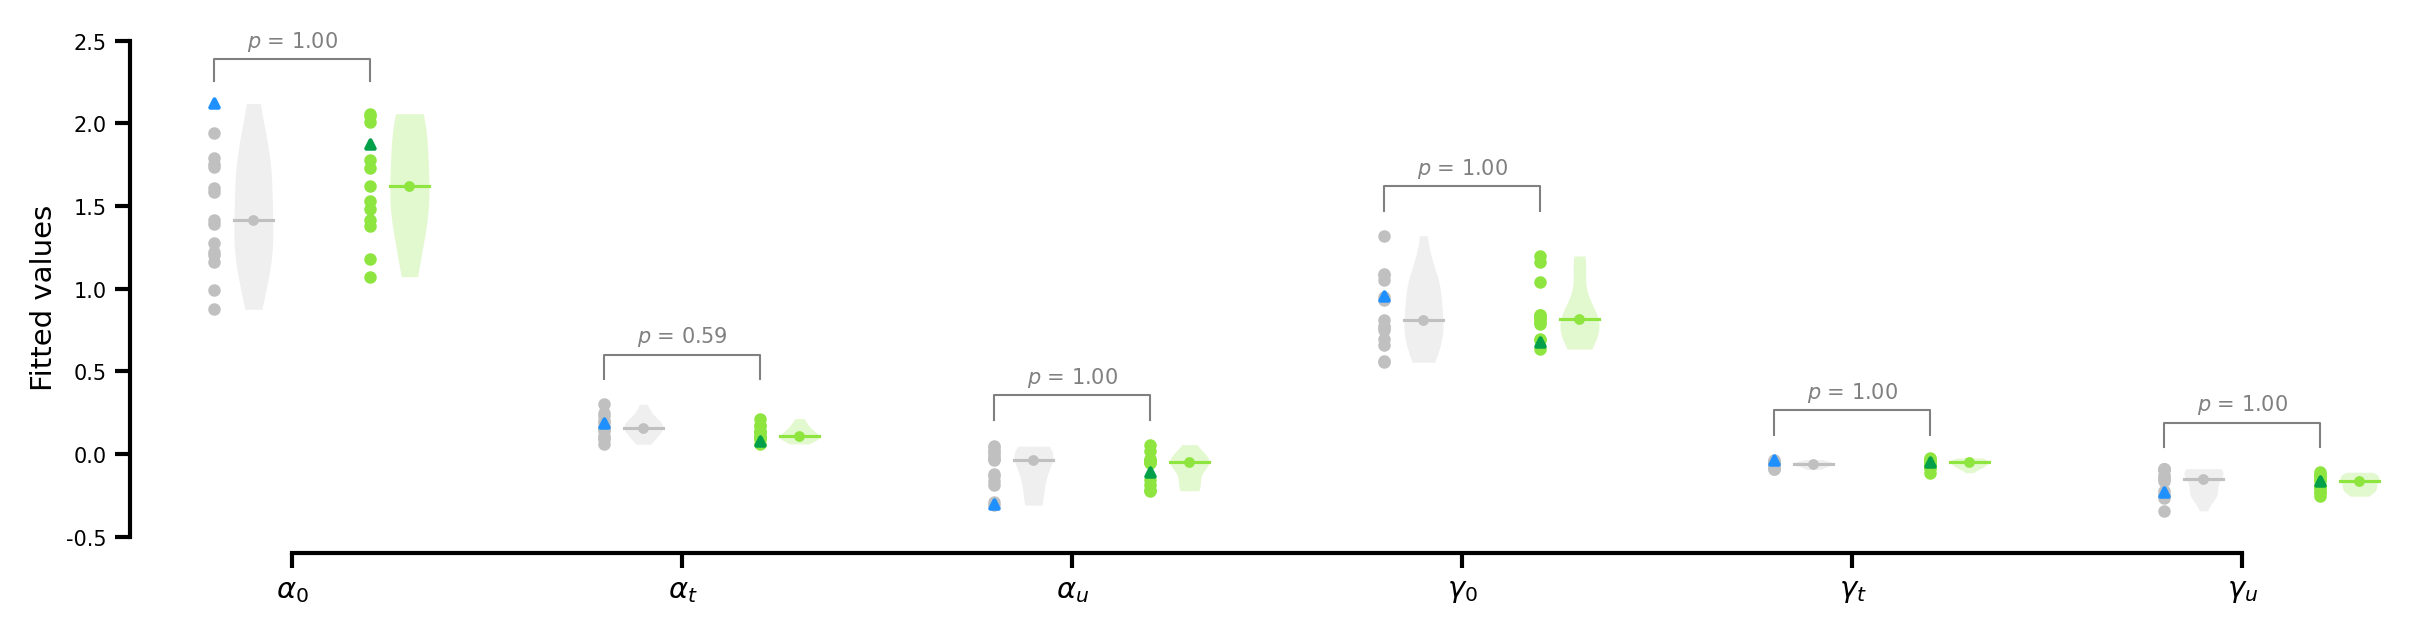

In [29]:
def Figure6X(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    vars = [#effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, 
            median_alpha_0, median_alpha_t, median_alpha_u, 
            median_gamma_0, median_gamma_t, median_gamma_u, 
            # median_mu_0, median_mu_t, median_mu_u, 
            # median_sigma_0, median_sigma_t, median_sigma_u
            ]

    labels = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_u$", 
              r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_u$", 
            #   r'$\mu_0$', r"$\mu_t$", r"$\mu_u$", 
              #r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_u$"
              ]
    
    pvalues = []
    max = []
    for i, (var, label) in enumerate(zip(vars, labels)):
        intact, lesion = [], []
        for animal in animalList:
            if brainstatus[animal] == 'normal':
                intact.append(var[animal])
                x = i - .2
            else:
                lesion.append(var[animal])
                x = i + .2

            ax.scatter(x, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)


        violin_parts = ax.violinplot(positions=[i-.1], 
                        dataset=[intact],
                        widths=0.1, showextrema=False)
    
        for vp in violin_parts['bodies']:
            vp.set_facecolor('silver')
            vp.set_edgecolor('silver')
            vp.set_linewidth(0)
            vp.set_alpha(0.25)

        s=.05
        ax.plot([i-.1-s, i-.1+s], [np.median(intact), np.median(intact)], 
                color='silver', lw=.75, zorder=2)
        ax.scatter(i-.1, np.median(intact), color='silver', s=2.5, zorder=3)



        violin_parts = ax.violinplot(positions=[i+.3], 
                        dataset=[lesion],
                        widths=0.1, showextrema=False)
    
        for vp in violin_parts['bodies']:
            vp.set_facecolor('xkcd:kiwi green')
            vp.set_edgecolor('xkcd:kiwi green')
            vp.set_linewidth(0)
            vp.set_alpha(0.25)
        
        ax.plot([i+.3-s, i+.3+s], [np.median(lesion), np.median(lesion)], 
                color='xkcd:kiwi green', lw=.75, zorder=2)
        ax.scatter(i+.3, np.median(lesion), color='xkcd:kiwi green', s=2.5, zorder=3)

        perm = exact_mc_perm_test(intact, lesion)
        pvalues.append(perm)
        max.append((np.max(intact), np.max(lesion)))
        print(label, perm)
        
    sig, corrected_pvalues, alphabonf = multipletests_bonferroni(pvalues, )
    for i, perm in enumerate(corrected_pvalues):
        barplot_annotate_brackets(ax, 0, 1, perm, [i-.2, i+.2], [max[i][0], max[i][1]], maxasterix=None)
        
    ax.set_xticks(range(len(vars)))
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_ylim(-.5, 2.5)
    ax.set_ylabel('Fitted values')
    ax.set_xlim(0, 5)
    space_axes(ax, x_ratio_left=.5/6, x_ratio_right=.5/6)

fig, axs = plt.subplots(1, 1, figsize=(8, 2))
Figure6X(ax=axs);

$\alpha_0$ 0.3147
$\alpha_t$ 0.1009
$\alpha_u$ 0.6565
$\gamma_0$ 1.0
$\gamma_t$ 0.6751
$\gamma_u$ 0.7623


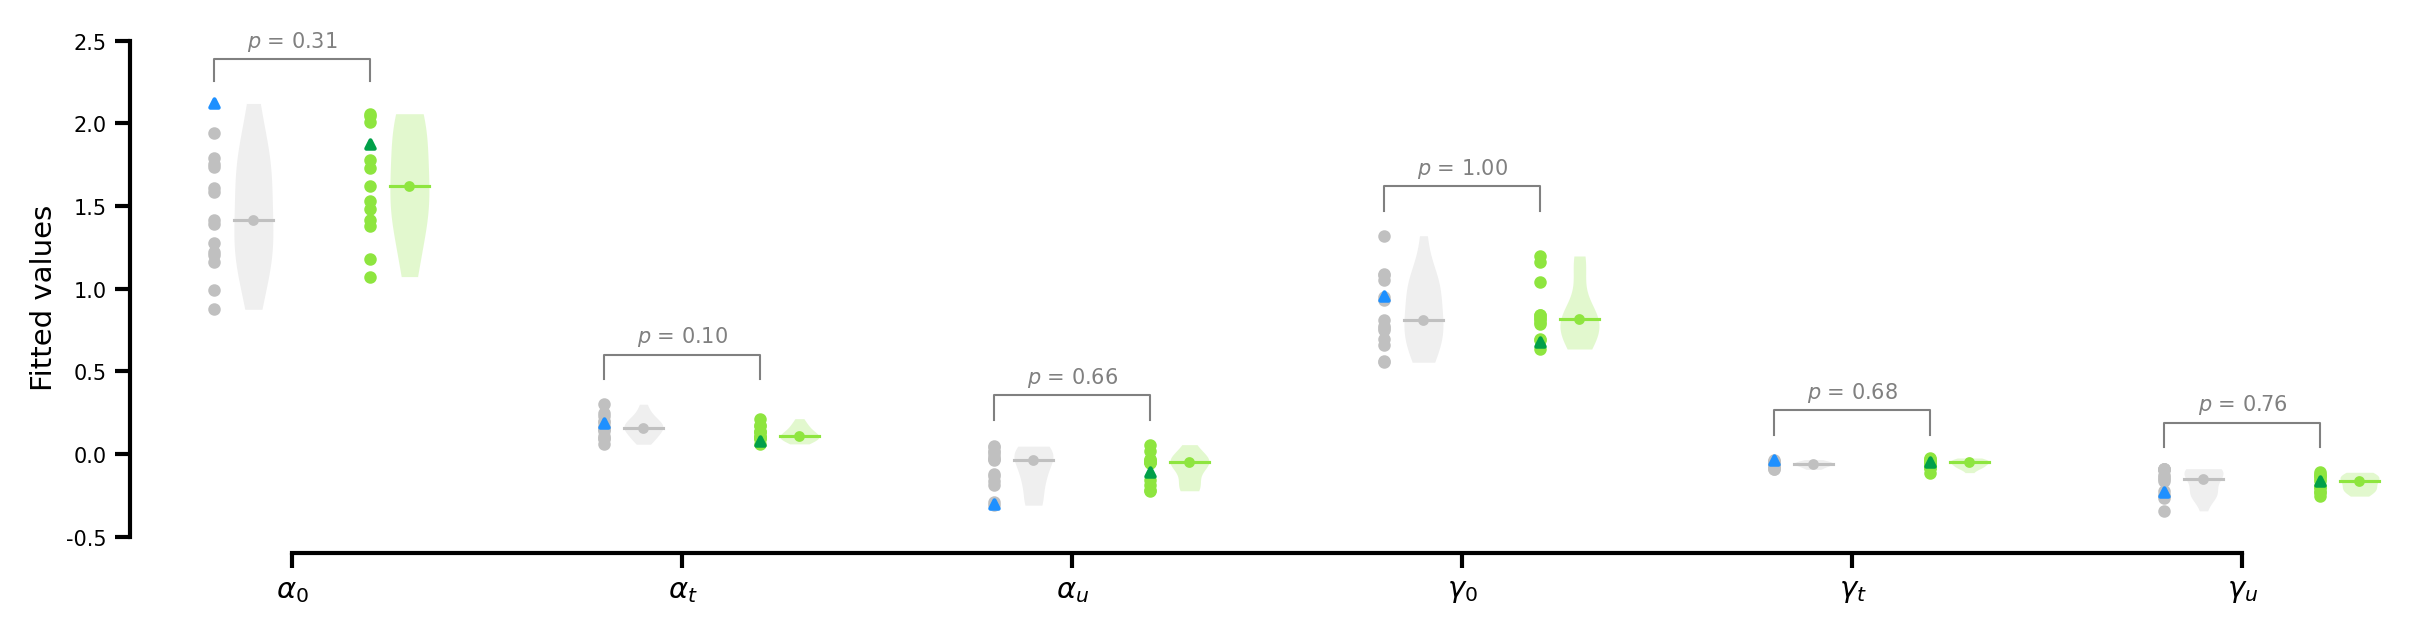

In [30]:
def Figure6Xold(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    vars = [#effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, 
            median_alpha_0, median_alpha_t, median_alpha_u, 
            median_gamma_0, median_gamma_t, median_gamma_u, 
            # median_mu_0, median_mu_t, median_mu_u, 
            # median_sigma_0, median_sigma_t, median_sigma_u
            ]

    labels = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_u$", 
              r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_u$", 
            #   r'$\mu_0$', r"$\mu_t$", r"$\mu_u$", 
              #r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_u$"
              ]
    
    perm = np.zeros(len(vars))
    maxintact, maxlesion = np.zeros(len(vars)), np.zeros(len(vars))

    for i, (var, label) in enumerate(zip(vars, labels)):
        intact, lesion = [], []
        for animal in animalList:
            if brainstatus[animal] == 'normal':
                intact.append(var[animal])
                x = i - .2
            else:
                lesion.append(var[animal])
                x = i + .2

            ax.scatter(x, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)


        violin_parts = ax.violinplot(positions=[i-.1], 
                        dataset=[intact],
                        widths=0.1, showextrema=False)
    
        for vp in violin_parts['bodies']:
            vp.set_facecolor('silver')
            vp.set_edgecolor('silver')
            vp.set_linewidth(0)
            vp.set_alpha(0.25)

        s=.05
        ax.plot([i-.1-s, i-.1+s], [np.median(intact), np.median(intact)], 
                color='silver', lw=.75, zorder=2)
        ax.scatter(i-.1, np.median(intact), color='silver', s=2.5, zorder=3)



        violin_parts = ax.violinplot(positions=[i+.3], 
                        dataset=[lesion],
                        widths=0.1, showextrema=False)
    
        for vp in violin_parts['bodies']:
            vp.set_facecolor('xkcd:kiwi green')
            vp.set_edgecolor('xkcd:kiwi green')
            vp.set_linewidth(0)
            vp.set_alpha(0.25)
        
        ax.plot([i+.3-s, i+.3+s], [np.median(lesion), np.median(lesion)], 
                color='xkcd:kiwi green', lw=.75, zorder=2)
        ax.scatter(i+.3, np.median(lesion), color='xkcd:kiwi green', s=2.5, zorder=3)

        perm[i] = exact_mc_perm_test(intact, lesion)
        maxintact[i] = np.max(intact)
        maxlesion[i] = np.max(lesion)

    for i, (var, label) in enumerate(zip(vars, labels)):
        print(label, perm[i])
        barplot_annotate_brackets(ax, 0, 1, perm[i], [i-.2, i+.2], [maxintact[i], maxlesion[i]], maxasterix=None)
    
    ax.set_xticks(range(len(vars)))
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_ylim(-.5, 2.5)
    ax.set_ylabel('Fitted values')
    ax.set_xlim(0, 5)
    space_axes(ax, x_ratio_left=.5/6, x_ratio_right=.5/6)

fig, axs = plt.subplots(1, 1, figsize=(8, 2))
Figure6Xold(ax=axs);

$\varsigma_0$ 0.0069
$\varsigma_t$ 0.1571
$\varsigma_u$ 0.839
[ True False False] [0.0207 0.4713 1.    ] 0.016666666666666666


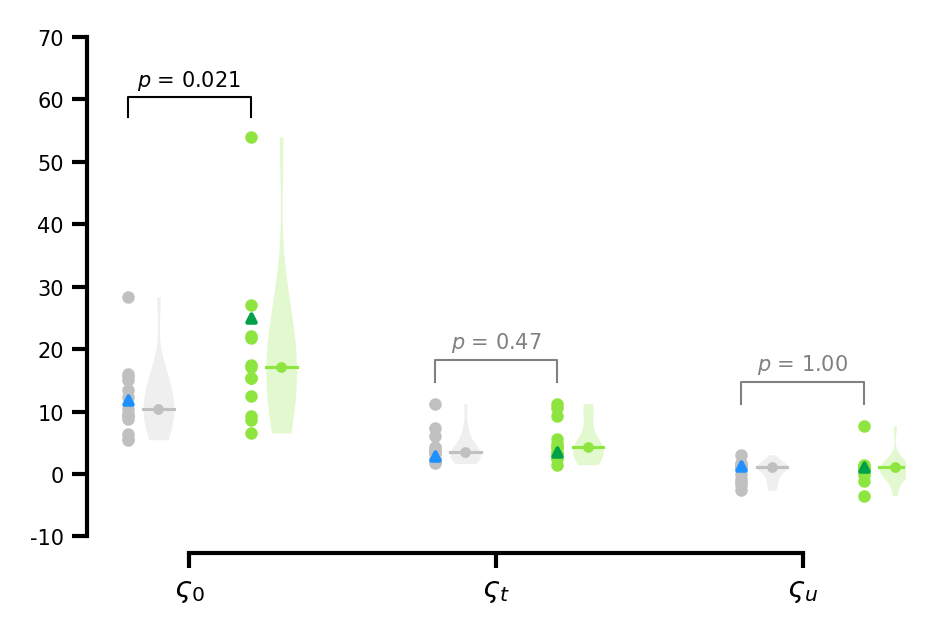

In [31]:
def Figure6XX(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    vars = [effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u,
            # median_alpha_0, median_alpha_t, median_alpha_u, 
            # median_gamma_0, median_gamma_t, median_gamma_u, 
            # median_mu_0, median_mu_t, median_mu_u, 
            # median_sigma_0, median_sigma_t, median_sigma_u
            ]

    labels = [r'$\varsigma_0$', r"$\varsigma_t$", r"$\varsigma_u$"
            #r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_u$", 
              #r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_u$", 
            #   r'$\mu_0$', r"$\mu_t$", r"$\mu_u$", 
              #r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_u$"
              ]

    perm = np.zeros(len(vars))
    maxintact, maxlesion = np.zeros(len(vars)), np.zeros(len(vars))
    
    for i, (var, label) in enumerate(zip(vars, labels)):
        intact, lesion = [], []
        for animal in animalList:
            if brainstatus[animal] == 'normal':
                intact.append(var[animal])
                x = i - .2
            else:
                lesion.append(var[animal])
                x = i + .2

            ax.scatter(x, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)


        violin_parts = ax.violinplot(positions=[i-.1], 
                        dataset=[intact],
                        widths=0.1, showextrema=False)
    
        for vp in violin_parts['bodies']:
            vp.set_facecolor('silver')
            vp.set_edgecolor('silver')
            vp.set_linewidth(0)
            vp.set_alpha(0.25)

        s=.05
        ax.plot([i-.1-s, i-.1+s], [np.median(intact), np.median(intact)], 
                color='silver', lw=.75, zorder=2)
        ax.scatter(i-.1, np.median(intact), color='silver', s=2.5, zorder=3)
        

        violin_parts = ax.violinplot(positions=[i+.3], 
                        dataset=[lesion],
                        widths=0.1, showextrema=False)
    
        for vp in violin_parts['bodies']:
            vp.set_facecolor('xkcd:kiwi green')
            vp.set_edgecolor('xkcd:kiwi green')
            vp.set_linewidth(0)
            vp.set_alpha(0.25)
            
        ax.plot([i+.3-s, i+.3+s], [np.median(lesion), np.median(lesion)], 
                color='xkcd:kiwi green', lw=.75, zorder=2)
        ax.scatter(i+.3, np.median(lesion), color='xkcd:kiwi green', s=2.5, zorder=3)

        perm[i] = exact_mc_perm_test(intact, lesion)
        print(label, perm[i])
        maxintact[i] = np.max(intact)
        maxlesion[i] = np.max(lesion)

    sig, corrected_pvalues, alphabonf = multipletests_bonferroni(perm, )
    print(sig, corrected_pvalues, alphabonf)
    for i, (var, label) in enumerate(zip(vars, labels)):
        barplot_annotate_brackets(ax, 0, 1, corrected_pvalues[i], [i-.2, i+.2], [maxintact[i], maxlesion[i]], maxasterix=None)

    
    ax.set_xticks(range(len(vars)))
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_ylim(-10, 70)
    ax.set_yticks([-10, 0, 10, 20, 30, 40, 50, 60, 70])
    ax.set_xlim(0, 2)
    space_axes(ax, x_ratio_left=.5/3, x_ratio_right=.5/3)

fig, axs = plt.subplots(1, 1, figsize=(3, 2))
Figure6XX(ax=axs);

$\beta$ 0.007


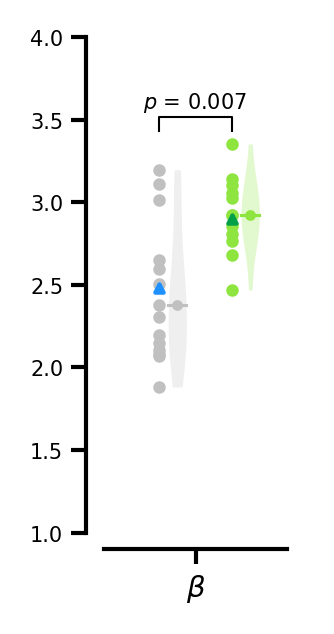

In [32]:
def Figure6XXX(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    vars = [ power,
            # median_alpha_0, median_alpha_t, median_alpha_u, 
            # median_gamma_0, median_gamma_t, median_gamma_u, 
            # median_mu_0, median_mu_t, median_mu_u, 
            # median_sigma_0, median_sigma_t, median_sigma_u
            ]

    labels = [ r"$\beta$"
            #r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_u$", 
              #r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_u$", 
            #   r'$\mu_0$', r"$\mu_t$", r"$\mu_u$", 
              #r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_u$"
              ]

    perm = np.zeros(len(vars))
    maxintact, maxlesion = np.zeros(len(vars)), np.zeros(len(vars))
    
    for i, (var, label) in enumerate(zip(vars, labels)):
        intact, lesion = [], []
        for animal in animalList:
            if brainstatus[animal] == 'normal':
                intact.append(var[animal])
                x = i - .2
            else:
                lesion.append(var[animal])
                x = i + .2

            ax.scatter(x, var[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)


        violin_parts = ax.violinplot(positions=[i-.1], 
                        dataset=[intact],
                        widths=0.1, showextrema=False)
    
        for vp in violin_parts['bodies']:
            vp.set_facecolor('silver')
            vp.set_edgecolor('silver')
            vp.set_linewidth(0)
            vp.set_alpha(0.25)

        s=.05
        ax.plot([i-.1-s, i-.1+s], [np.median(intact), np.median(intact)], 
                color='silver', lw=.75, zorder=2)
        ax.scatter(i-.1, np.median(intact), color='silver', s=2.5, zorder=3)
        

        violin_parts = ax.violinplot(positions=[i+.3], 
                        dataset=[lesion],
                        widths=0.1, showextrema=False)
    
        for vp in violin_parts['bodies']:
            vp.set_facecolor('xkcd:kiwi green')
            vp.set_edgecolor('xkcd:kiwi green')
            vp.set_linewidth(0)
            vp.set_alpha(0.25)
            
        ax.plot([i+.3-s, i+.3+s], [np.median(lesion), np.median(lesion)], 
                color='xkcd:kiwi green', lw=.75, zorder=2)
        ax.scatter(i+.3, np.median(lesion), color='xkcd:kiwi green', s=2.5, zorder=3)

        perm[i] = exact_mc_perm_test(intact, lesion)
        maxintact[i] = np.max(intact)
        maxlesion[i] = np.max(lesion)

    for i, (var, label) in enumerate(zip(vars, labels)):
        print(label, perm[i])
        barplot_annotate_brackets(ax, 0, 1, perm[i], [i-.2, i+.2], [maxintact[i], maxlesion[i]], maxasterix=None)
    
    ax.set_xticks(range(len(vars)))
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_ylim(1, 4)
    ax.set_xlim(-.5, .5)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)

fig, axs = plt.subplots(1, 1, figsize=(1, 2))
Figure6XXX(ax=axs);

alpha_0 0.3033
alpha_t 0.1001
alpha_t MWU 0.05893484040214102
alpha_u 0.6408


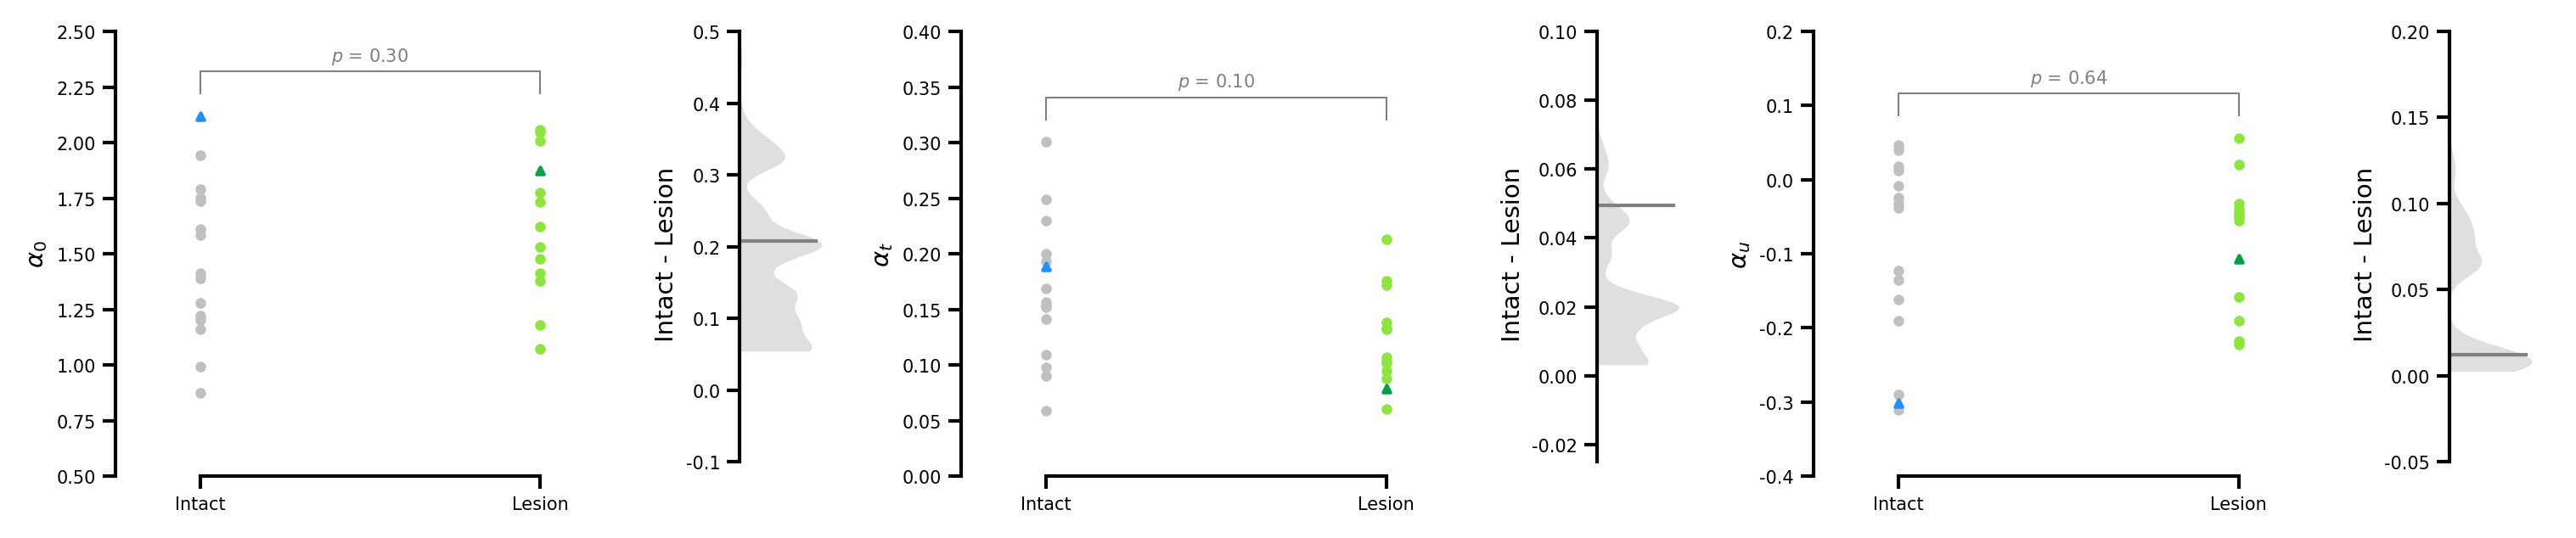

In [33]:
def Figure6_J1(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(median_alpha_0[animal])
            x = 0
        else:
            lesion.append(median_alpha_0[animal])
            x = 1
        ax.scatter(x, median_alpha_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0.5, 2.5)
    ax.set_ylabel(r'$\alpha_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm, shuffles, observed_diff = exact_mc_perm_test(intact, lesion, return_shuffled=True)
    print("alpha_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
    return shuffles, observed_diff

def Figure6_J2(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(median_alpha_t[animal])
            x = 0
        else:
            lesion.append(median_alpha_t[animal])
            x = 1
        ax.scatter(x, median_alpha_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, .4)
    ax.set_ylabel(r'$\alpha_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm, shuffles, observed_diff = exact_mc_perm_test(intact, lesion, return_shuffled=True)
    print("alpha_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

    t_stat, p_value = stats.mannwhitneyu(intact, lesion)
    print("alpha_t MWU", p_value)
    return shuffles, observed_diff

def Figure6_J3(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(median_alpha_u[animal])
            x = 0
        else:
            lesion.append(median_alpha_u[animal])
            x = 1
        ax.scatter(x, median_alpha_u[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.4, .2)
    ax.set_ylabel(r'$\alpha_u$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm, shuffles, observed_diff = exact_mc_perm_test(intact, lesion, return_shuffled=True)
    print("alpha_u", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
    return shuffles, observed_diff

fig, axs = plt.subplots(1, 6, figsize=(10, 2), gridspec_kw={'width_ratios': [5, 1, 5, 1, 5, 1]})

s, o = Figure6_J1(axs[0])
plot_shuffling(shuffles=s, observed=o, ylim=[-.1, .5], xlim=[0, .3], ax=axs[1], ylabel='Intact - Lesion')
s, o = Figure6_J2(axs[2])
plot_shuffling(shuffles=s, observed=o, ylim=[-.025, .1], xlim=[0, .3], ax=axs[3], ylabel='Intact - Lesion')
s, o = Figure6_J3(axs[4])
plot_shuffling(shuffles=s, observed=o, ylim=[-.05, .2], xlim=[0, .3], ax=axs[5], ylabel='Intact - Lesion')

gamma_0 1.0
gamma_t 0.6938
gamma_u 0.7602


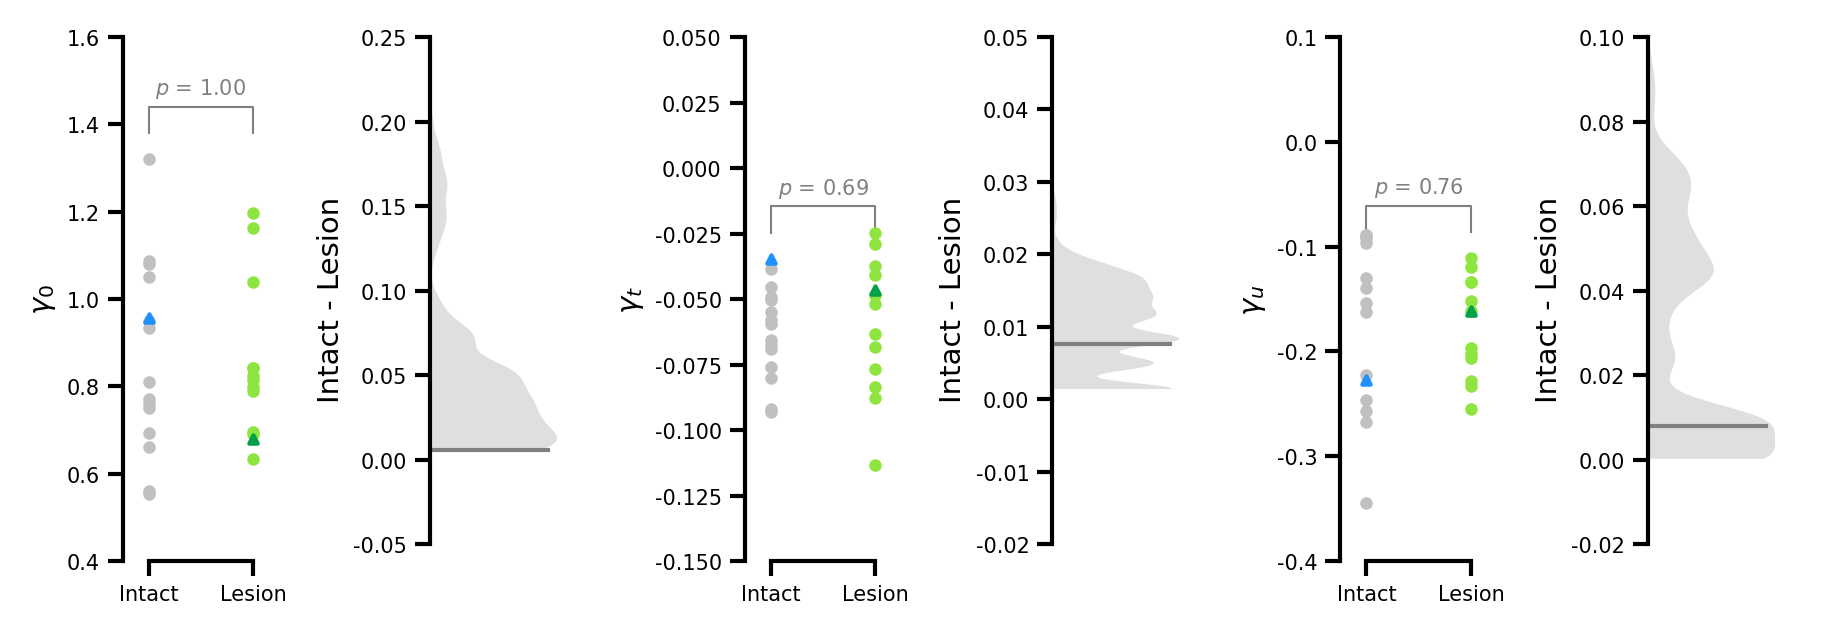

In [34]:
def Figure6_K1(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(median_gamma_0[animal])
            x = 0
        else:
            lesion.append(median_gamma_0[animal])
            x = 1
        ax.scatter(x, median_gamma_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0.4, 1.6)
    ax.set_ylabel(r'$\gamma_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm, shuffles, observed_diff = exact_mc_perm_test(intact, lesion, return_shuffled=True)
    print("gamma_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
    return shuffles, observed_diff

def Figure6_K2(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(median_gamma_t[animal])
            x = 0
        else:
            lesion.append(median_gamma_t[animal])
            x = 1
        ax.scatter(x, median_gamma_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.15, 0.05)
    ax.set_ylabel(r'$\gamma_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm, shuffles, observed_diff = exact_mc_perm_test(intact, lesion, return_shuffled=True)
    print("gamma_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
    return shuffles, observed_diff

def Figure6_K3(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(median_gamma_u[animal])
            x = 0
        else:
            lesion.append(median_gamma_u[animal])
            x = 1
        ax.scatter(x, median_gamma_u[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.4, .1)
    ax.set_ylabel(r'$\gamma_u$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm, shuffles, observed_diff = exact_mc_perm_test(intact, lesion, return_shuffled=True)
    print("gamma_u", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
    return shuffles, observed_diff
        
fig, axs = plt.subplots(1, 6, figsize=(6, 2))

s, o = Figure6_K1(axs[0])
plot_shuffling(shuffles=s, observed=o, ylim=[-.05, .25], xlim=[0, .3], ax=axs[1], ylabel='Intact - Lesion')
s, o = Figure6_K2(axs[2])
plot_shuffling(shuffles=s, observed=o, ylim=[-.02, .05], xlim=[0, .3], ax=axs[3], ylabel='Intact - Lesion')
s, o = Figure6_K3(axs[4])
plot_shuffling(shuffles=s, observed=o, ylim=[-.02, .1], xlim=[0, .3], ax=axs[5], ylabel='Intact - Lesion')



mu_0 0.0403
mu_0 MWU 0.1532844720368013
d = -0.47

mu_0 0.0035
mu_0 MWU 0.0017335785490894002
d = -1.47
[False  True] [0.0806 0.007 ] 0.025


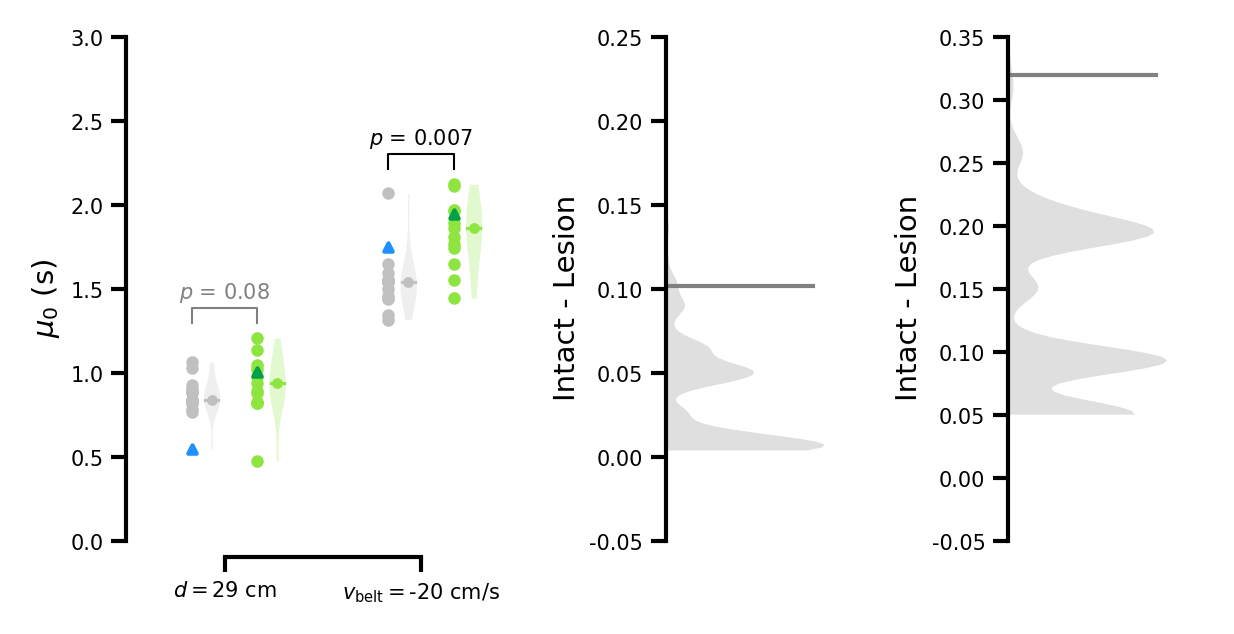

In [35]:
def Figure6_G_(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(mu_0[animal]['60'])
            x = 0
        else:
            lesion.append(mu_0[animal]['60'])
            x = 1
        ax.scatter(x, mu_0[animal]['60'], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)

    violin_parts = ax.violinplot(positions=[0.3], 
                    dataset=[intact],
                    widths=0.25, showextrema=False)

    for vp in violin_parts['bodies']:
        vp.set_facecolor('silver')
        vp.set_edgecolor('silver')
        vp.set_linewidth(0)
        vp.set_alpha(0.25)

    s=.1
    ax.plot([0.3-s, 0.3+s], [np.median(intact), np.median(intact)], 
            color='silver', lw=.75, zorder=2)
    ax.scatter(0.3, np.median(intact), color='silver', s=2.5, zorder=3)
    

    violin_parts = ax.violinplot(positions=[1.3], 
                    dataset=[lesion],
                    widths=0.25, showextrema=False)

    for vp in violin_parts['bodies']:
        vp.set_facecolor('xkcd:kiwi green')
        vp.set_edgecolor('xkcd:kiwi green')
        vp.set_linewidth(0)
        vp.set_alpha(0.25)
        
    ax.plot([1.3-s, 1.3+s], [np.median(lesion), np.median(lesion)], 
            color='xkcd:kiwi green', lw=.75, zorder=2)
    ax.scatter(1.3, np.median(lesion), color='xkcd:kiwi green', s=2.5, zorder=3)

    _intact = intact.copy()
    _lesion = lesion.copy()
    perm60, shuffles60, observed_diff60 = exact_mc_perm_test(_intact, _lesion, return_shuffled=True)
    print("mu_0", perm60)

    

    t_stat60, p_value60 = stats.mannwhitneyu(_intact, _lesion)
    print("mu_0 MWU", p_value60)
    print(f'd = {cohen_d(_intact, _lesion):.2f}')
    print()









    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(mu_0[animal]['rev20'])
            x = 3
        else:
            lesion.append(mu_0[animal]['rev20'])
            x = 4
        ax.scatter(x, mu_0[animal]['rev20'], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4, zorder=10 if animal == rat_example_lesion or animal == rat_example_intact else 5)
    

    violin_parts = ax.violinplot(positions=[3.3], 
                    dataset=[intact],
                    widths=0.25, showextrema=False)

    for vp in violin_parts['bodies']:
        vp.set_facecolor('silver')
        vp.set_edgecolor('silver')
        vp.set_linewidth(0)
        vp.set_alpha(0.25)

    ax.plot([3.3-s, 3.3+s], [np.median(intact), np.median(intact)], 
            color='silver', lw=.75, zorder=2)
    ax.scatter(3.3, np.median(intact), color='silver', s=2.5, zorder=3)
    

    violin_parts = ax.violinplot(positions=[4.3], 
                    dataset=[lesion],
                    widths=0.25, showextrema=False)

    for vp in violin_parts['bodies']:
        vp.set_facecolor('xkcd:kiwi green')
        vp.set_edgecolor('xkcd:kiwi green')
        vp.set_linewidth(0)
        vp.set_alpha(0.25)
        
    ax.plot([4.3-s, 4.3+s], [np.median(lesion), np.median(lesion)], 
            color='xkcd:kiwi green', lw=.75, zorder=2)
    ax.scatter(4.3, np.median(lesion), color='xkcd:kiwi green', s=2.5, zorder=3)


    perm, shufflesrev20, observed_diffrev20 = exact_mc_perm_test(intact, lesion, return_shuffled=True)
    print("mu_0", perm)

    t_stat, p_value = stats.mannwhitneyu(intact, lesion)
    print("mu_0 MWU", p_value)
    print(f'd = {cohen_d(intact, lesion):.2f}')

    sig, corrected_pvalues, alphabonf = multipletests_bonferroni([perm60, perm], )
    print(sig, corrected_pvalues, alphabonf)
    corrected_60, corrected_rev20 = corrected_pvalues
    # barplot_annotate_brackets(ax, 0, 1, perm60, [0, 1], [np.max(_intact), np.max(_lesion)], maxasterix=None)
    # barplot_annotate_brackets(ax, 0, 1, perm, [3, 4], [np.max(intact), np.max(lesion)], maxasterix=None)
    barplot_annotate_brackets(ax, 0, 1, corrected_60, [0, 1], [np.max(_intact), np.max(_lesion)], maxasterix=None)
    barplot_annotate_brackets(ax, 0, 1, corrected_rev20, [3, 4], [np.max(intact), np.max(lesion)], maxasterix=None)
    
    ax.set_xlim(0.5, 3.5)
    ax.set_xticks([0.5, 3.5])
    ax.set_xticklabels([r'$d=$29 cm', r'$v_{\mathrm{belt}}=$-20 cm/s'])
    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\mu_0$ (s)')
    space_axes(ax, x_ratio_left=.5, x_ratio_right=.5)

    return shuffles60, observed_diff60, shufflesrev20, observed_diffrev20


        
fig, axs = plt.subplots(1, 3, figsize=(4, 2), gridspec_kw={'width_ratios': [2, 1, 1]})

s60, o60, srev20, orev20 = Figure6_G_(axs[0])
plot_shuffling(shuffles=s60, observed=o60, ylim=[-.05, .25], xlim=[0, .3], ax=axs[1], ylabel='Intact - Lesion')
plot_shuffling(shuffles=srev20, observed=orev20, ylim=[-.05, .35], xlim=[0, .3], ax=axs[2], ylabel='Intact - Lesion')


In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def do_LDA_lesion():
    animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']
 
    
    alpha, alpha_t, alpha_u, gamma, gamma_t, gamma_u, mu, mu_t, mu_u, sigma, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
    effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, power = pickle.load(open('picklejar/effort_sensitivity_fit.p', 'rb'))


    vars = alpha, alpha_t, gamma, gamma_t, gamma_u, effort_sensitivity_0, effort_sensitivity_t, power
    names = 'alpha', 'alpha_t', 'gamma', 'gamma_t', 'gamma_u', 'mu', 'mu_t', 'beta'

    df = pd.DataFrame(index=animalList)
    for var, name in zip(vars, names):
        if name in ['alpha', 'alpha_t', 'gamma', 'gamma_t', 'gamma_u']:
            l = np.array(list(compute_intercept(var, animalList).values()))  # x - Xmean
            df[name] = l / np.std(l)  # normalize by std to have a mean of 0 and std of 1
        else:
            l = [[var[animal] - np.mean([var[animal] for animal in animalList])] for animal in animalList]/ np.std([var[animal] for animal in animalList])
            df[name] = l / np.std(l)

    data = df.to_numpy()
    labels = df.index.to_numpy()
    labels = ["lesion" if brainstatus[animal] != 'normal' else "intact" for animal in labels]
    lda = LDA(solver='eigen', shrinkage='auto')
    lda.fit(data, labels)
    X_lda = lda.transform(data)
    return X_lda, lda

do_LDA_lesion();

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


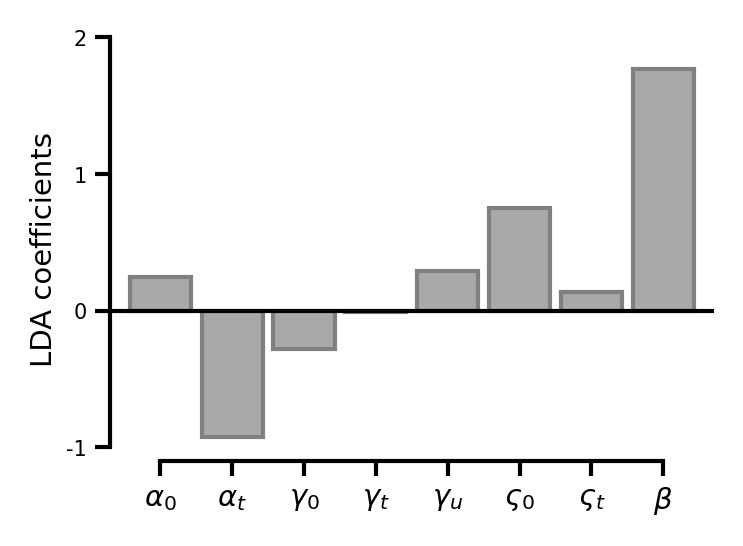

In [37]:
def Figure6Y(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(6), cm2inch(13)/3))

    vars = [r'$\alpha_0$', r"$\alpha_t$", r'$\gamma_0$', 
            r"$\gamma_t$", r"$\gamma_u$", r'$\varsigma_0$', r"$\varsigma_t$", r"$\beta$"]
    score, lda = do_LDA_lesion()
    for var, coef in zip(vars, lda.coef_[0]):
        ax.bar(var, coef, color='gray', width=.85, facecolor='darkgray', edgecolor='gray', lw=1, zorder=1)

    ax.set_xlim(0, 7)
    ax.set_xticklabels(vars, fontsize=7)
    ax.set_ylim(-1, 2)
    ax.set_yticks([-1, 0, 1, 2])
    ax.set_ylabel('LDA coefficients')
    ax.axhline(0, color='k', lw=1)
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)

Figure6Y()

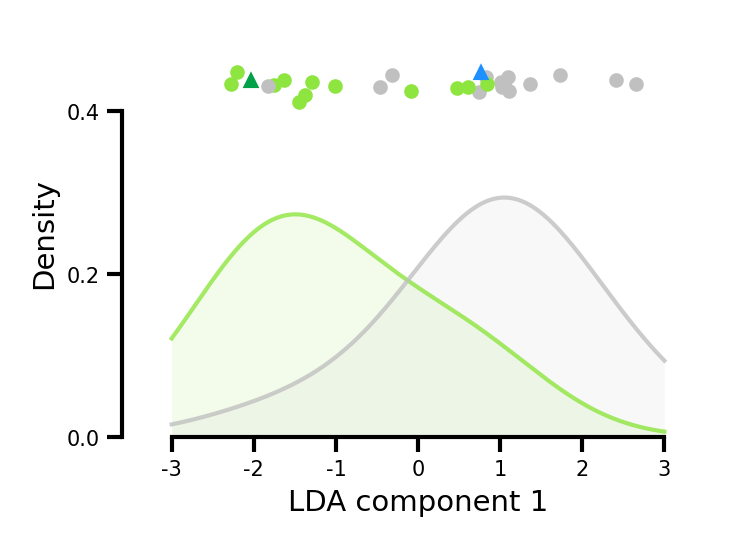

In [38]:
def Figure6Z(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(6), cm2inch(13)/3))

    animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']
 

    vars = [r'$\alpha_0$', r"$\alpha_t$", r'$\gamma_0$', 
            r"$\gamma_t$", r"$\gamma_u$", r'$\varsigma_0$', r"$\varsigma_t$", r"$\beta$"]
    score, lda = do_LDA_lesion()

    np.random.seed(0)
    for i, animal in enumerate(animalList):
        y = abs(np.random.normal(0.43, 0.0075))
        _zorder = 10 if animal == rat_example_lesion or animal == rat_example_intact else 5
        ax.plot(score[i, 0], y, color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=2.5, zorder=_zorder)

    # print(np.min(score[:, 0]), np.max(score[:, 0]))
    X_lda_lesion = [score[i, 0] for i, animal in enumerate(animalList) if brainstatus[animal] != 'normal']
    X_lda_intact = [score[i, 0] for i, animal in enumerate(animalList) if brainstatus[animal] == 'normal']

    plot_kde(X_lda_lesion, ax=ax, color='xkcd:kiwi green', xx=[-3, 3])
    plot_kde(X_lda_intact, ax=ax, color='silver', xx=[-3, 3])

    ax.set_xlim(-3, 3)
    ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
    ax.set_ylim(0, .4)
    ax.set_yticks([0, 0.2, 0.4])
    ax.set_xlabel('LDA component 1')
    ax.set_ylabel('Density')
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1, top_y=.25)

Figure6Z()

$\alpha_0$ 0.3044
$\alpha_t$ 0.0901
$\alpha_u$ 0.6453
$\gamma_0$ 1.0
$\gamma_t$ 0.6874
$\gamma_u$ 0.7623
$\varsigma_0$ 0.0073
$\varsigma_t$ 0.1534
$\varsigma_u$ 0.8347
[ True False False] [0.0219 0.4602 1.    ] 0.016666666666666666
$\beta$ 0.0059
mu_0 0.0369
mu_0 MWU 0.1532844720368013
d = -0.47

mu_0 0.0026
mu_0 MWU 0.0017335785490894002
d = -1.47
[False  True] [0.0738 0.0052] 0.025
Observed Slope: 121.9824
P-value: 0.0170


/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


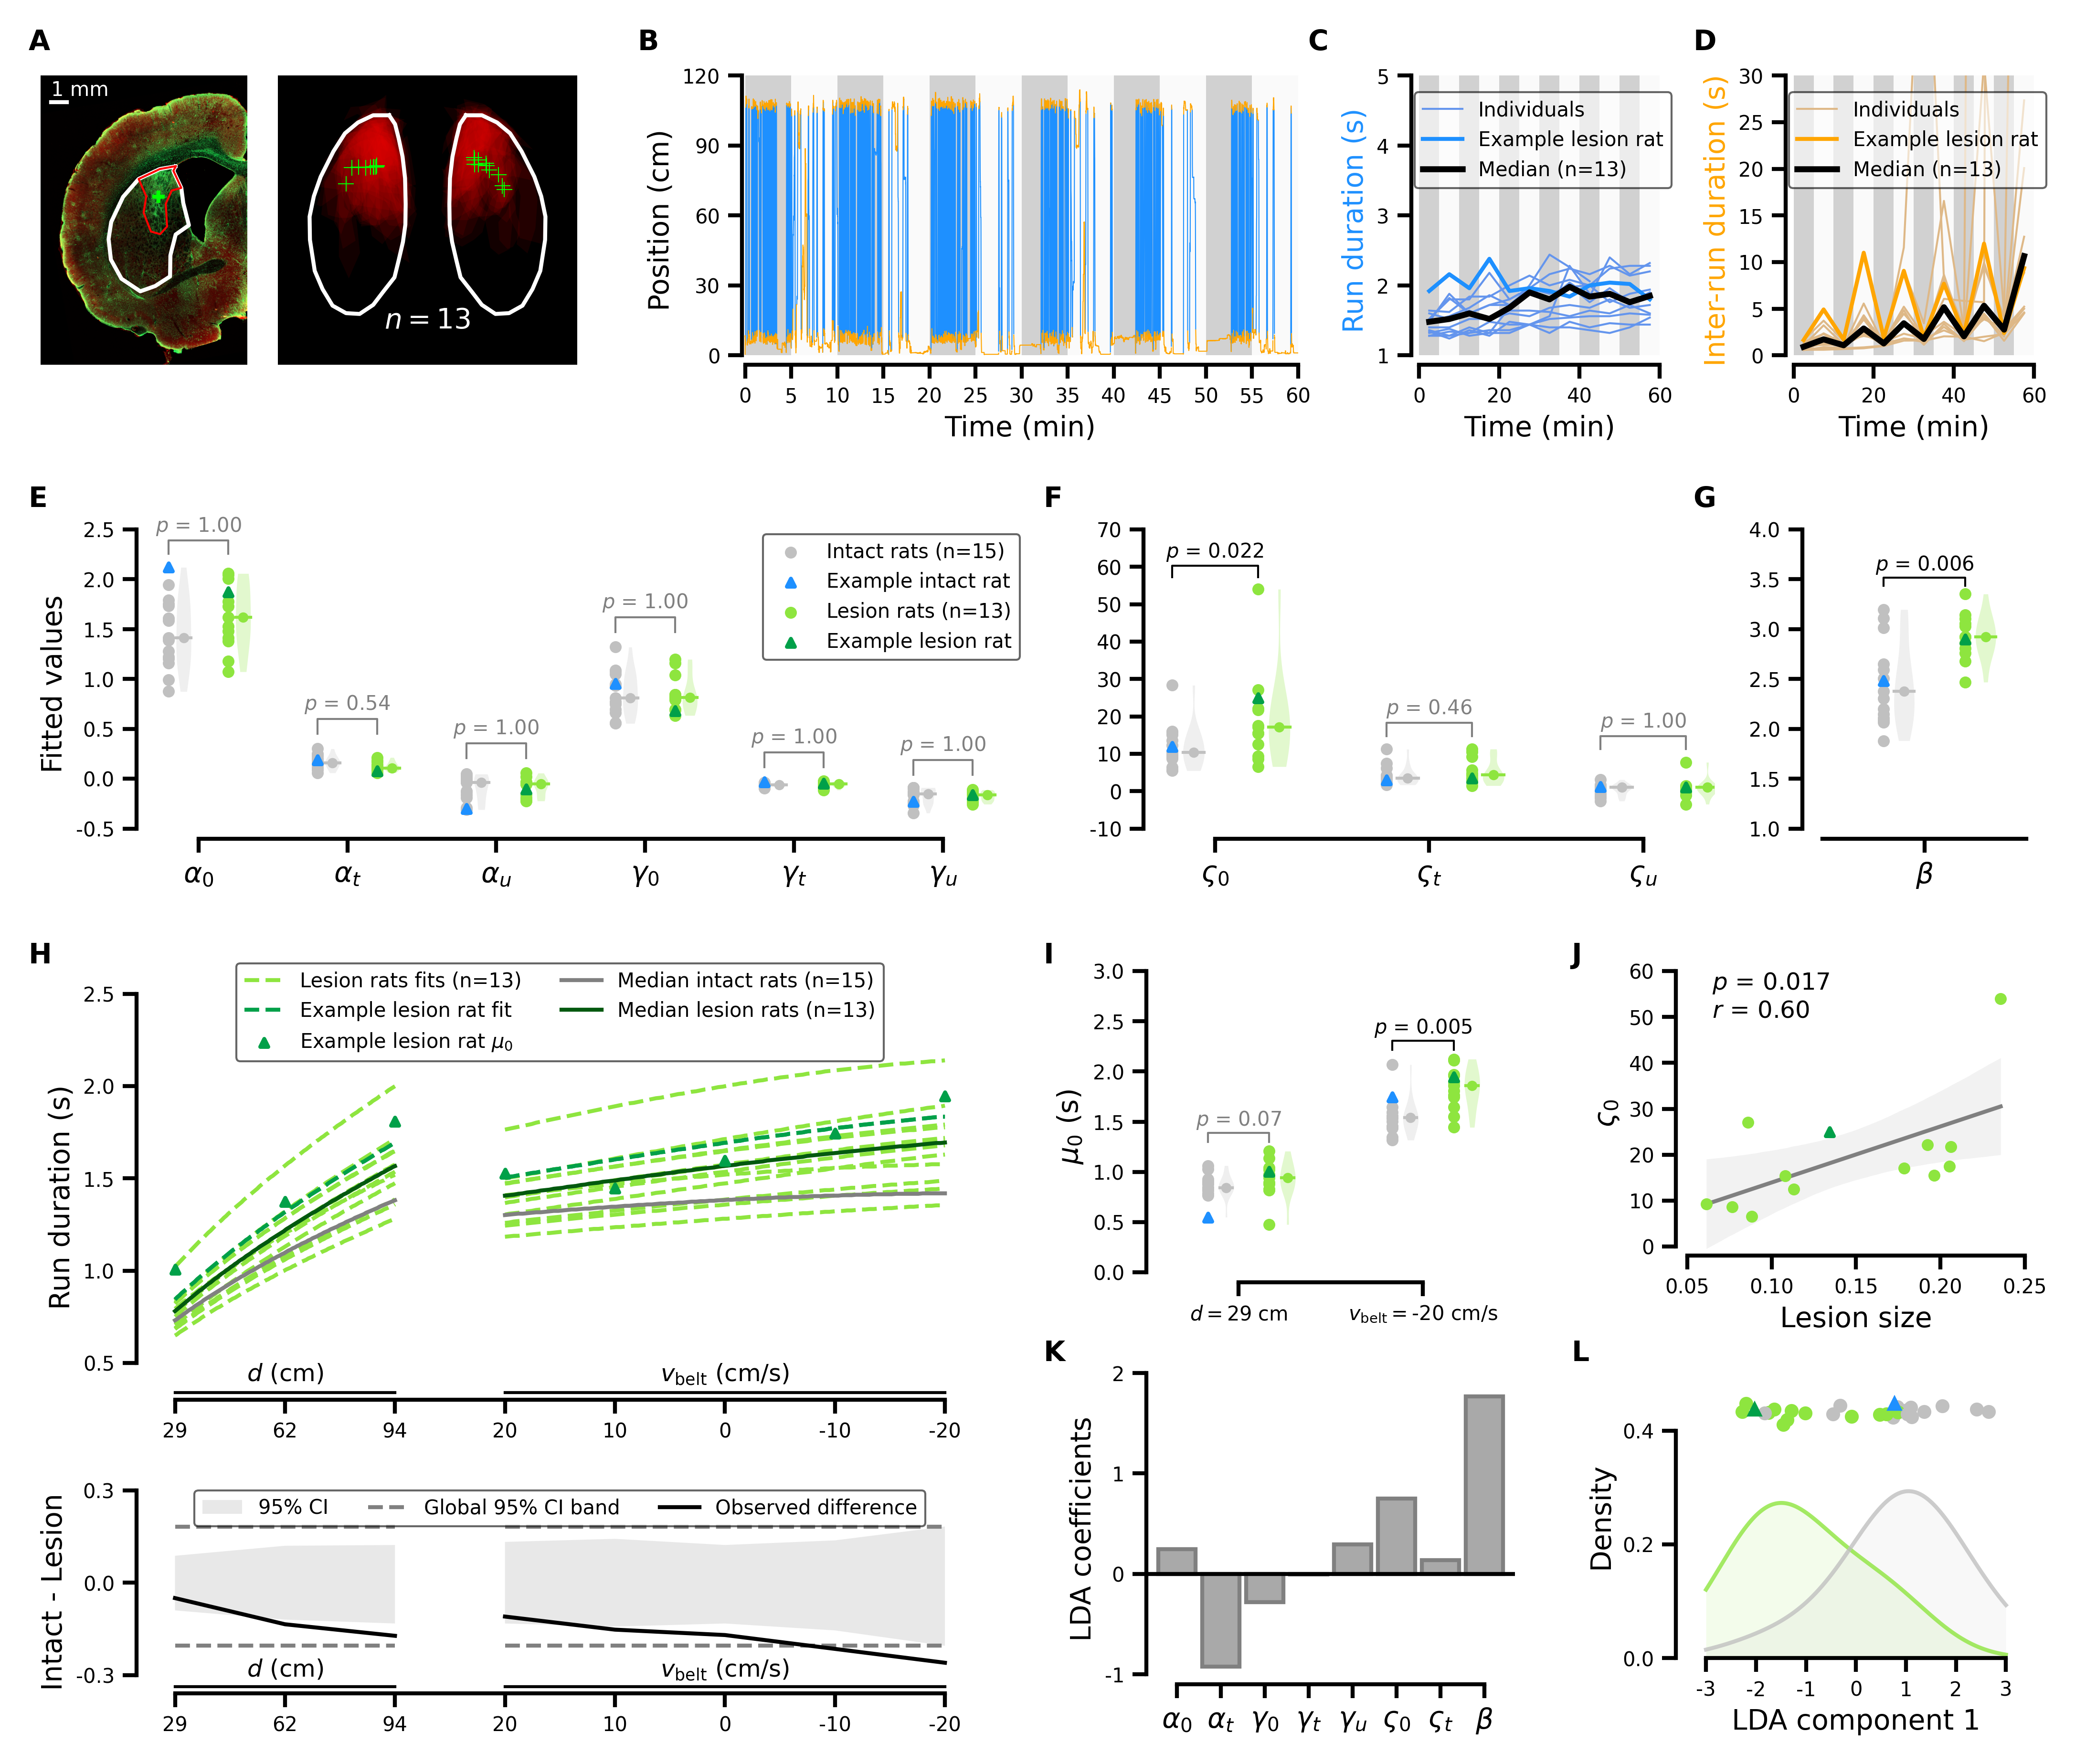

In [41]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(15)), dpi=600, constrained_layout=True, facecolor='w')

gs0 = fig.add_gridspec(5, 1 , height_ratios=[4, .5, 4, .5, 8])

row1 = gs0[0].subgridspec(1, 6, width_ratios=[2.5, 3.5, .1, 6.5, 3, 3])
ax_histology = plt.subplot(row1[0, 0])
ax_lesion = plt.subplot(row1[0, 1])
ax_track = plt.subplot(row1[0, 3])
ax_crossing = plt.subplot(row1[0, 4])
ax_idle = plt.subplot(row1[0, 5])


row2 = gs0[2].subgridspec(1, 4, width_ratios=[5.325, .1, 3.5, 1.5])
idle_time_ax = plt.subplot(row2[0, 0])
crossing_time_ax = plt.subplot(row2[0, 2])
power_ax = plt.subplot(row2[0, 3])


row3 = gs0[4].subgridspec(1, 5, width_ratios=[2, .1, 1, .1, 1])

left = row3[0].subgridspec(2, 2, height_ratios=[2, 1])
ax_indiv_D = plt.subplot(left[0, :])
ax_group_D = plt.subplot(left[1, :])

middle = row3[2].subgridspec(2, 2)
ax_lesioneffect = plt.subplot(middle[0, :])
LDA_params = plt.subplot(middle[1, :])


right = row3[4].subgridspec(2, 1)
ax_corr = plt.subplot(right[0])
LDA_rats = plt.subplot(right[1])



Figure_6A(ax=ax_histology)
Figure_6B(ax=ax_lesion)
Figure1B(ax=ax_track)
Figure1F(ax=ax_crossing)
Figure1G(ax=ax_idle)

Figure6X(ax=idle_time_ax)
Figure6XX(ax=crossing_time_ax)
Figure6XXX(ax=power_ax)

Figure3FF(ax=ax_indiv_D)
plot_permutation(permuted_diffs, observed_diff, p_values, ax=ax_group_D)

Figure6_G_(ax=ax_lesioneffect)
Figure6_I(ax=ax_corr)

Figure6Y(ax=LDA_params)
Figure6Z(ax=LDA_rats)


legend = fig.add_axes([.42, .675, .01, .01])
dummy_legend(ax=legend)

handles, labels = ax_crossing.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.746, .95), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w', 
                            # title='Legend for all figures:     ', title_fontsize=5
                            ).get_frame().set_linewidth(.5)

handles, labels = ax_idle.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.9305, .95), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w', 
                            # title='Legend for all figures:     ', title_fontsize=5
                            ).get_frame().set_linewidth(.5)


figuresLabels={"A":[0.00, 1.00], "B":[0.30, 1.00], "C":[0.63, 1.00], "D":[0.82, 1.00],
               "E":[0.00, 0.73],                   "F":[0.5, 0.73], "G":[0.82, 0.73], 
               "H":[0.0, 0.46],                    "I":[0.5, 0.46], "J":[0.76, 0.46], 
                                                   "K":[0.5, 0.225], "L":[0.76, 0.225], }

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1], label, figure=fig, 
            weight='bold', fontsize=7, ha='left', va='bottom')

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_6.pdf", facecolor='w', 
            edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("/home/david/Desktop/code/figures_paper/Figure_6.svg", facecolor='w', 
            edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

In [40]:
<<<<

SyntaxError: invalid syntax (1700047511.py, line 1)

Text(0, 0.5, 'Epsilon_0')

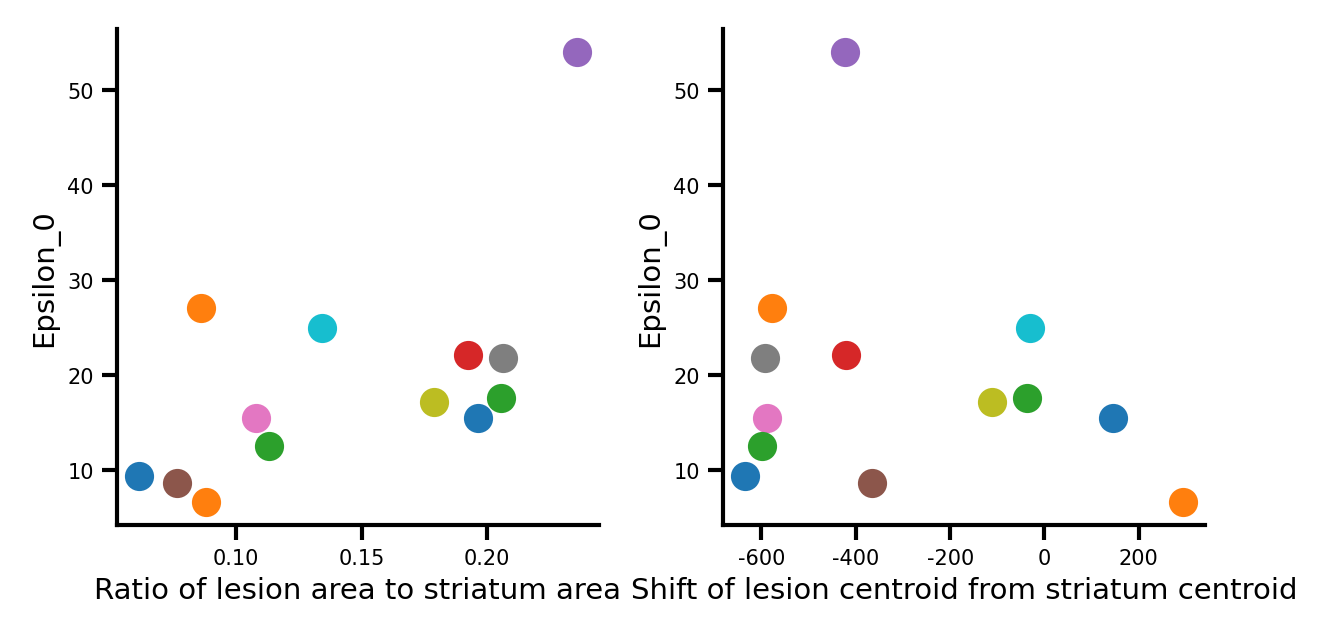

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
for animal in lesioned:
    axs[0].scatter(lesion_area[animal], effort_sensitivity_0[animal], label=animal+brainstatus[animal])
    axs[1].scatter(lesion_pos[animal], effort_sensitivity_0[animal], label=animal+brainstatus[animal])

axs[0].set_xlabel('Ratio of lesion area to striatum area')
axs[0].set_ylabel('Epsilon_0')
# axs[0].legend()
# # axs[0].set_ylim(0, 60)

axs[1].set_xlabel('Shift of lesion centroid from striatum centroid')
axs[1].set_ylabel('Epsilon_0')
# axs[1].legend()
# axs[1].set_ylim(0, 60)

(0.0, 0.25)

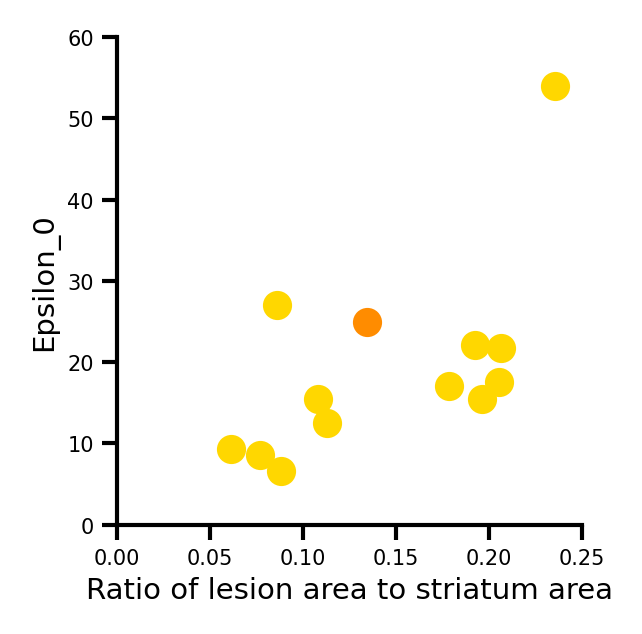

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))
for animal in lesioned:
    ax.scatter(lesion_area[animal], effort_sensitivity_0[animal], label=animal, color=rat_markers[animal][0])
    # ax.scatter(0, effort_sensitivity_0[animal], label=animal, color=rat_markers[animal][0])


ax.set_xlabel('Ratio of lesion area to striatum area')
ax.set_ylabel('Epsilon_0')
# ax.legend()
ax.set_ylim(0, 60)
ax.set_xlim(0, 0.25)

epsilon_0 corr: 0.60, p: 0.0310
epsilon_t corr: 0.32, p: 0.2876
epsilon_R corr: 0.21, p: 0.4811
alpha_0 corr: 0.32, p: 0.2822
alpha_t corr: -0.51, p: 0.0762
alpha_R corr: 0.08, p: 0.7975
gamma_0 corr: -0.45, p: 0.1251
gamma_t corr: 0.21, p: 0.4847
gamma_R corr: 0.23, p: 0.4518
mu_0 corr: 0.73, p: 0.0045
mu_t corr: -0.07, p: 0.8118
mu_R corr: 0.45, p: 0.1191
sigma_0 corr: 0.75, p: 0.0033
sigma_t corr: -0.22, p: 0.4802
sigma_R corr: 0.19, p: 0.5334


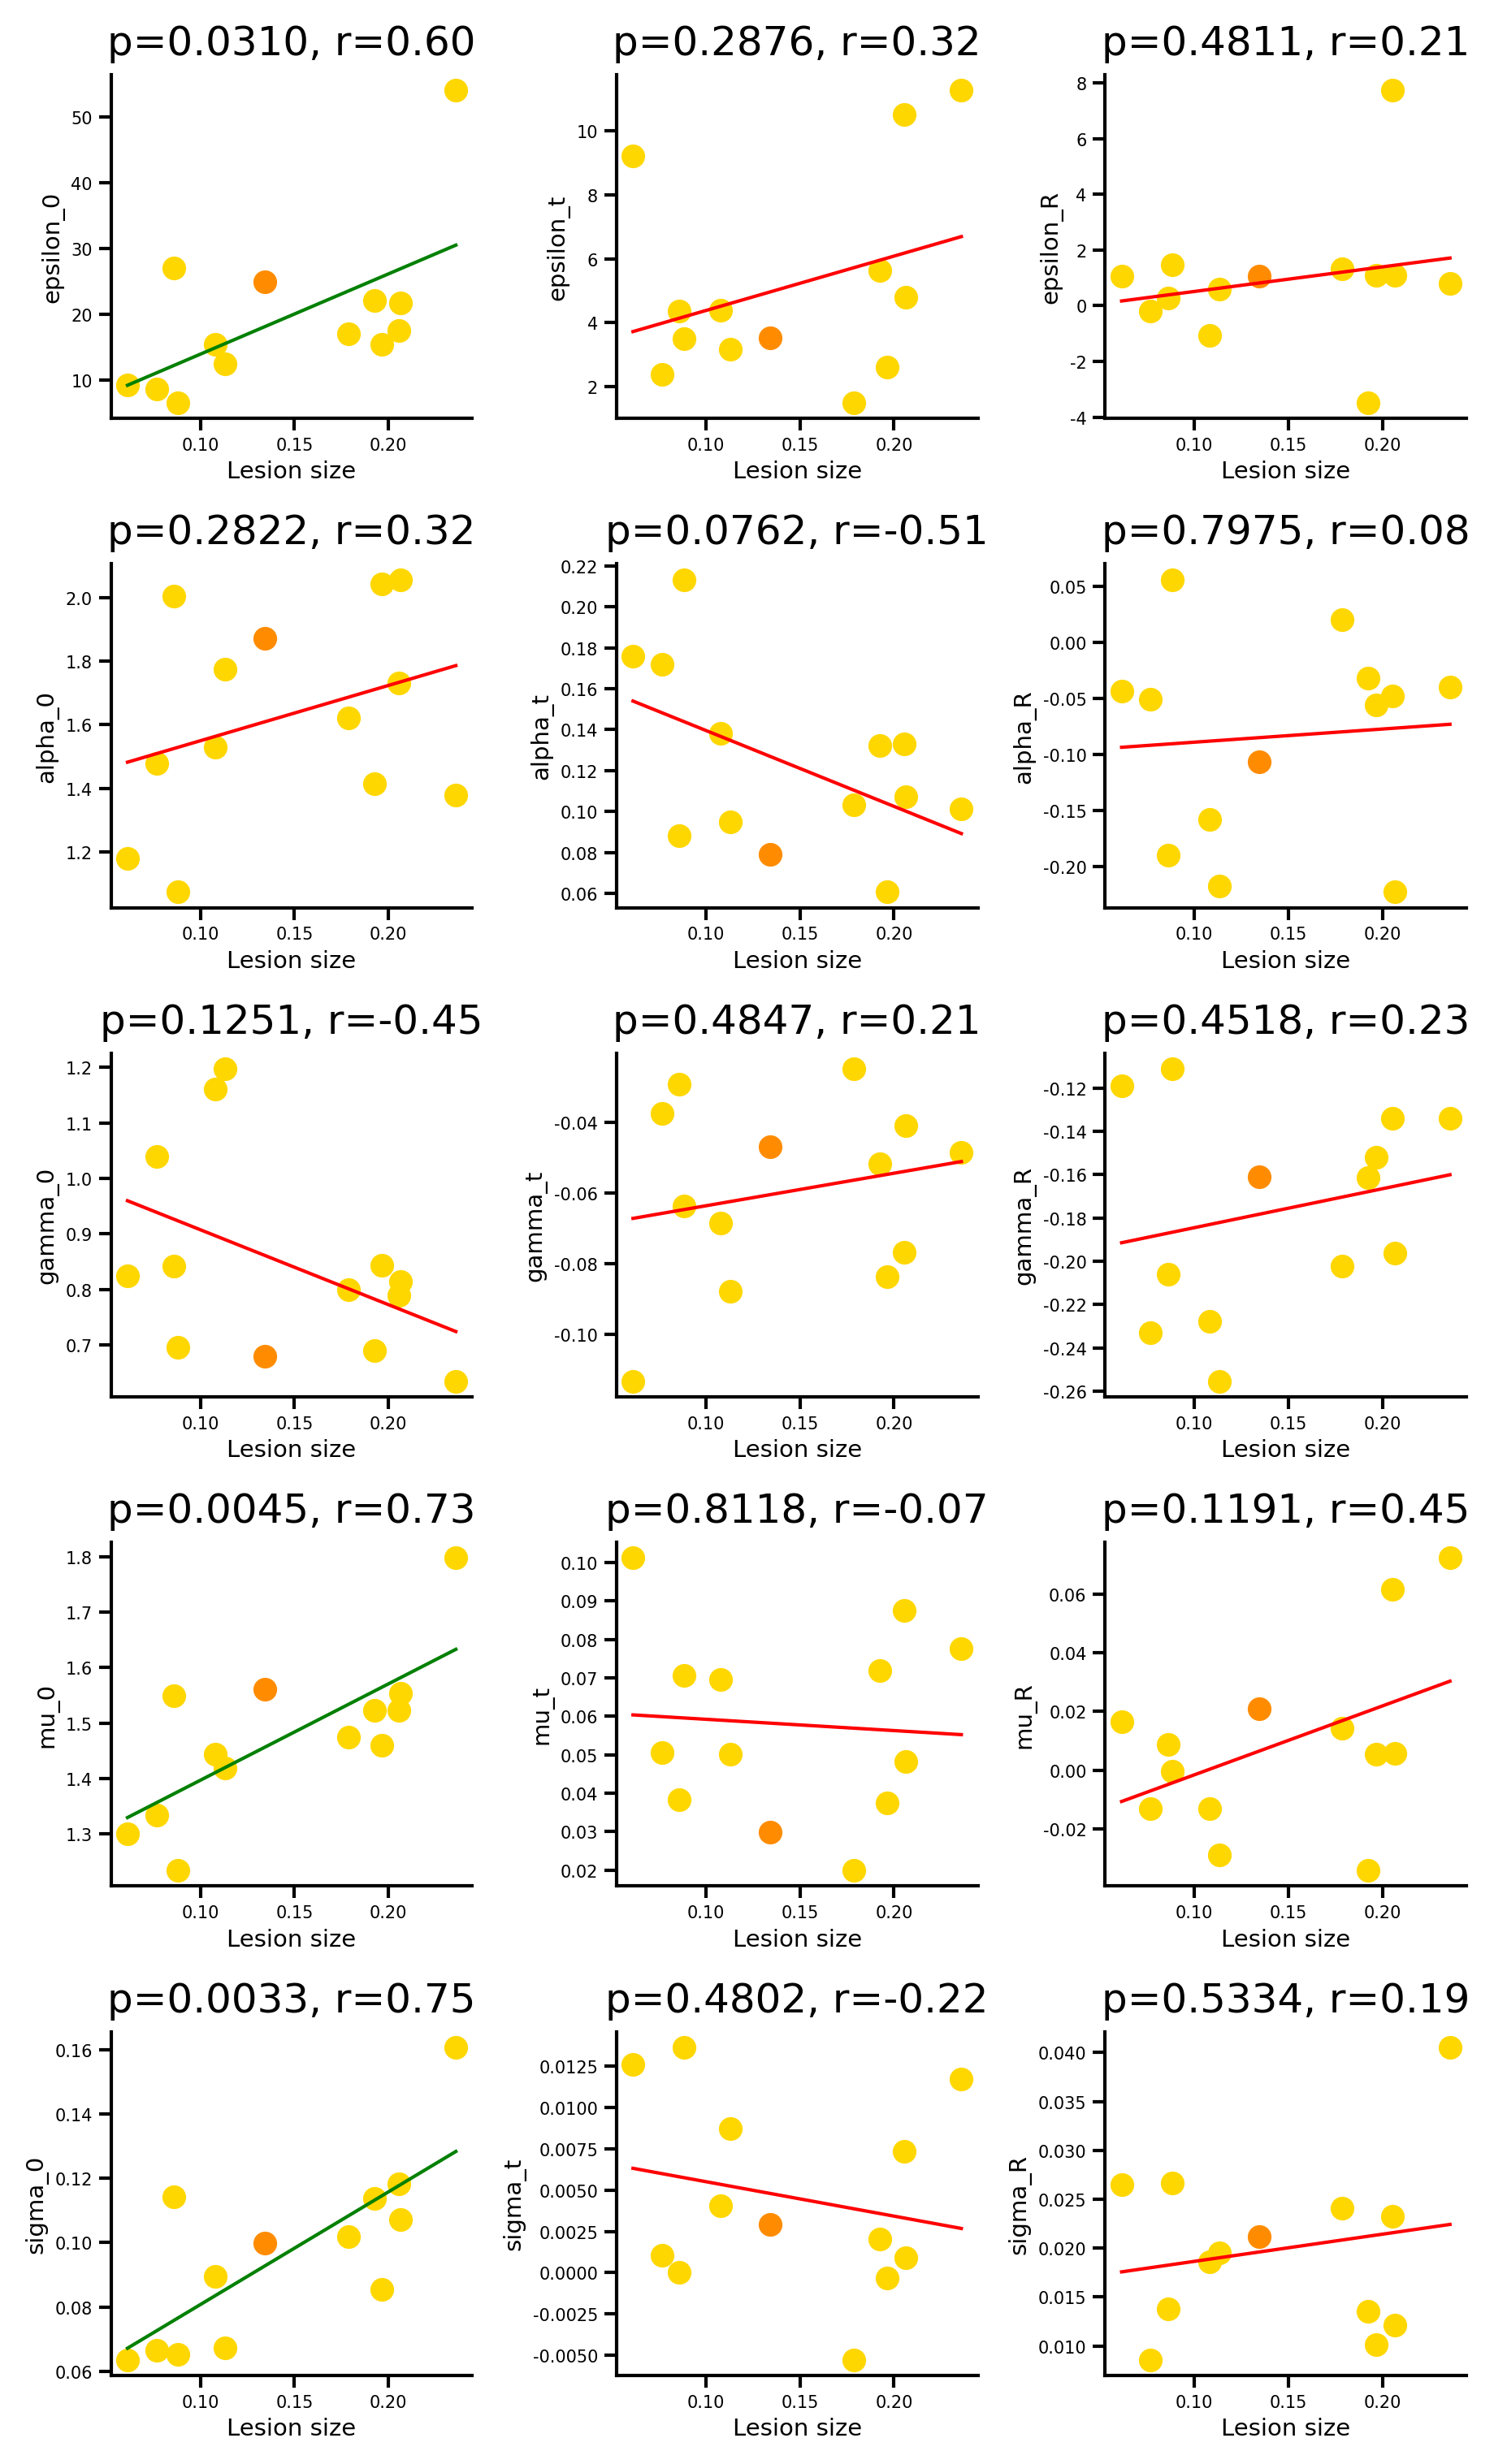

In [ ]:
effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, power = pickle.load(open('picklejar/effort_sensitivity_fit.p', 'rb'))
alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
alpha_0 = {animal: np.median([alpha_0[animal][cond] for cond in conds]) for animal in lesioned}
alpha_t = {animal: np.median([alpha_t[animal][cond] for cond in conds]) for animal in lesioned}
alpha_u = {animal: np.median([alpha_u[animal][cond] for cond in conds]) for animal in lesioned}
gamma_0 = {animal: np.median([gamma_0[animal][cond] for cond in conds]) for animal in lesioned}
gamma_t = {animal: np.median([gamma_t[animal][cond] for cond in conds]) for animal in lesioned}
gamma_u = {animal: np.median([gamma_u[animal][cond] for cond in conds]) for animal in lesioned}
mu_0 = {animal: np.median([mu_0[animal][cond] for cond in conds]) for animal in lesioned}
mu_t = {animal: np.median([mu_t[animal][cond] for cond in conds]) for animal in lesioned}
mu_u = {animal: np.median([mu_u[animal][cond] for cond in conds]) for animal in lesioned}
sigma_0 = {animal: np.median([sigma_0[animal][cond] for cond in conds]) for animal in lesioned}
sigma_t = {animal: np.median([sigma_t[animal][cond] for cond in conds]) for animal in lesioned}
sigma_u = {animal: np.median([sigma_u[animal][cond] for cond in conds]) for animal in lesioned}

vars = [effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u]
names = ['effort_sensitivity_0', 'effort_sensitivity_t', 'effort_sensitivity_u', 'alpha_0', 'alpha_t', 'alpha_u', 'gamma_0', 'gamma_t', 'gamma_u', 'mu_0', 'mu_t', 'mu_u', 'sigma_0', 'sigma_t', 'sigma_u']

fig, axs = plt.subplots(5, 3, figsize=(6, 10))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_area[animal], var[animal], label=animal, color=rat_markers[animal][0])
        x.append(lesion_area[animal])
        y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion size')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')




Observed Slope: 121.98239718163416
p-value for Slope: 0.0147
r-value: nan
epsilon_0 corr: 0.60, p: 0.0310
epsilon_t corr: 0.32, p: 0.2876


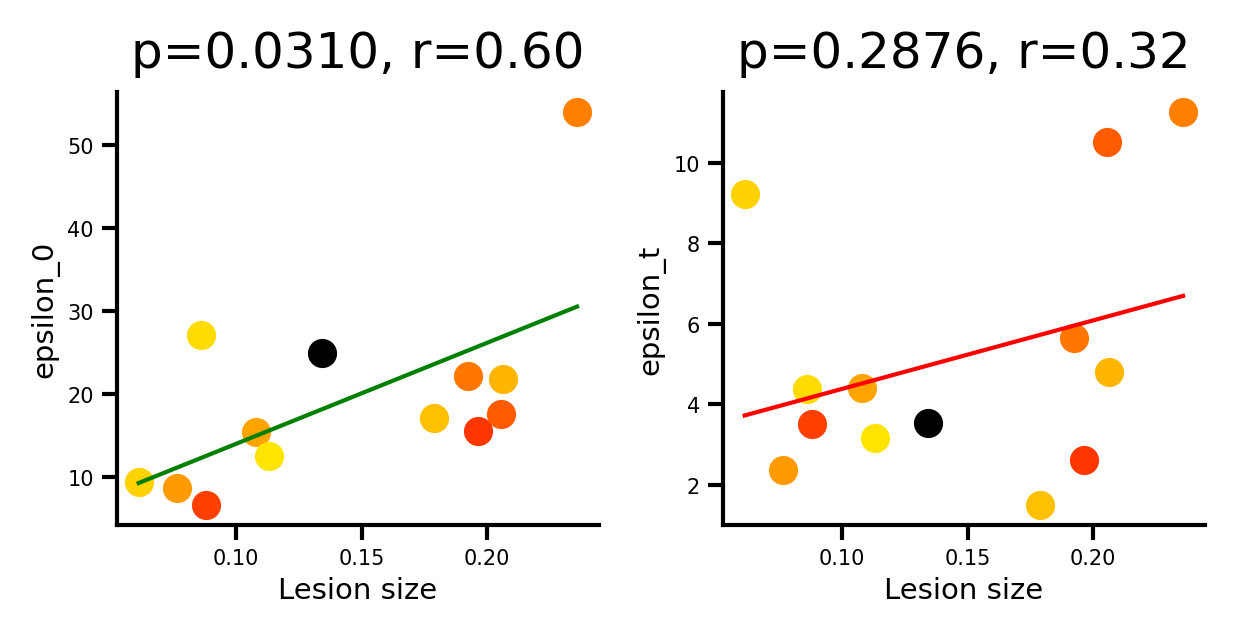

In [ ]:
import numpy as np
from scipy.stats import linregress

x = np.array([lesion_area[animal] for animal in lesioned])
y = np.array([effort_sensitivity_0[animal] for animal in lesioned])

# Number of bootstraps and shuffles
n_bootstraps = 10000
n_shuffles = 10000

# Store the results of the slope and intercept
bootstrap_slopes = np.zeros(n_bootstraps)
bootstrap_intercepts = np.zeros(n_bootstraps)

# Perform bootstrap resampling
for i in range(n_bootstraps):
    # Randomly sample with replacement
    indices = np.random.choice(len(x), len(x), replace=True)
    x_bootstrap = x[indices]
    y_bootstrap = y[indices]
    
    # Fit a linear regression model to the resampled data
    slope, intercept, _, _, _ = linregress(x_bootstrap, y_bootstrap)
    bootstrap_slopes[i] = slope
    bootstrap_intercepts[i] = intercept

# Compute the observed slope and intercept
observed_slope, observed_intercept, _, _, _ = linregress(x, y)

# Compute p-values through shuffling
shuffle_slopes = np.zeros(n_shuffles)

for i in range(n_shuffles):
    # Shuffle the y-values while keeping the x-values the same
    np.random.shuffle(y)
    
    # Fit a linear regression model to the shuffled data
    slope, _, _, _, _ = linregress(x, y)
    shuffle_slopes[i] = slope

# Calculate p-values
p_value_slope = (np.abs(shuffle_slopes) >= np.abs(observed_slope)).mean()
r_value = np.sqrt(np.corrcoef(x, y)[0, 1])

print("Observed Slope:", observed_slope)
print("p-value for Slope:", p_value_slope)
print("r-value:", r_value)

fig, axs = plt.subplots(1, 2, figsize=(4, 2))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_area[animal], var[animal], label=animal, color=rat_markers[animal][0])
        x.append(lesion_area[animal])
        y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion size')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')


In [ ]:

vars = [k, effort,]
names = ['k', 'effort']

fig, axs = plt.subplots(1, 2, figsize=(4, 2))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_area[animal], var[animal], label=animal, color=rat_markers[animal][0])
        x.append(lesion_area[animal])
        y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion size')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')




NameError: name 'k' is not defined

In [ ]:
k, effort = pickle.load(open('picklejar/TESTFREEeffort_fit.p', 'rb'))

k corr: -0.18, p: 0.5586
effort corr: -0.33, p: 0.2754


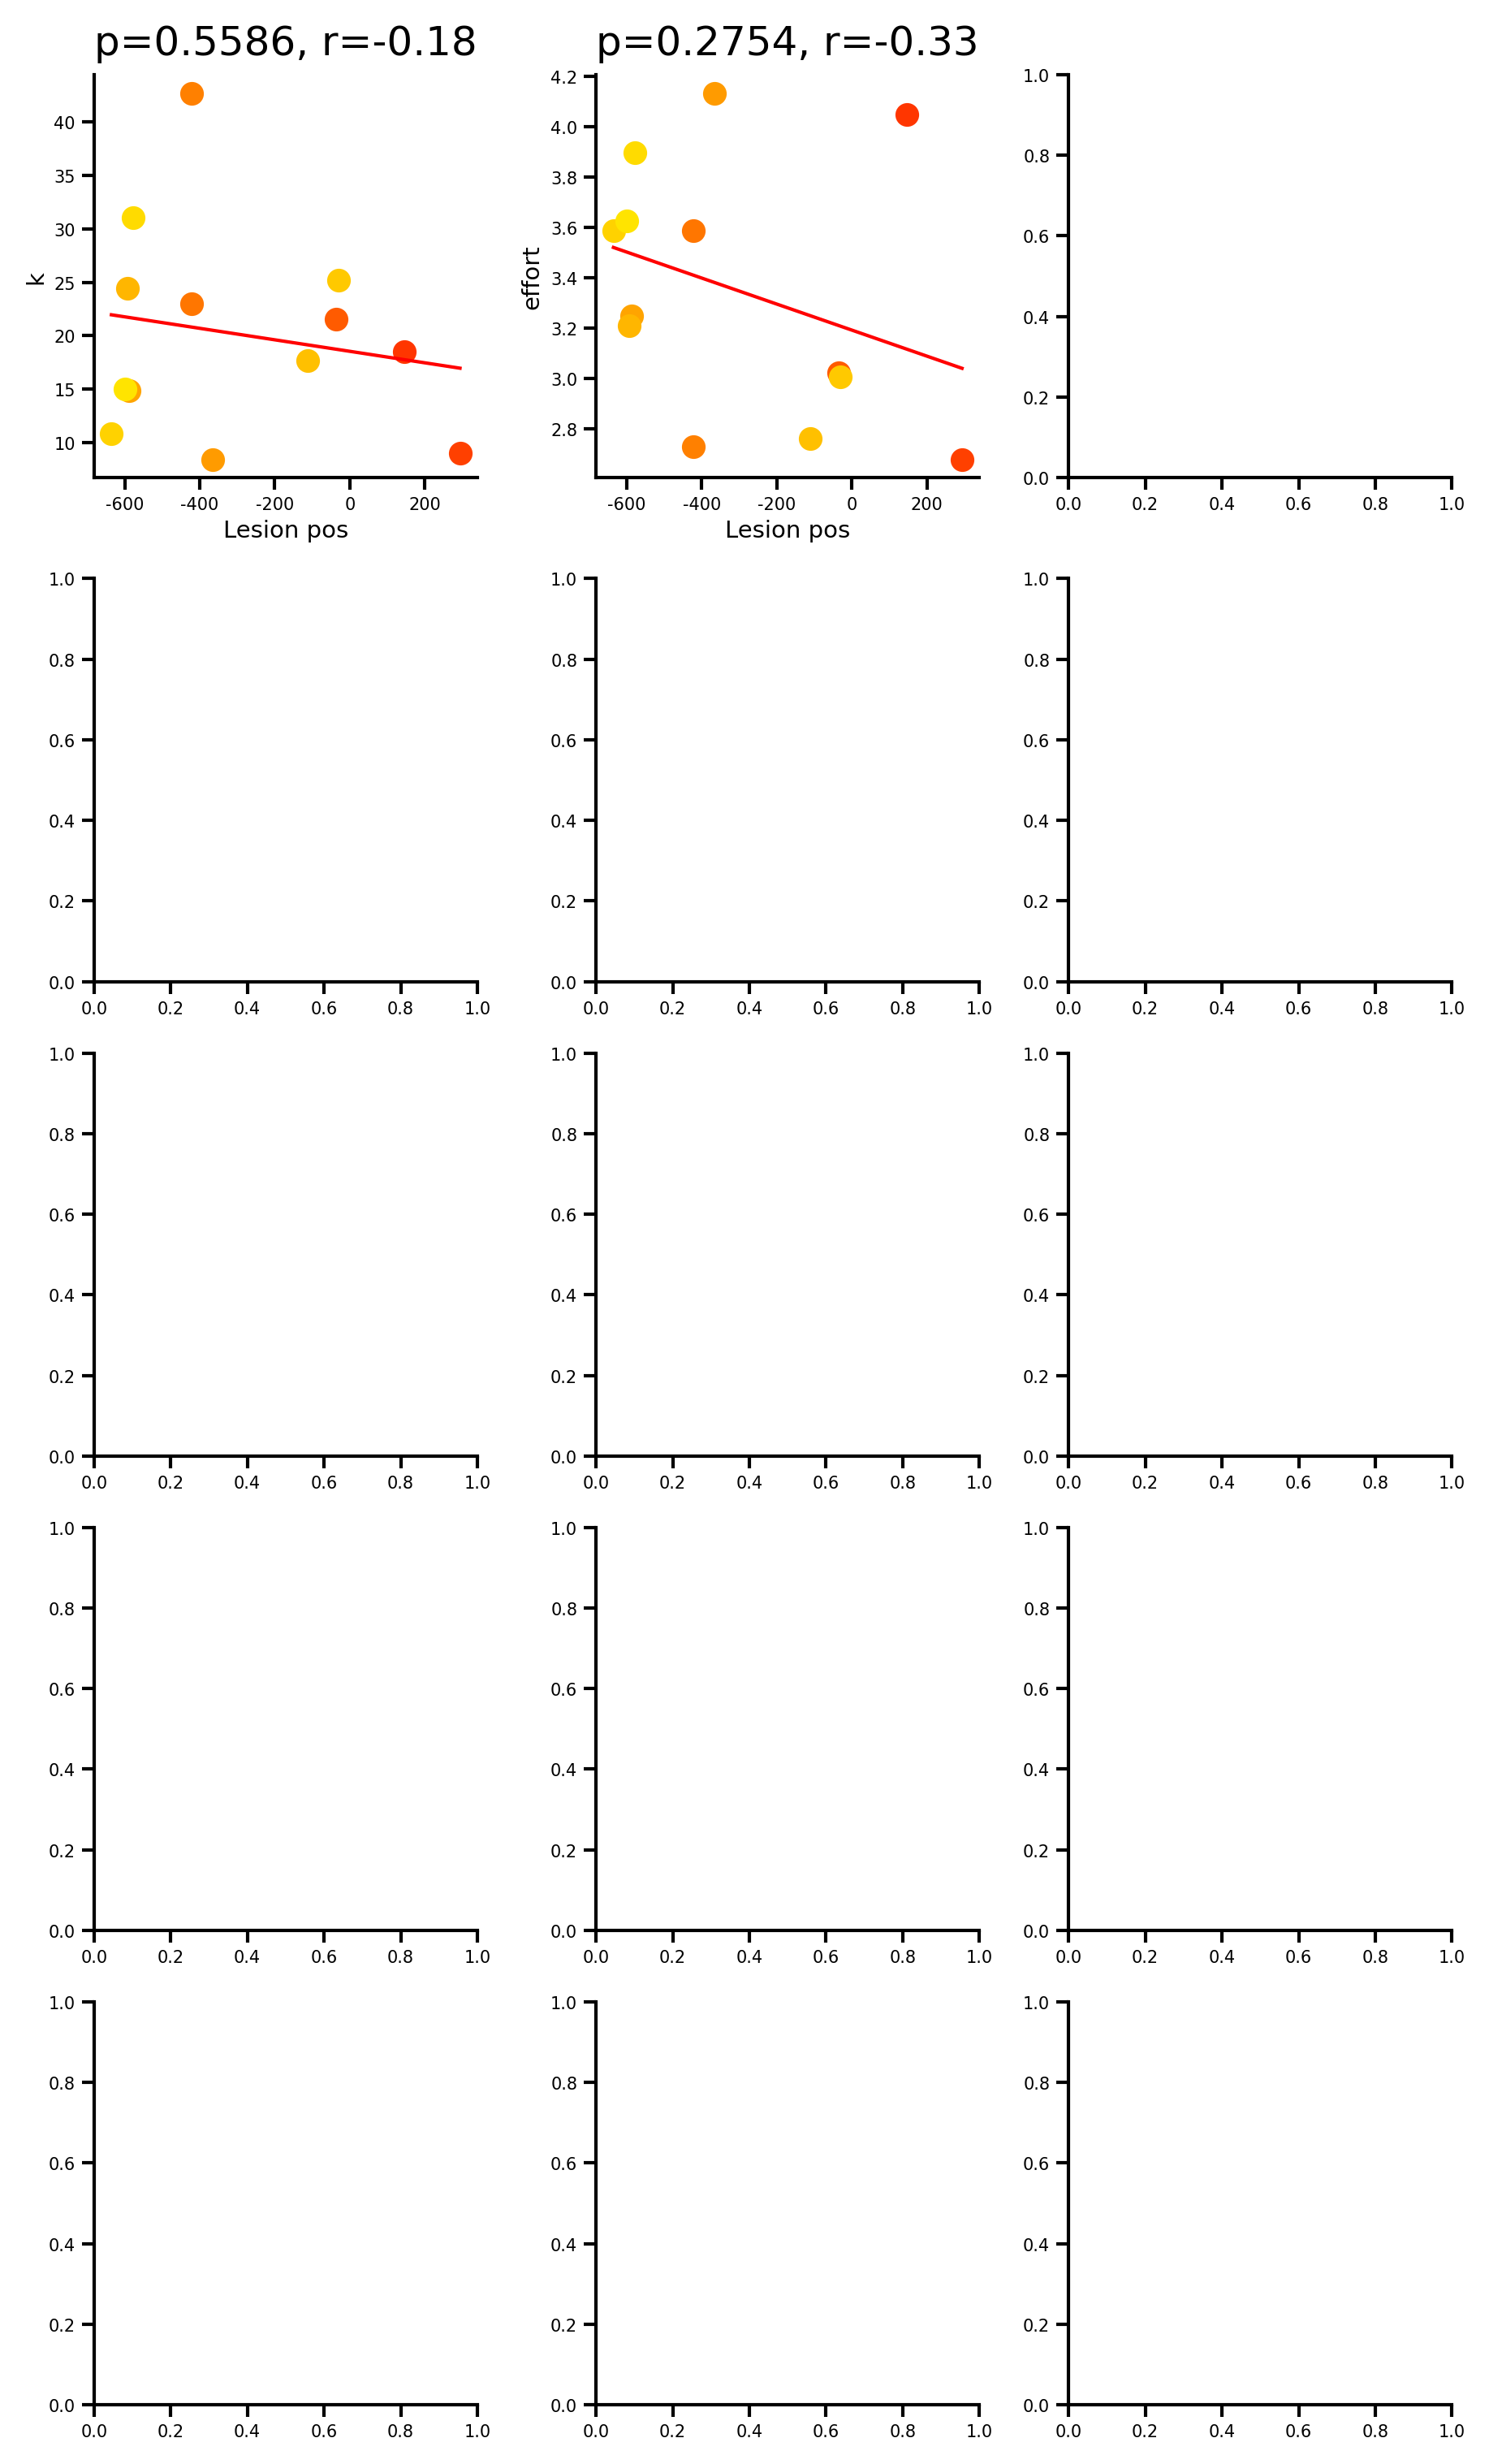

In [ ]:

fig, axs = plt.subplots(5, 3, figsize=(6, 10))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in lesioned:
        try:
            ax.scatter(lesion_pos[animal], var[animal], label=animal, color=rat_markers[animal][0])
            x.append(lesion_pos[animal])
            y.append(var[animal])
        
        except KeyError:
            pass

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion pos')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')




# Fig params comparison intact lesion

In [ ]:
alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
vars = [alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u]
names = ['alpha_0', 'alpha_t', 'alpha_u', 'gamma_0', 'gamma_t', 'gamma_u', 'mu_0', 'mu_t', 'mu_u', 'sigma_0', 'sigma_t', 'sigma_u']


import scipy.stats as stats

def compare_intact_lesion(var):
    group1 = [var[animal][cond] for cond in conds for animal in animalList if brainstatus[animal] == 'normal']
    group2 = [var[animal][cond] for cond in conds for animal in animalList if brainstatus[animal] != 'normal']
    print(np.mean(group1), np.mean(group2))
    # Check normality
    _, p_value_group1 = stats.shapiro(group1)
    _, p_value_group2 = stats.shapiro(group2)

    alpha = 0.05 
    if p_value_group1 < alpha or p_value_group2 < alpha:
        u_stat, p_value = stats.mannwhitneyu(group1, group2)

        if p_value < alpha:
            print("diff (MWU)", p_value)
        else:
            print("NO diff (MWU)", p_value)

    else:
        t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)

        if p_value < alpha:
            print("diff (ttest)", p_value)
        else:
            print("NO diff (ttest)", p_value)

    # perm = exact_mc_perm_test(group1, group2)
    # print("diff (perm)", perm)

for var, name in zip(vars, names):
    print(name)
    compare_intact_lesion(var)
    print()

alpha_0
1.4022579363810512 1.5715178272937143
diff (ttest) 0.003344693255320957

alpha_t
0.17059440171827886 0.1244992992130872
diff (MWU) 3.3549750257642545e-05

alpha_R
-0.0782952478635868 -0.07539120958890806
NO diff (MWU) 0.897197142303075

gamma_0
0.8560508230596967 0.8559474028738099
NO diff (ttest) 0.997696452394409

gamma_t
-0.06173284007193987 -0.06004197427385376
NO diff (MWU) 0.49577188907824876

gamma_R
-0.17408378712985187 -0.1755199450203762
NO diff (MWU) 0.4388223029870496

mu_0
1.309899930719816 1.4466426680737698
diff (MWU) 0.00013274819118357878

mu_t
0.06368068889282383 0.057113740030602225
NO diff (MWU) 0.06122170303428324

mu_R
0.00046076186655258556 0.007297906634715138
NO diff (MWU) 0.30862167000791174

sigma_0
0.08610361763627843 0.0979926276514263
diff (MWU) 0.016624717360482474

sigma_t
0.007531110901098182 0.004976409170782025
NO diff (MWU) 0.05705365330721336

sigma_R
0.024247515523409556 0.022242251256177754
NO diff (MWU) 0.05841596484084364



In [ ]:
effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, power = pickle.load(open('picklejar/effort_sensitivity_fit.p', 'rb'))
alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
alpha_0 = {animal: np.median([alpha_0[animal][cond] for cond in conds]) for animal in animalList}
alpha_t = {animal: np.median([alpha_t[animal][cond] for cond in conds]) for animal in animalList}
alpha_u = {animal: np.median([alpha_u[animal][cond] for cond in conds]) for animal in animalList}
gamma_0 = {animal: np.median([gamma_0[animal][cond] for cond in conds]) for animal in animalList}
gamma_t = {animal: np.median([gamma_t[animal][cond] for cond in conds]) for animal in animalList}
gamma_u = {animal: np.median([gamma_u[animal][cond] for cond in conds]) for animal in animalList}
mu_0 = {animal: np.median([mu_0[animal][cond] for cond in conds]) for animal in animalList}
mu_t = {animal: np.median([mu_t[animal][cond] for cond in conds]) for animal in animalList}
mu_u = {animal: np.median([mu_u[animal][cond] for cond in conds]) for animal in animalList}
sigma_0 = {animal: np.median([sigma_0[animal][cond] for cond in conds]) for animal in animalList}
sigma_t = {animal: np.median([sigma_t[animal][cond] for cond in conds]) for animal in animalList}
sigma_u = {animal: np.median([sigma_u[animal][cond] for cond in conds]) for animal in animalList}

vars = [effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u]
names = ['effort_sensitivity_0', 'effort_sensitivity_t', 'effort_sensitivity_u', 'alpha_0', 'alpha_t', 'alpha_u', 'gamma_0', 'gamma_t', 'gamma_u', 'mu_0', 'mu_t', 'mu_u', 'sigma_0', 'sigma_t', 'sigma_u']


In [ ]:
# effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u = pickle.load(open('picklejar/effort_sensitivity_fit.p', 'rb'))
# alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

# conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
# alpha_0 = {animal: np.mean([alpha_0[animal][cond] for cond in conds]) for animal in animalList}
# alpha_t = {animal: np.mean([alpha_t[animal][cond] for cond in conds]) for animal in animalList}
# alpha_u = {animal: np.mean([alpha_u[animal][cond] for cond in conds]) for animal in animalList}
# gamma_0 = {animal: np.mean([gamma_0[animal][cond] for cond in conds]) for animal in animalList}
# gamma_t = {animal: np.mean([gamma_t[animal][cond] for cond in conds]) for animal in animalList}
# gamma_u = {animal: np.mean([gamma_u[animal][cond] for cond in conds]) for animal in animalList}
# mu_0 = {animal: np.mean([mu_0[animal][cond] for cond in conds]) for animal in animalList}
# mu_t = {animal: np.mean([mu_t[animal][cond] for cond in conds]) for animal in animalList}
# mu_u = {animal: np.mean([mu_u[animal][cond] for cond in conds]) for animal in animalList}
# sigma_0 = {animal: np.mean([sigma_0[animal][cond] for cond in conds]) for animal in animalList}
# sigma_t = {animal: np.mean([sigma_t[animal][cond] for cond in conds]) for animal in animalList}
# sigma_u = {animal: np.mean([sigma_u[animal][cond] for cond in conds]) for animal in animalList}

# vars = [effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u]
# names = ['effort_sensitivity_0', 'effort_sensitivity_t', 'effort_sensitivity_u', 'alpha_0', 'alpha_t', 'alpha_u', 'gamma_0', 'gamma_t', 'gamma_u', 'mu_0', 'mu_t', 'mu_u', 'sigma_0', 'sigma_t', 'sigma_u']


epsilon_0 0.024
epsilon_t 0.3468
epsilon_R 0.6425


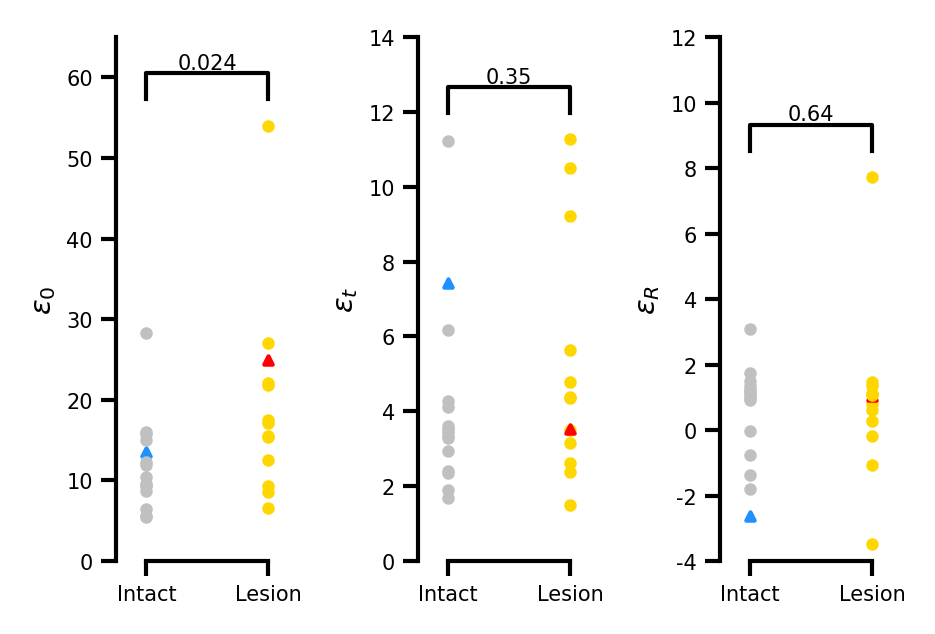

In [ ]:
def Figure6_A(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(effort_sensitivity_0[animal])
            x = 0
        else:
            lesion.append(effort_sensitivity_0[animal])
            x = 1
        ax.scatter(x, effort_sensitivity_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 65)
    ax.set_ylabel(r'$\varsigma_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("effort_sensitivity_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_B(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(effort_sensitivity_t[animal])
            x = 0
        else:
            lesion.append(effort_sensitivity_t[animal])
            x = 1
        ax.scatter(x, effort_sensitivity_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 14)
    ax.set_ylabel(r'$\varsigma_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("effort_sensitivity_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_C(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(effort_sensitivity_u[animal])
            x = 0
        else:
            lesion.append(effort_sensitivity_u[animal])
            x = 1
        ax.scatter(x, effort_sensitivity_u[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-4, 12)
    ax.set_ylabel(r'$\varsigma_u$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("effort_sensitivity_u", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_A(axs[0])
Figure6_B(axs[1])
Figure6_C(axs[2])

alpha_0 0.2416
alpha_t 0.049
alpha_t MWU 0.05893484040214102
alpha_R 0.71


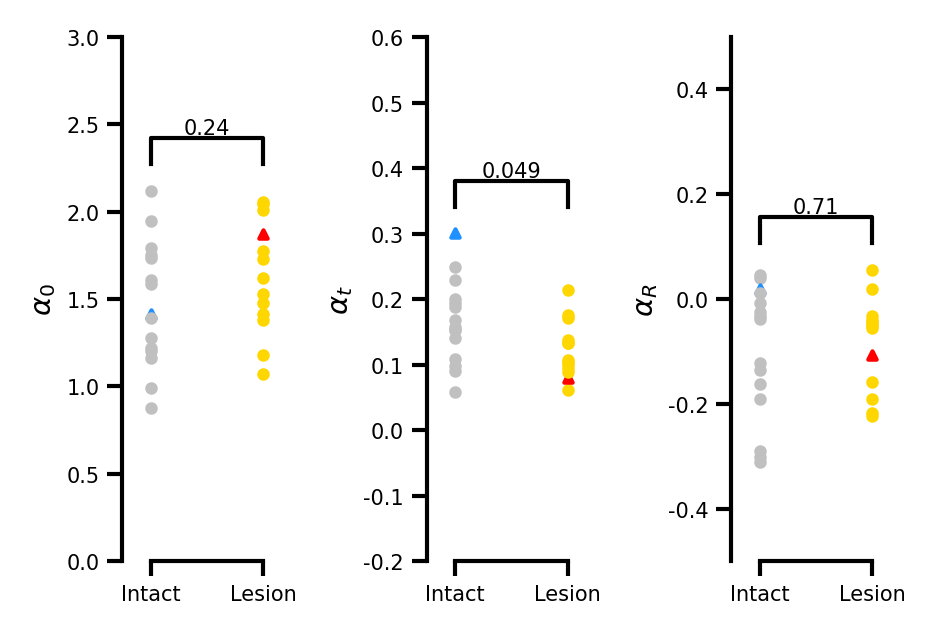

In [ ]:
def Figure6_D(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(alpha_0[animal])
            x = 0
        else:
            lesion.append(alpha_0[animal])
            x = 1
        ax.scatter(x, alpha_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\alpha_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("alpha_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_E(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(alpha_t[animal])
            x = 0
        else:
            lesion.append(alpha_t[animal])
            x = 1
        ax.scatter(x, alpha_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.2, .6)
    ax.set_ylabel(r'$\alpha_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion, 10000)
    print("alpha_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

    t_stat, p_value = stats.mannwhitneyu(intact, lesion)
    print("alpha_t MWU", p_value)


def Figure6_F(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(alpha_u[animal])
            x = 0
        else:
            lesion.append(alpha_u[animal])
            x = 1
        ax.scatter(x, alpha_u[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.5, .5)
    ax.set_ylabel(r'$\alpha_u$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("alpha_u", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_D(axs[0])
Figure6_E(axs[1])
Figure6_F(axs[2])

gamma_0 0.8419
gamma_t 0.7307
gamma_R 0.9221


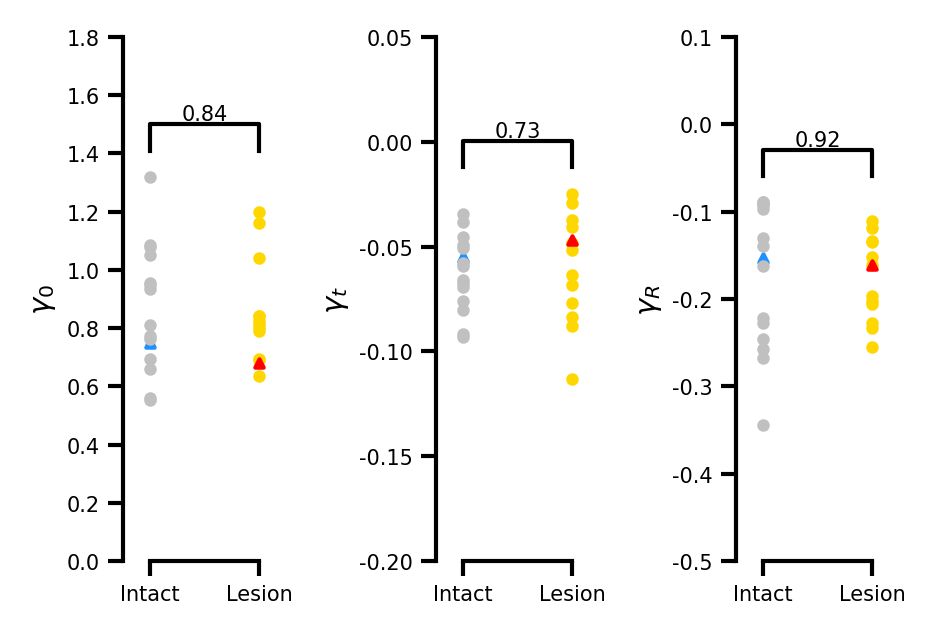

In [ ]:
def Figure6_G(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(gamma_0[animal])
            x = 0
        else:
            lesion.append(gamma_0[animal])
            x = 1
        ax.scatter(x, gamma_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.8)
    ax.set_ylabel(r'$\gamma_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("gamma_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)


def Figure6_H(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(gamma_t[animal])
            x = 0
        else:
            lesion.append(gamma_t[animal])
            x = 1
        ax.scatter(x, gamma_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.2, 0.05)
    ax.set_ylabel(r'$\gamma_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("gamma_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(gamma_u[animal])
            x = 0
        else:
            lesion.append(gamma_u[animal])
            x = 1
        ax.scatter(x, gamma_u[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, .1)
    ax.set_ylabel(r'$\gamma_u$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("gamma_u", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_G(axs[0])
Figure6_H(axs[1])
Figure6_I(axs[2])

mu_0 0.019
mu_t 0.7375
mu_R 0.3525


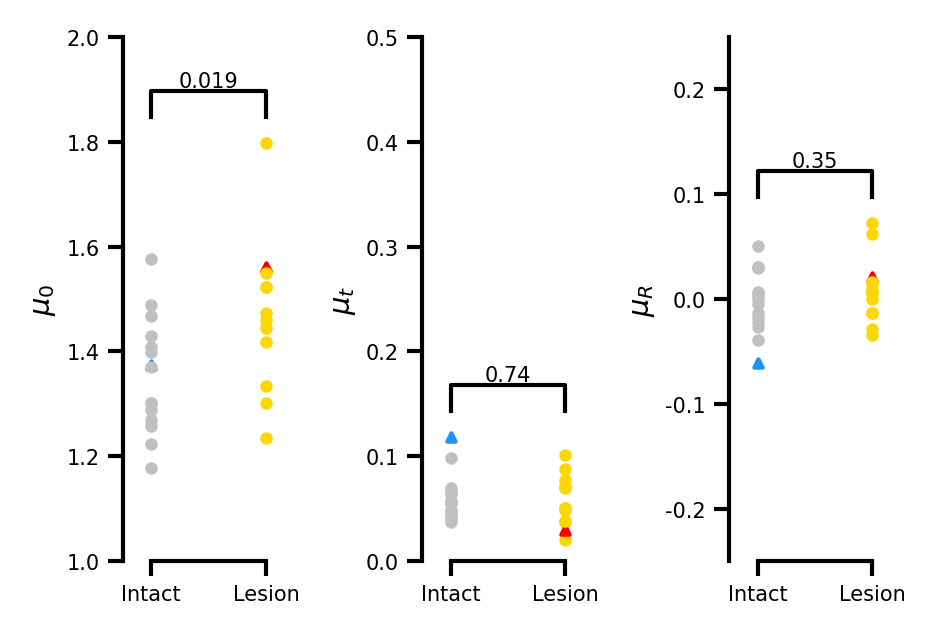

In [ ]:
def Figure6_J(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(mu_0[animal])
            x = 0
        else:
            lesion.append(mu_0[animal])
            x = 1
        ax.scatter(x, mu_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 2)
    ax.set_ylabel(r'$\mu_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("mu_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)


def Figure6_K(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(mu_t[animal])
            x = 0
        else:
            lesion.append(mu_t[animal])
            x = 1
        ax.scatter(x, mu_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, .5)
    ax.set_ylabel(r'$\mu_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("mu_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_L(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(mu_u[animal])
            x = 0
        else:
            lesion.append(mu_u[animal])
            x = 1
        ax.scatter(x, mu_u[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.25, .25)
    ax.set_ylabel(r'$\mu_u$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("mu_u", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_J(axs[0])
Figure6_K(axs[1])
Figure6_L(axs[2])

sigma_0 0.147
sigma_t 0.3322
sigma_R 0.5274


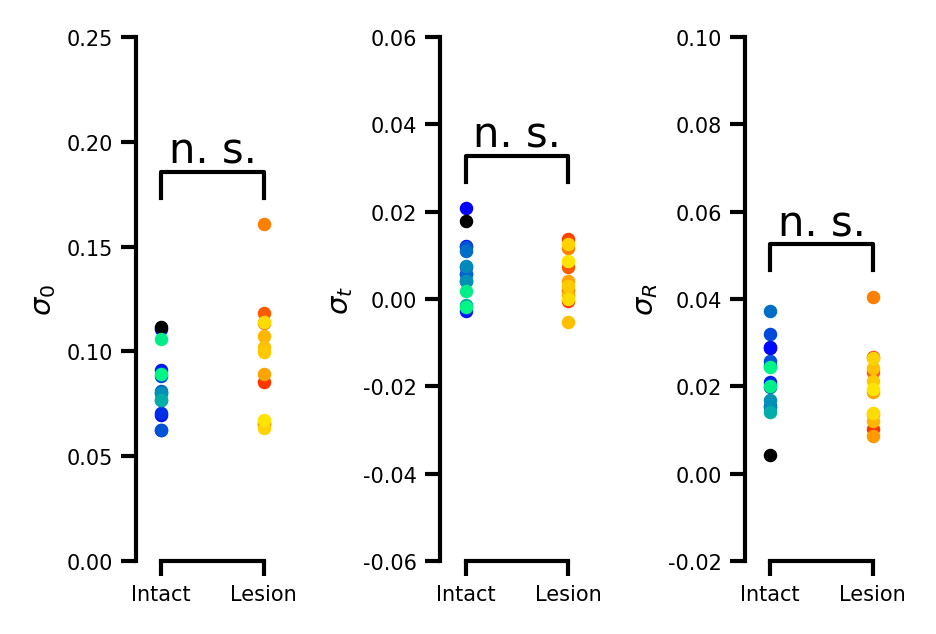

In [ ]:
def Figure6_J(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(sigma_0[animal])
            x = 0
        else:
            lesion.append(sigma_0[animal])
            x = 1
        ax.scatter(x, sigma_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, .25)
    ax.set_ylabel(r'$\sigma_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("sigma_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)


def Figure6_K(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(sigma_t[animal])
            x = 0
        else:
            lesion.append(sigma_t[animal])
            x = 1
        ax.scatter(x, sigma_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.06, 0.06)
    ax.set_ylabel(r'$\sigma_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("sigma_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_L(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(sigma_u[animal])
            x = 0
        else:
            lesion.append(sigma_u[animal])
            x = 1
        ax.scatter(x, sigma_u[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, .1)
    ax.set_ylabel(r'$\sigma_u$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("sigma_u", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_J(axs[0])
Figure6_K(axs[1])
Figure6_L(axs[2])

In [ ]:
realdist60 = {}
realdist90 = {}
realdist120= {}
realdist20= {}
realdistrev20= {}

# compute the running distance for each run (pos start - pos end) for each distance configuration
for animal in animalList:
    realdist60[animal], realdist90[animal], realdist120[animal] = ([] for _ in range(3))
    realdist20[animal], realdistrev20[animal] = ([] for _ in range(2))
    for session in sorted(matchsession(animal, dist60)):
        for i in range(0, 12):
            realdist60[animal] = np.append(realdist60[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist60[animal] = np.append(realdist60[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist90)):   
        for i in range(0, 12):
            realdist90[animal] = np.append(realdist90[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist90[animal] = np.append(realdist90[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist120)):
        for i in range(0, 12):
            realdist120[animal] = np.append(realdist120[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist120[animal] = np.append(realdist120[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])

    for session in sorted(matchsession(animal, TM20)):
        for i in range(0, 12):
            realdist20[animal] = np.append(realdist20[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist20[animal] = np.append(realdist20[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, TMrev20)):
        for i in range(0, 12):
            realdistrev20[animal] = np.append(realdistrev20[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdistrev20[animal] = np.append(realdistrev20[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])



# compute the mean running distance for each animal for each distance configuration
medianrealdist60 = {}
medianrealdist90 = {}
medianrealdist120 = {}
medianrealdist20 = {}
medianrealdistrev20 = {}

for animal in animalList:
    medianrealdist60[animal] = np.median(realdist60[animal]) / 100
    medianrealdist90[animal] = np.median(realdist90[animal]) / 100
    medianrealdist120[animal] = np.median(realdist120[animal]) / 100
    medianrealdist20[animal] = np.median(realdist20[animal]) / 100
    medianrealdistrev20[animal] = np.median(realdistrev20[animal]) / 100

# # compute the mean running distance for each distance configuration
# medianrealdist60 = np.median([medianrealdist60[animal] for animal in animalList])
# medianrealdist90 = np.median([medianrealdist90[animal] for animal in animalList])
# medianrealdist120 = np.median([medianrealdist120[animal] for animal in animalList])
# medianrealdist20 = np.median([medianrealdist20[animal] for animal in animalList])
# medianrealdistrev20 = np.median([medianrealdistrev20[animal] for animal in animalList])

# print('mean real distance for 60cm: ', medianrealdist60)
# print('mean real distance for 90cm: ', medianrealdist90)
# print('mean real distance for 120cm: ', medianrealdist120)
# # print('mean real distance for TM 20: ', meanrealdist20)
# # print('mean real distance for TM -20: ', meanrealdistrev20)

# pickle.dump([medianrealdist60, medianrealdist90, medianrealdist120, medianrealdist20, medianrealdistrev20], open('picklejar/medianrealdist.p', 'wb'))
medianrealdist60, medianrealdist90, medianrealdist120, medianrealdist20, medianrealdistrev20 = pickle.load(open('picklejar/medianrealdist.p', 'rb'))

In [ ]:
median_effort_sensitivity_intact_rat = np.median([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] == 'normal'])
median_effort_sensitivity_lesion_rat = np.median([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] != 'normal'])

median_power_intact_rat = np.median([power[animal] for animal in animalList if brainstatus[animal] == 'normal'])
median_power_lesion_rat = np.median([power[animal] for animal in animalList if brainstatus[animal] != 'normal'])

interquartile_effort_sensitivity_intact_rat = np.percentile([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] == 'normal'], 75) - np.percentile([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] == 'normal'], 25)
interquartile_effort_sensitivity_lesion_rat = np.percentile([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] != 'normal'], 75) - np.percentile([effort_sensitivity_0[animal] for animal in animalList if brainstatus[animal] != 'normal'], 25)

interquartile_power_intact_rat = np.percentile([power[animal] for animal in animalList if brainstatus[animal] == 'normal'], 75) - np.percentile([power[animal] for animal in animalList if brainstatus[animal] == 'normal'], 25)
interquartile_power_lesion_rat = np.percentile([power[animal] for animal in animalList if brainstatus[animal] != 'normal'], 75) - np.percentile([power[animal] for animal in animalList if brainstatus[animal] != 'normal'], 25)


print(f'Intact: {median_effort_sensitivity_intact_rat} IQR: {interquartile_effort_sensitivity_intact_rat}')
print(f'Lesion: {median_effort_sensitivity_lesion_rat} IQR: {interquartile_effort_sensitivity_lesion_rat}')

print(f'Intact: {median_power_intact_rat} IQR: {interquartile_power_intact_rat}')
print(f'Lesion: {median_power_lesion_rat} IQR: {interquartile_power_lesion_rat}')


Intact: 10.420143656811938 IQR: 5.246012864028229
Lesion: 17.097240149020212 IQR: 9.62112495302338
Intact: 2.375843241433299 IQR: 0.4936492708426461
Lesion: 2.9205782944291547 IQR: 0.2496857368054366


In [ ]:

median_mu_0 = {}
for animal in animalList:
    Vbelt_cst=0
    D_cst=.94

    D = [.31, .63, .96]
    vb = [-.2, -.1, 0, .1, .2]
    _ = [T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D]
    __ = [T_opt_n(D_cst, v, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for v in vb]

    res = _ + __
    median_mu_0[animal] = np.median(res)


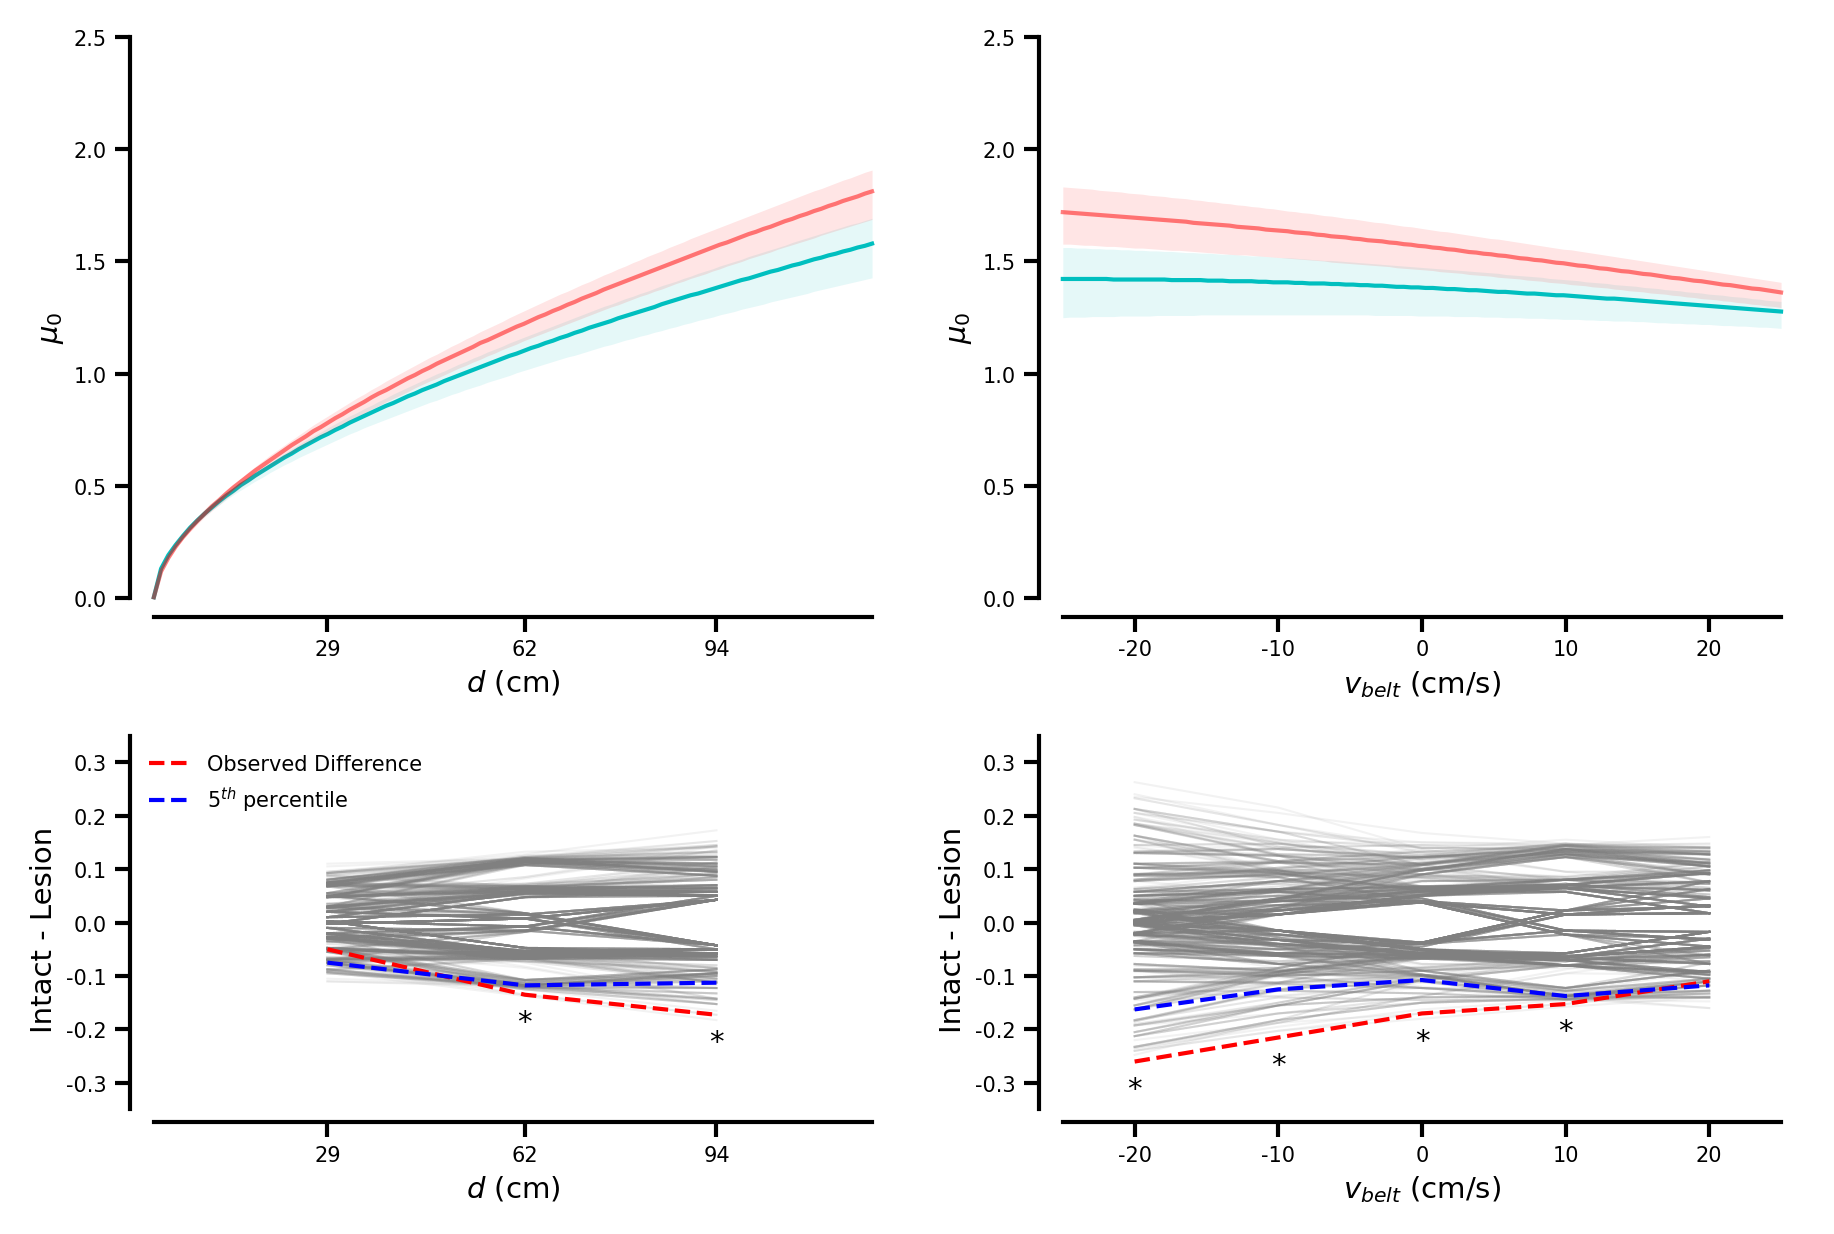

In [ ]:

# Topt as a function of D
def Figure3E(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(0, 1.2, 100)


    # plot median intact rat
    ax.plot(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for d in D], 
                    label=f'Median intact rats (n={len(animalList) - len(lesioned)})', c='c', lw=1, alpha=1, zorder=0)
    ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat - interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat - interquartile_power_intact_rat/2, power_time=3) for d in D],
                        [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat + interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat + interquartile_power_intact_rat/2, power_time=3) for d in D],
                        color='c', alpha=.1, lw=0, zorder=0)

    # plot median lesion rat
    ax.plot(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for d in D],
                    label=f'Example animal', c='r', lw=1, alpha=.5)
    ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat - interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat - interquartile_power_lesion_rat/2, power_time=3) for d in D],
                        [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat + interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat + interquartile_power_lesion_rat/2, power_time=3) for d in D],
                        label=f'Example animal', color='r', alpha=.1, lw=0)
    _ = r'$d$'
    ax.set_xlabel(f'{_} (cm)')
    ax.set_ylabel(r'$\mu_0$')
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([.29, .62, .94])
    ax.set_xticklabels([29, 62, 94])
    space_axes(ax)

    # handles, labels = ax.get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # ax.legend(*zip(*unique), loc='upper left',# bbox_to_anchor=(0.01, 0.99), 
    #                         frameon=True, fontsize=5, markerscale=1, 
    #                         edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)



# Topt as a function of Vbelt
def Figure3F(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(-.25, .25, 100)

    # plot median intact rat
    ax.plot(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for vbelt in VBELT], 
                    label=f'Example animal', c='c', lw=1, alpha=1, zorder=0)
    ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat - interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat - interquartile_power_intact_rat/2, power_time=3) for vbelt in VBELT],
                        [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat + interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat + interquartile_power_intact_rat/2, power_time=3) for vbelt in VBELT],
                        label=f'Example animal', color='c', alpha=.1, lw=0, zorder=0)

    # plot median lesion rat
    ax.plot(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for vbelt in VBELT],
                    label=f'Example animal', c='r', lw=1, alpha=.5)
    ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat - interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat - interquartile_power_lesion_rat/2, power_time=3) for vbelt in VBELT],
                        [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat + interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat + interquartile_power_lesion_rat/2, power_time=3) for vbelt in VBELT],
                        label=f'Example animal', color='r', alpha=.1, lw=0)
    _ = r'$d$'
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel(r'$\mu_0$')
    ax.set_xlim(-.25, 0.25)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([-.2, -.1, 0, .1, .2])
    ax.set_xticklabels([-20, -10, 0, 10, 20])
    space_axes(ax)

    
fig, axs = plt.subplots(2, 2, figsize=(6, 4), gridspec_kw={'height_ratios': [3, 2]})
Figure3E(ax=axs[0, 0])
Figure3F(ax=axs[0, 1])
plot_permutationDist(permuted_diffs, observed_diff, p_values, ax=axs[1, 0])
plot_permutationVbelt(permuted_diffs, observed_diff, p_values, ax=axs[1, 1])

[0.166 0.003 0.003 0.    0.    0.003 0.003 0.068]


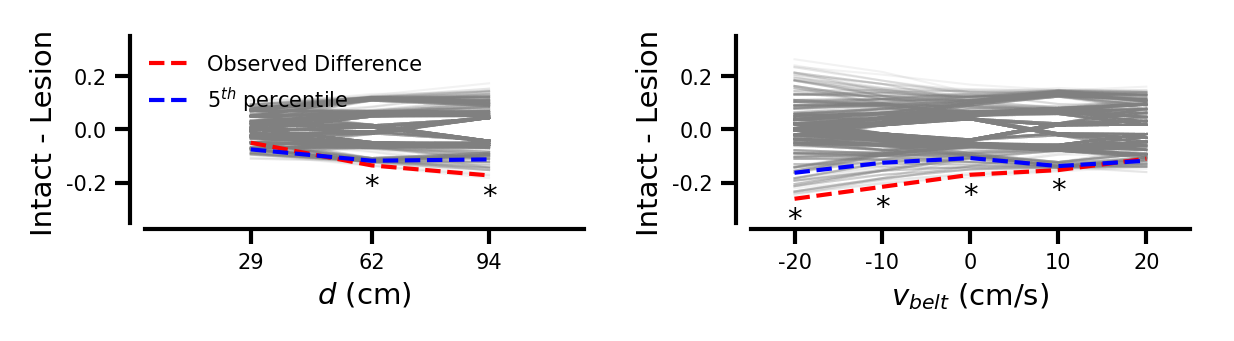

In [ ]:
D = [.31, .63, .96]
VBELT = [-.2, -.1, 0, .1, .2]

group1_data = []
group2_data = []
for animal in animalList:
    if brainstatus[animal] == 'normal':
        # group1_data.append([mu_0[animal][cond] for cond in ['60', '90', '120', 'rev20', 'rev10', '2', '10', '20']])
        group1_data.append([T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D]+[T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT])
    else:
        # group2_data.append([mu_0[animal][cond] for cond in ['60', '90', '120', 'rev20', 'rev10', '2', '10', '20']])
        group2_data.append([T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D]+[T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT])

ngroup1 = len(group1_data)
num_permutations = 1000

observed_diff = np.median(group1_data, axis=0) - np.median(group2_data, axis=0)
permuted_diffs = np.zeros((num_permutations, 8))


for i in range(num_permutations):
    combined_data = np.concatenate([group1_data, group2_data], axis=0)
    np.random.shuffle(combined_data)

    permuted_diff = np.median(combined_data[:ngroup1], axis=0) - np.median(combined_data[ngroup1:], axis=0)
    permuted_diffs[i] = permuted_diff

p_values = np.mean(permuted_diffs <= observed_diff, axis=0)
print(p_values)


def plot_permutationDist(permuted_diffs, observed_diff, p_values, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    for i in range(len(permuted_diffs)):
        ax.plot([.29, .62, .94], permuted_diffs[i][0:3], alpha=0.1, color='gray', lw=0.5)
    
    ax.plot([.29, .62, .94], observed_diff[0:3], color='red', linestyle='--', label='Observed Difference')
    ax.plot([.29, .62, .94], np.percentile(permuted_diffs, 5, axis=0)[0:3], color='blue', linestyle='--', label=r'$5^{th}$ percentile')

    for i, (pos, p) in enumerate(zip([.29, .62, .94], p_values[0:3])):
        ax.annotate('*' if p < 0.05 else '', xy=(pos, observed_diff[i]), xytext=(pos, observed_diff[i]-0.025), fontsize=7, ha='center', va='top')

    ax.set_ylim(-0.35, 0.35)
    _ = r'$d$'
    ax.set_xlabel(f'{_} (cm)')
    ax.set_ylabel('Intact - Lesion')
    ax.set_xlim(0, 1.2)
    ax.set_xticks([.29, .62, .94])
    ax.set_xticklabels([29, 62, 94])
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left',# bbox_to_anchor=(0.01, 0.99), 
                            frameon=False, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)



def plot_permutationVbelt(permuted_diffs, observed_diff, p_values, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    for i in range(len(permuted_diffs)):
        ax.plot([-.2, -.1, 0, .1, .2], permuted_diffs[i][3:8], alpha=0.1, color='gray', lw=0.5)
    
    ax.plot([-.2, -.1, 0, .1, .2], observed_diff[3:8], color='red', linestyle='--', label='Observed Difference')
    ax.plot([-.2, -.1, 0, .1, .2], np.percentile(permuted_diffs, 5, axis=0)[3:8], color='blue', linestyle='--', label='5e percentile')

    for i, (pos, p) in enumerate(zip([-.2, -.1, 0, .1, .2], p_values[3:8])):
        ax.annotate('*' if p < 0.05 else '', xy=(pos, observed_diff[i+3]), xytext=(pos, observed_diff[i+3]-0.025), fontsize=7, ha='center', va='top')
    ax.set_ylim(-0.35, 0.35)
    _ = r'$d$'
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel('Intact - Lesion')
    ax.set_xlim(-.25, 0.25)
    ax.set_xticks([-.2, -.1, 0, .1, .2])
    ax.set_xticklabels([-20, -10, 0, 10, 20])
    space_axes(ax)

    
fig, axs = plt.subplots(1, 2, figsize=(4, 1))
plot_permutationDist(permuted_diffs, observed_diff, p_values, ax=axs[0])
plot_permutationVbelt(permuted_diffs, observed_diff, p_values, ax=axs[1])


NameError: name 'intact' is not defined

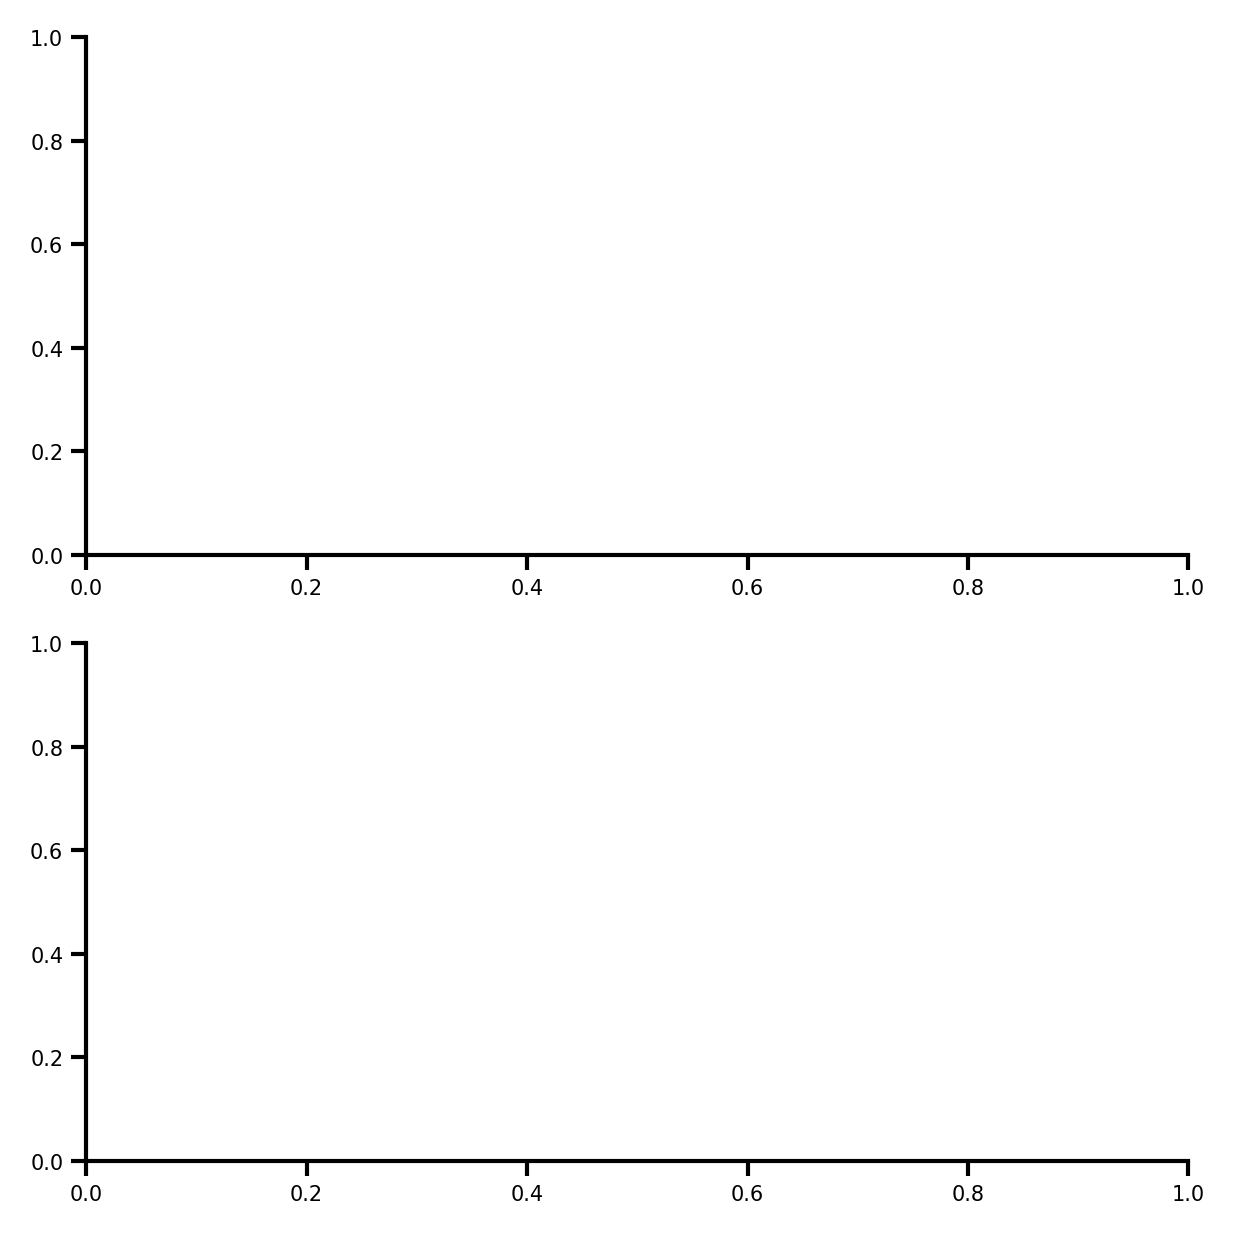

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(4, 4))

def Figure5C(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
    vars = alpha_0, alpha_t, gamma_0, gamma_t, gamma_u, mu_0, mu_t
    names = ('alpha_0', 'alpha_t', 'gamma_0', 'gamma_t', 'gamma_u', 'mu_0', 'mu_t')
    labels = [r'$\alpha_0$', r"$\alpha_t$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_u$", r'$\mu_0$', r"$\mu_t$"]

    populationRi = {}
    conf_bottom = {}
    conf_top = {}
    indivRi = {}
    ICC_bootstrap = {}

    if os.path.exists("picklejar/ICC_resamples.p"):
        populationRi, indivRi, conf_bottom, conf_top, ICC_bootstrap = pickle.load(open("picklejar/ICC_resamples.p", "rb"))
    else:
        for i, (var, name) in enumerate(zip(vars, names)):
            populationRi[name], indivRi[name], (conf_bottom[name], conf_top[name], ICC_bootstrap[name]) = compute_ICC(var, animalList=intact, bootstrap=True)
        pickle.dump([populationRi, indivRi, conf_bottom, conf_top, ICC_bootstrap], open("picklejar/ICC_resamples.p", "wb"))

    # sort the vars by populationRi
    sorted_names = [x for _,x in sorted(zip(populationRi.values(), names), reverse=True)]
    sorted_labels = [x for _,x in sorted(zip(populationRi.values(), labels), reverse=True)]


    for i, name in enumerate(sorted_names):
        for animal in intact:
            ax.scatter(np.random.normal(i, 0.025), indivRi[name][animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)

        # femalesRi = [indivRi[name][animal] for animal in intact if 'F' in animal]
        # malesRi = [indivRi[name][animal] for animal in intact if 'M' in animal]
        # print(f'{name} M vs F p = {exact_mc_perm_test(malesRi, femalesRi)}')
        # print(f'{name} M vs F p = {stats.mannwhitneyu(malesRi, femalesRi)}')

        line = 0.2/2
        ax.plot([i+.25-line, i+.25+line], [populationRi[name], populationRi[name]], color='k', lw=.75, zorder=1)
        ax.scatter(i+.25, populationRi[name], color='k', s=2.5, zorder=2)

        violin_parts = ax.violinplot(positions=[i+.25], 
                        dataset=[ICC_bootstrap[name]],
                        widths=.2, showextrema=False, 
                        quantiles=[0.05, 0.95])
        
        for vp in violin_parts['bodies']:
            vp.set_facecolor('lightgray')
            vp.set_edgecolor('lightgray')
            vp.set_linewidth(0)
            vp.set_alpha(1)
            vp.set_zorder(0)

        violin_parts['cquantiles'].set_facecolor('gray')
        violin_parts['cquantiles'].set_edgecolor('gray')
        violin_parts['cquantiles'].set_linewidth(.5)
        violin_parts['cquantiles'].set_alpha(1)
        violin_parts['cquantiles'].set_zorder(1)
        
        for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
            try:
                vp = violin_parts[partname]
                vp.set_edgecolor('gray')
                vp.set_linewidth(0)
                vp.set_alpha(0)
            except:
                pass

    ax.set_xlim(0, len(sorted_labels)-1)
    ax.set_xticks(range(len(sorted_labels)))
    ax.set_xticklabels(sorted_labels)
    ax.set_ylabel('ICC')
    ax.set_ylim(0, 1)
    # ax.set_yticklabels('')
    # ax.set_yticks([0, 0.5, 0.75, .9, 1])
    # ax.set_yticks([0.25, 0.625, 0.825, .95], minor=True)
    # ax.set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
    # ax.tick_params(which='minor', length=0)
    ax.set_yticks([0, 0.4, 0.6, 0.75, 1])
    # ax.set_yticks([0.2, 0.5, 0.675, 0.875], minor=True)
    # ax.set_yticklabels(["Poor", "Fair", "Good", "Excellent"], minor=True)
    # ax.tick_params(which='minor', length=0)
    space_axes(ax, x_ratio_right=.1)


def Figure5D(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
    vars = alpha_0, alpha_t, gamma_0, gamma_t, gamma_u, mu_0, mu_t
    names = ('alpha_0', 'alpha_t', 'gamma_0', 'gamma_t', 'gamma_u', 'mu_0', 'mu_t')
    labels = [r'$\alpha_0$', r"$\alpha_t$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_u$", r'$\mu_0$', r"$\mu_t$"]

    populationRi = {}
    conf_bottom = {}
    conf_top = {}
    indivRi = {}
    ICC_bootstrap = {}

    if os.path.exists("picklejar/ICC_resamples.p"):
        populationRi, indivRi, conf_bottom, conf_top, ICC_bootstrap = pickle.load(open("picklejar/ICC_resamples.p", "rb"))
    else:
        for i, (var, name) in enumerate(zip(vars, names)):
            populationRi[name], indivRi[name], (conf_bottom[name], conf_top[name], ICC_bootstrap[name]) = compute_ICC(var, animalList=intact, bootstrap=True)
        pickle.dump([populationRi, indivRi, conf_bottom, conf_top, ICC_bootstrap], open("picklejar/ICC_resamples.p", "wb"))

    for i, animal in enumerate(intact):

        ax.scatter([i] * len([indivRi[name][animal] for name in names]),
                        [indivRi[name][animal] for name in names],
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], s=4)
                        
        lower = np.percentile([indivRi[name][animal] for name in names], 5)
        upper = np.percentile([indivRi[name][animal] for name in names], 95)

        ax.errorbar(i, np.median([indivRi[name][animal] for name in names]), 
                        yerr=[[np.median([indivRi[name][animal] for name in names]) - lower], 
                                [upper - np.median([indivRi[name][animal] for name in names])]],
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        capsize=5, capthick=1, elinewidth=1)

    ax.set_xlim(0, len(intact)-1)
    ax.set_xticks(range(len(intact)))
    ax.set_xticklabels(intact, rotation=90)
    ax.set_ylabel('Overall ICC')
    ax.set_ylim(0, 1)
    # ax.set_yticklabels('')
    # ax.set_yticks([0, 0.5, 0.75, .9, 1])
    # ax.set_yticks([0.25, 0.625, 0.825, .95], minor=True)
    # ax.set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
    # ax.tick_params(which='minor', length=0)
    ax.set_yticks([0, 0.4, 0.6, 0.75, 1])   
    # ax.set_yticks([0.2, 0.5, 0.675, 0.875], minor=True)
    # ax.set_yticklabels(["Poor", "Fair", "Good", "Excellent"], minor=True)
    # ax.tick_params(which='minor', length=0)
    space_axes(ax)


Figure5C(axs[0])
Figure5D(axs[1])

In [ ]:
fig = plt.figure(figsize=(cm2inch(18), cm2inch(12)), constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(5, 1, wspace=.5, hspace=.5, height_ratios=[3, 1, 15, 1, 3])

row1 = gs0[0].subgridspec(1, 4)
coordinates = plt.subplot(row1[0, 0])
lesion_example = plt.subplot(row1[0, 1])
lesion_example = plt.subplot(row1[0, 2])
lesion_example = plt.subplot(row1[0, 3])

row2 = gs0[2].subgridspec(3, 4, width_ratios=[1, 1, 1, 3])
comparison_effort_sensitivity_0 = plt.subplot(row2[0, 0])
comparison_effort_sensitivity_t = plt.subplot(row2[0, 1])
comparison_effort_sensitivity_u = plt.subplot(row2[0, 2])
spare = plt.subplot(row2[0, 3])

comparison_alpha_0 = plt.subplot(row2[1, 0])
comparison_alpha_t = plt.subplot(row2[1, 1])
comparison_alpha_u = plt.subplot(row2[1, 2])
spare = plt.subplot(row2[1, 3])

comparison_gamma_0 = plt.subplot(row2[2, 0])
comparison_gamma_t = plt.subplot(row2[2, 1])
comparison_gamma_u = plt.subplot(row2[2, 2])
spare = plt.subplot(row2[2, 3])


row3 = gs0[4].subgridspec(1, 3, width_ratios=[2, 2, 4])
PCA1 = plt.subplot(row3[0, 0])
PCA2 = plt.subplot(row3[0, 1])
Ri = plt.subplot(row3[0, 2])

figuresLabels={"A":[0.00, 1.00], "B":[0.25, 1.00], "C":[0.50, 1.00], "D":[0.75, 1.00],
               "E":[0.00, 0.65], "F":[0.22, 0.65], "G":[0.415, 0.65], "H":[0.61, 0.65], "I":[0.805, 0.65],
               "J":[0.00, 0.31], "K":[0.22, 0.31], "L":[0.415, 0.31], "M":[0.61, 0.31], "N":[0.805, 0.31]}

# for label,coordinates in sorted(figuresLabels.items()):
#     fig.text(coordinates[0], coordinates[1],
#              label, figure=fig, 
#              weight='bold', fontsize=7, ha='left', va='bottom')
    


Figure6_A(ax = comparison_effort_sensitivity_0)
Figure6_B(ax = comparison_effort_sensitivity_t)
Figure6_C(ax = comparison_effort_sensitivity_u)

Figure6_D(ax = comparison_alpha_0)
Figure6_E(ax = comparison_alpha_t)
Figure6_F(ax = comparison_alpha_u)

Figure6_G(ax = comparison_gamma_0)
Figure6_H(ax = comparison_gamma_t)
Figure6_I(ax = comparison_gamma_u)



plt.savefig("/home/david/Desktop/code/Figure_6.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

In [ ]:
conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']

alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

_alpha_0 = {animal: np.median([alpha_0[animal][cond] for cond in conds]) for animal in animalList}
_alpha_t = {animal: np.median([alpha_t[animal][cond] for cond in conds]) for animal in animalList}
_alpha_u = {animal: np.median([alpha_u[animal][cond] for cond in conds]) for animal in animalList}
_gamma_0 = {animal: np.median([gamma_0[animal][cond] for cond in conds]) for animal in animalList}
_gamma_t = {animal: np.median([gamma_t[animal][cond] for cond in conds]) for animal in animalList}
_gamma_u = {animal: np.median([gamma_u[animal][cond] for cond in conds]) for animal in animalList}
_mu_0 = {animal: np.median([mu_0[animal][cond] for cond in conds]) for animal in animalList}
_mu_t = {animal: np.median([mu_t[animal][cond] for cond in conds]) for animal in animalList}
_mu_u = {animal: np.median([mu_u[animal][cond] for cond in conds]) for animal in animalList}
_sigma_0 = {animal: np.median([sigma_0[animal][cond] for cond in conds]) for animal in animalList}
_sigma_t = {animal: np.median([sigma_t[animal][cond] for cond in conds]) for animal in animalList}
_sigma_u = {animal: np.median([sigma_u[animal][cond] for cond in conds]) for animal in animalList}

vars = [effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, _alpha_0, _alpha_t, _alpha_u, _gamma_0, _gamma_t, _gamma_u, _mu_0, _mu_t, _mu_u, _sigma_0, _sigma_t, _sigma_u]
names = ['effort_sensitivity_0', 'effort_sensitivity_t', 'effort_sensitivity_u', 'alpha_0', 'alpha_t', 'alpha_u', 'gamma_0', 'gamma_t', 'gamma_u', 'mu_0', 'mu_t', 'mu_u', 'sigma_0', 'sigma_t', 'sigma_u']

fig, axs = plt.subplots(5, 3, figsize=(6, 10))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in animalList:
        if animal in lesion_area.keys():
            ax.scatter(lesion_area[animal], var[animal], label=animal, color=rat_markers[animal][0])
            x.append(lesion_area[animal])
            y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion size')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')

In [ ]:

fig, axs = plt.subplots(5, 3, figsize=(6, 10))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in animalList:
        if animal in lesion_pos.keys():
            ax.scatter(lesion_pos[animal], var[animal], label=animal+brainstatus[animal])
            x.append(lesion_pos[animal])
            y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion position')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')

axs[1, 2].legend()

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


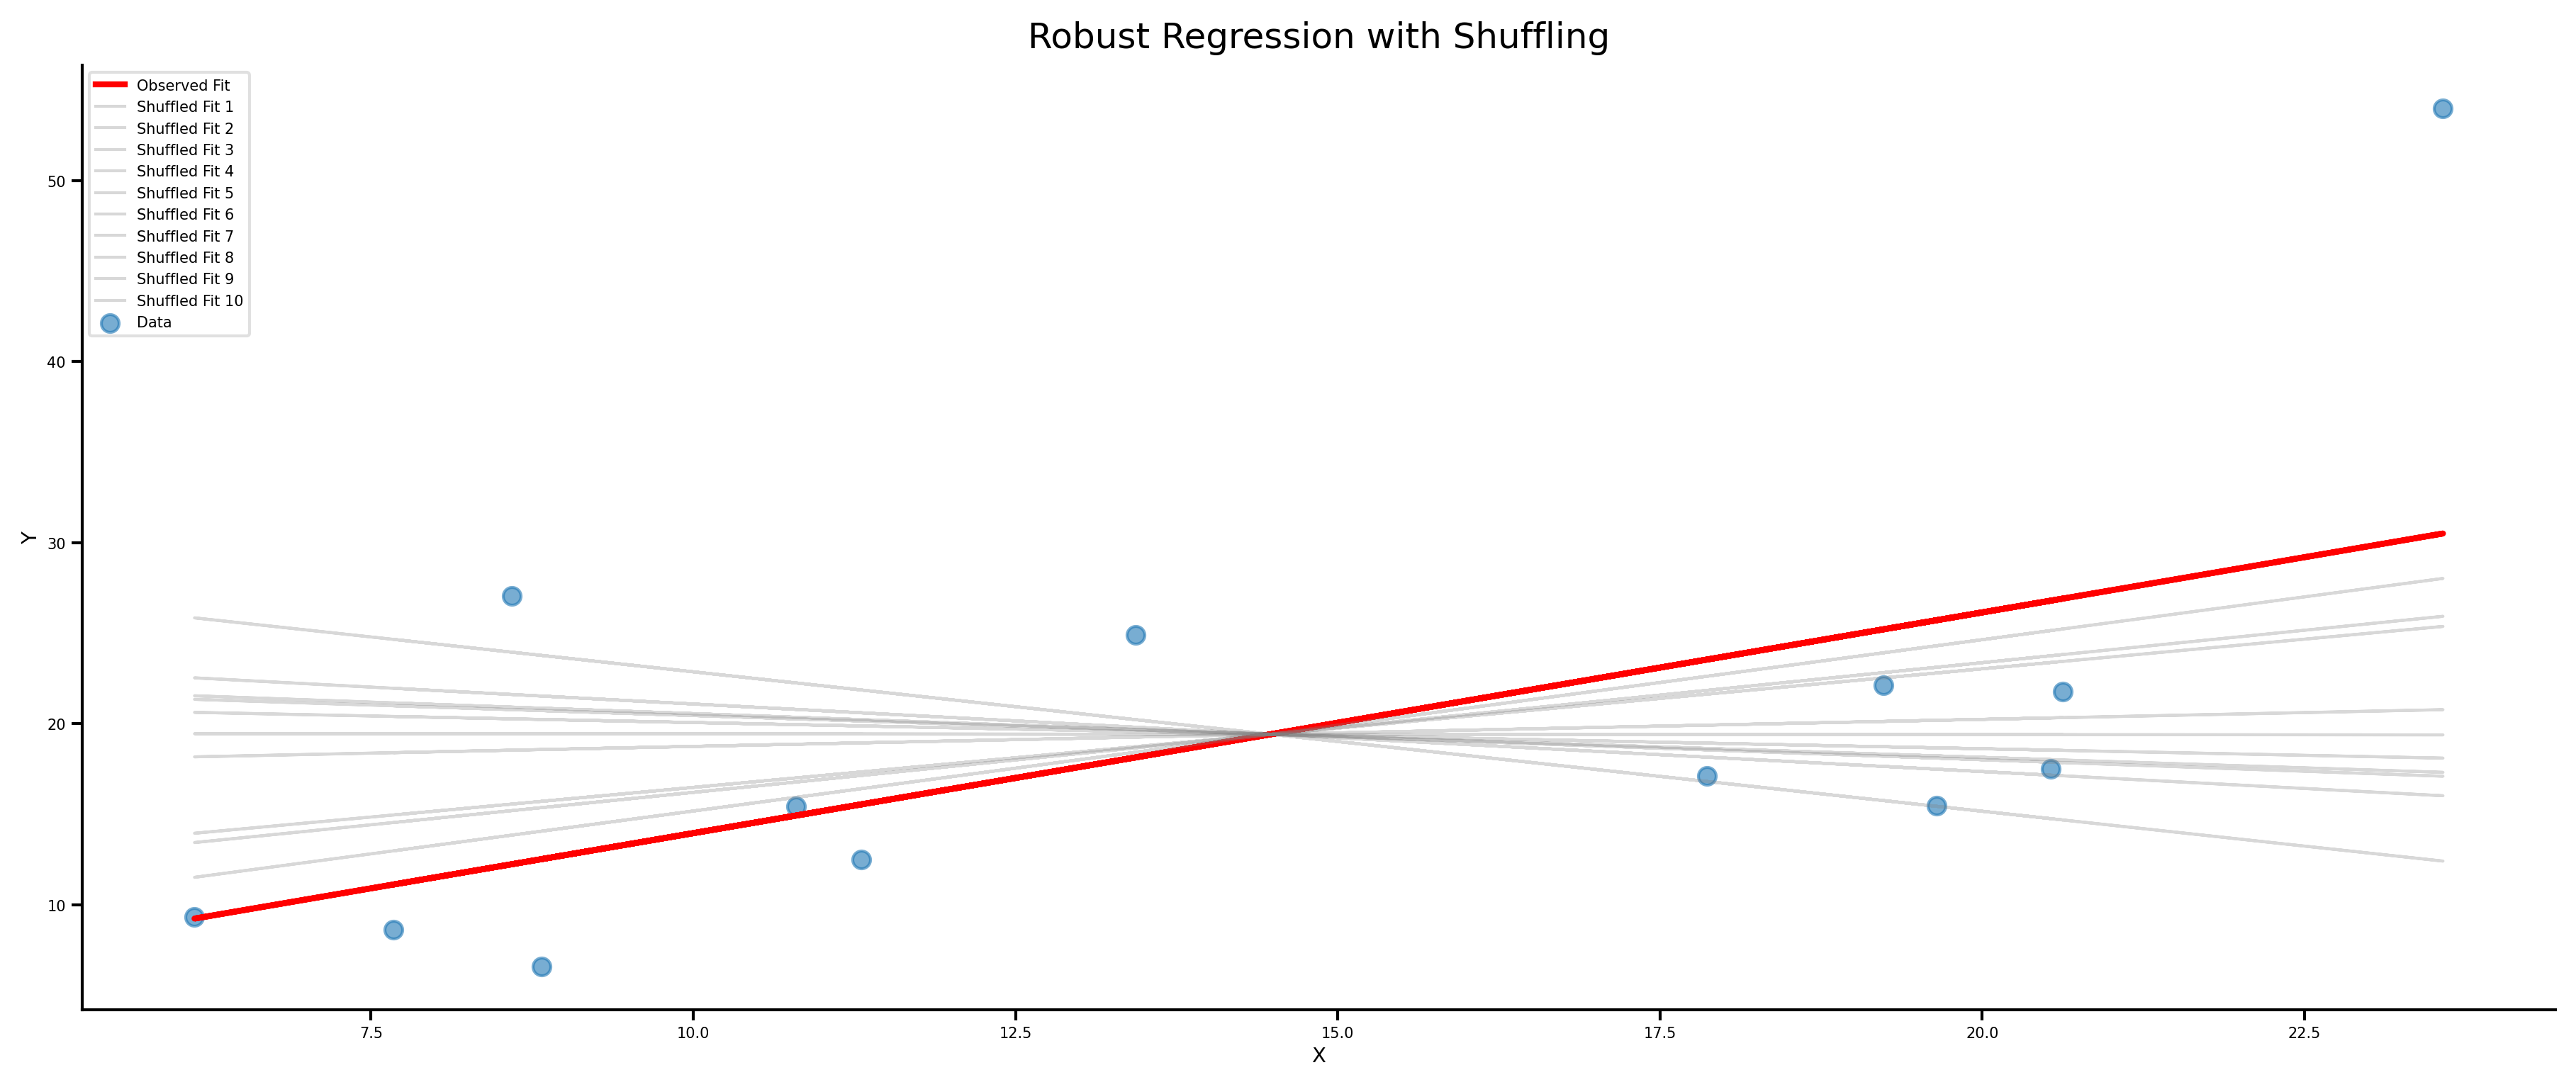

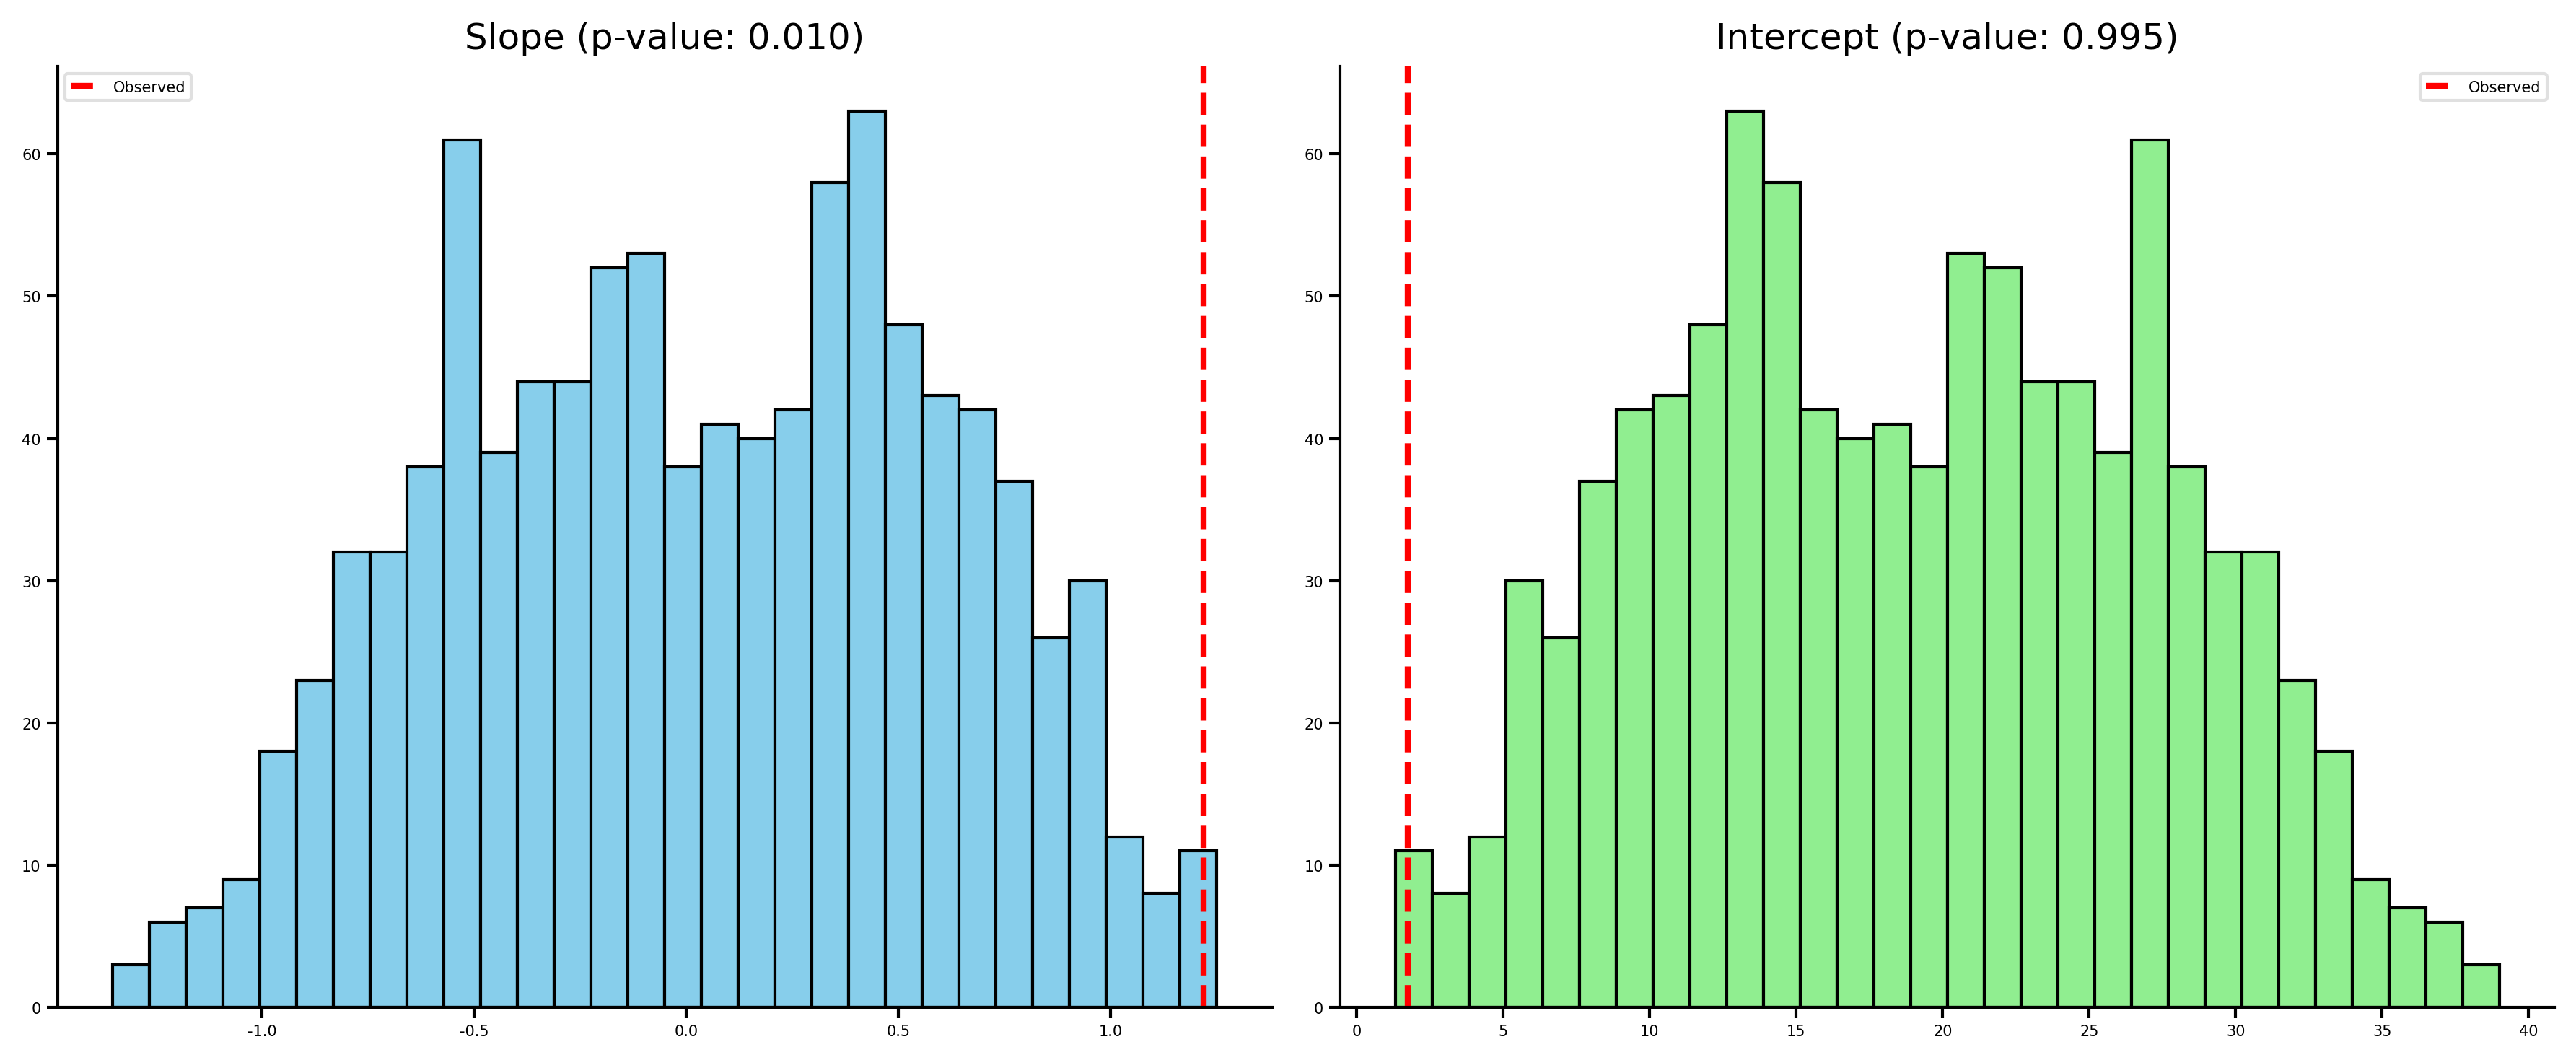

In [ ]:

x = np.array([lesion_area[animal] for animal in lesioned])*100
y = np.array([effort_sensitivity_0[animal] for animal in lesioned])
# Number of permutations
num_permutations = 1000

# Observed regression coefficients
observed_slope, observed_intercept = np.polyfit(x, y, 1)

# Initialize arrays to store permutation results
permutation_slopes = np.zeros(num_permutations)
permutation_intercepts = np.zeros(num_permutations)

# Initialize arrays to store fitted lines
observed_fit = observed_slope * x + observed_intercept
permutation_fits = []

# Perform permutation test
for i in range(num_permutations):
    # Shuffle the y values
    shuffled_y = np.random.permutation(y)

    # Compute regression coefficients for shuffled data
    slope, intercept = np.polyfit(x, shuffled_y, 1)
    
    permutation_slopes[i] = slope
    permutation_intercepts[i] = intercept
    
    # Calculate and store the fitted line for shuffled data
    permutation_fit = slope * x + intercept
    permutation_fits.append(permutation_fit)

# Calculate p-values
p_value_slope = (np.abs(permutation_slopes) >= np.abs(observed_slope)).mean()
p_value_intercept = (np.abs(permutation_intercepts) >= np.abs(observed_intercept)).mean()

# Plot the data, observed fit, and shuffled fits
plt.figure(figsize=(12, 5))
plt.scatter(x, y, label='Data', alpha=0.6)
plt.plot(x, observed_fit, color='red', linewidth=2, label='Observed Fit')
for i, fit in enumerate(permutation_fits[:10]):  # Plot a subset of shuffled fits for clarity
    plt.plot(x, fit, color='gray', alpha=0.3, label=f'Shuffled Fit {i+1}')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Robust Regression with Shuffling')
plt.legend()

# Plot the distribution of permutation results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(permutation_slopes, bins=30, color='skyblue', edgecolor='black')
plt.axvline(observed_slope, color='red', linestyle='dashed', linewidth=2, label='Observed')
plt.title(f'Slope (p-value: {p_value_slope:.3f})')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(permutation_intercepts, bins=30, color='lightgreen', edgecolor='black')
plt.axvline(observed_intercept, color='red', linestyle='dashed', linewidth=2, label='Observed')
plt.title(f'Intercept (p-value: {p_value_intercept:.3f})')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress


# Number of bootstraps and shuffles
n_bootstraps = 10000
n_shuffles = 10000

# Store the results of the slope and intercept
bootstrap_slopes = np.zeros(n_bootstraps)
bootstrap_intercepts = np.zeros(n_bootstraps)

# Perform bootstrap resampling
for i in range(n_bootstraps):
    # Randomly sample with replacement
    indices = np.random.choice(len(x), len(x), replace=True)
    x_bootstrap = x[indices]
    y_bootstrap = y[indices]
    
    # Fit a linear regression model to the resampled data
    slope, intercept, _, _, _ = linregress(x_bootstrap, y_bootstrap)
    bootstrap_slopes[i] = slope
    bootstrap_intercepts[i] = intercept

# Compute the observed slope and intercept
observed_slope, observed_intercept, _, _, _ = linregress(x, y)

# Compute the 95% bootstrap confidence interval
conf_interval = np.percentile(bootstrap_slopes, [5, 95])

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Subplot 1: Original Data with Regression Line and Bootstrap Confidence Interval
axs[0, 0].scatter(x, y, label='Data')
axs[0, 0].set_title('Original Data')

# Fit a linear regression model to the original data
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the regression line
regression_line = slope * x + intercept

axs[0, 0].plot(x, regression_line, color='red', label='Regression Line')
axs[0, 0].fill_between(x, x*conf_interval[0] + intercept, x*conf_interval[1] + intercept, color='gray', alpha=0.5, label='95% Confidence Interval (Bootstrap)')
axs[0, 0].legend()

# Subplot 2: Bootstrapped Regression
axs[0, 1].hist(bootstrap_slopes, bins=30, color='blue', alpha=0.7, label='Bootstrapped Slopes')
axs[0, 1].axvline(x=observed_slope, color='red', linestyle='--', label='Observed Slope')
axs[0, 1].set_title('Bootstrapped Regression')
axs[0, 1].legend()

# Subplot 3: Shuffled Distribution
axs[1, 0].hist(shuffle_slopes, bins=30, color='green', alpha=0.7, label='Shuffled Slopes')
axs[1, 0].axvline(x=observed_slope, color='red', linestyle='--', label='Observed Slope')
axs[1, 0].set_title('Shuffled Distribution')
axs[1, 0].legend()

# Subplot 4: Empty
axs[1, 1].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

print("Observed Slope:", observed_slope)
print("95% Confidence Interval (Bootstrap):", conf_interval)


In [ ]:
def median_contour(contours):

    max_points = max(len(contour) for contour in contours)
    contours_array = np.zeros((len(contours), max_points, 2))

    # Fill the contours_array with contour data
    for i, contour in enumerate(contours):
        num_points = len(contour)
        contours_array[i, :num_points, :] = contour

    # Calculate the pairwise distances between all points in the contours
    distances = np.zeros((len(contours), len(contours)))

    for i in range(len(contours)):
        for j in range(len(contours)):
            distances[i, j] = np.sum(np.linalg.norm(contours_array[i, :num_points, :] - contours_array[j, :num_points, :], axis=1))

    # Find the contour with the minimum total pairwise distance to others
    median_contour_index = np.argmin(np.sum(distances, axis=0))

    # The median contour is the one with the minimum total distance
    median_contour = contours_array[median_contour_index, :len(contours[median_contour_index]), :]

    return median_contour

# contours = zip(x_striatum_left, y_striatum_left)
# contours = [np.array(contour).T for contour in contours]
# med = median_contour(contours)

# fig, ax = plt.subplots(1, 1, figsize=(1, 1))
# ax.plot(med[:, 0], med[:, 1], 'k', lw=2)



from matplotlib.patches import Polygon
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
x_striatum_left, y_striatum_left = [], []
x_lesion_left, y_lesion_left = [], []
x_striatum_right, y_striatum_right = [], []
x_lesion_right, y_lesion_right = [], []

for animal in lesioned:
    print(animal)
    animalFolder = histologyroot + '/' + animal
    slices = glob.glob(animalFolder + '/slice*.czi')

    for slice in slices:
        # if slice == slices[0]:
            
            x = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x)
            offset_y = np.mean(y)

            axs[0].plot(x - offset_x, y - offset_y, 'k', alpha=0.2)
            x_striatum_left.append(x - offset_x)
            y_striatum_left.append(y - offset_y)

            x_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, True, facecolor='r', alpha=.05)
            axs[0].add_patch(polygon)

            # ax.plot(x_lesion - offset_x, y_lesion - offset_y, 'r', alpha=0.2)
            x_lesion_left.append(x_lesion - offset_x)
            y_lesion_left.append(y_lesion - offset_y)


            x = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x)
            offset_y = np.mean(y)

            axs[1].plot(x - offset_x, y - offset_y, 'k', alpha=0.2)
            x_striatum_right.append(x - offset_x)
            y_striatum_right.append(y - offset_y)

            x_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, True, facecolor='r', alpha=.05)
            axs[1].add_patch(polygon)

            # axs[1].plot(x_lesion - offset_x, y_lesion - offset_y, 'r', alpha=0.2)
            x_lesion_right.append(x_lesion - offset_x)
            y_lesion_right.append(y_lesion - offset_y)


contours_striatum_left = zip(x_striatum_left, y_striatum_left)
contours_striatum_left = [np.array(contour).T for contour in contours_striatum_left]

contours_lesion_left = zip(x_lesion_left, y_lesion_left)
contours_lesion_left = [np.array(contour).T for contour in contours_lesion_left]

median_striatum_left = median_contour(contours_striatum_left)
median_lesion_left = median_contour(contours_lesion_left)

axs[0].plot(median_striatum_left[:, 0], median_striatum_left[:, 1], 'k', lw=2)
# axs[0].plot(median_lesion_left[:, 0], median_lesion_left[:, 1], 'r', lw=2)


contours_striatum_right = zip(x_striatum_right, y_striatum_right)
contours_striatum_right = [np.array(contour).T for contour in contours_striatum_right]

contours_lesion_right = zip(x_lesion_right, y_lesion_right)
contours_lesion_right = [np.array(contour).T for contour in contours_lesion_right]

median_striatum_right = median_contour(contours_striatum_right)
median_lesion_right = median_contour(contours_lesion_right)

axs[1].plot(median_striatum_right[:, 0], median_striatum_right[:, 1], 'k', lw=2)
# axs[1].plot(median_lesion_right[:, 0], median_lesion_right[:, 1], 'r', lw=2)

            

axs[0].set_xlim(-2000, 2000)
axs[0].set_ylim(-2000, 2000)
axs[1].set_xlim(-2000, 2000)
axs[1].set_ylim(-2000, 2000)

RatF30
RatF31
RatM30
RatF40
RatF41
RatM41
RatM42
RatF50
RatF51
RatF52
RatM50
RatM51
RatM52


(-2000.0, 2000.0)

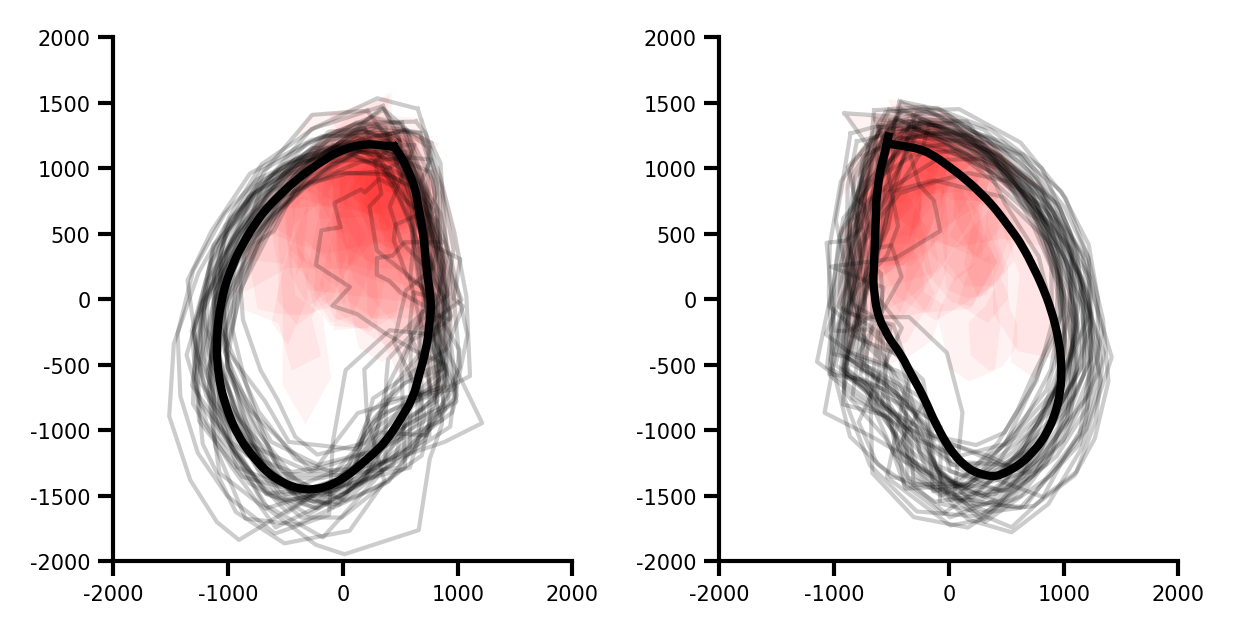

In [ ]:

def compute_median_contour(x, y, stat='Med.'):
    # eps, zmax, lenlim used in outlier detection. Here they are set so they don't exclude any outlier in the median computation. Outlying runs will be//are removed beforehand.
    eps = 0.001
    zmax = np.inf
    lenlim=(-np.inf, np.inf)
    data = list(zip(x, y))

    ss = SampleSet(data)
    # ss.getAvg(zmax, lenlim, eps, stat) # not supposed to do anything but has to be here to work ??????? Therefore, no touchy. 
    X, Y = ss.getAvg(zmax, lenlim, eps, stat)
    return X, Y

# x, y = compute_median_contour(x_striatum_left, y_striatum_left, stat='Med.')
# plt.plot(x, y, 'k', lw=2)
# plt.xlim(-2000, 2000)
# plt.ylim(-2000, 2000)


from matplotlib.patches import Polygon
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
x_striatum_left, y_striatum_left = [], []
x_lesion_left, y_lesion_left = [], []
x_striatum_right, y_striatum_right = [], []
x_lesion_right, y_lesion_right = [], []

for animal in lesioned:
    print(animal)
    animalFolder = histologyroot + '/' + animal
    slices = glob.glob(animalFolder + '/slice*.czi')

    for slice in slices:
        # if slice == slices[0]:
            
            x = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x)
            offset_y = np.mean(y)
            # offset_x = np.max(x)
            # offset_y = np.max(y)

            axs[0].plot(x - offset_x, y - offset_y, 'k', alpha=0.2)
            x_striatum_left.append(x - offset_x)
            y_striatum_left.append(y - offset_y)

            x_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, True, facecolor='r', alpha=.05)
            axs[0].add_patch(polygon)

            # ax.plot(x_lesion - offset_x, y_lesion - offset_y, 'r', alpha=0.2)
            x_lesion_left.append(x_lesion - offset_x)
            y_lesion_left.append(y_lesion - offset_y)


            x = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x)
            offset_y = np.mean(y)
            # offset_x = np.max(x)
            # offset_y = np.max(y)

            axs[1].plot(x - offset_x, y - offset_y, 'k', alpha=0.2)
            x_striatum_right.append(x - offset_x)
            y_striatum_right.append(y - offset_y)

            x_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, True, facecolor='r', alpha=.05)
            axs[1].add_patch(polygon)

            # axs[i, 1].plot(x_lesion - offset_x, y_lesion - offset_y, 'r', alpha=0.2)
            x_lesion_right.append(x_lesion - offset_x)
            y_lesion_right.append(y_lesion - offset_y)

stat = 'Avg.' #'Med.'
x, y = compute_median_contour(x_striatum_left, y_striatum_left, stat=stat)
axs[0].plot(x, y, 'k', lw=2)

x, y = compute_median_contour(x_striatum_right, y_striatum_right, stat=stat)
axs[1].plot(x, y, 'k', lw=2)

# x, y = compute_median_contour(x_lesion_left, y_lesion_left, stat=stat)
# axs[0].plot(x, y, 'r', lw=2)

# x, y = compute_median_contour(x_lesion_right, y_lesion_right, stat=stat)
# axs[1].plot(x, y, 'r', lw=2)


# contours_striatum_left = zip(x_striatum_left, y_striatum_left)
# contours_striatum_left = [np.array(contour).T for contour in contours_striatum_left]
# contours_lesion_left = zip(x_lesion_left, y_lesion_left)
# contours_lesion_left = [np.array(contour).T for contour in contours_lesion_left]
# median_striatum_left = median_contour(contours_striatum_left)
# median_lesion_left = median_contour(contours_lesion_left)

# axs[i, 0].plot(median_striatum_left[:, 0], median_striatum_left[:, 1], 'k', lw=2)
# # axs[i, 0].plot(median_lesion_left[:, 0], median_lesion_left[:, 1], 'r', lw=2)



# contours_striatum_right = zip(x_striatum_right, y_striatum_right)
# contours_striatum_right = [np.array(contour).T for contour in contours_striatum_right]
# contours_lesion_right = zip(x_lesion_right, y_lesion_right)
# contours_lesion_right = [np.array(contour).T for contour in contours_lesion_right]
# median_striatum_right = median_contour(contours_striatum_right)
# median_lesion_right = median_contour(contours_lesion_right)

# axs[i, 1].plot(median_striatum_right[:, 0], median_striatum_right[:, 1], 'k', lw=2)
# # axs[i, 1].plot(median_lesion_right[:, 0], median_lesion_right[:, 1], 'r', lw=2)

            

axs[0].set_xlim(-2000, 2000)
axs[0].set_ylim(-2000, 2000)
axs[1].set_xlim(-2000, 2000)
axs[1].set_ylim(-2000, 2000)

In [ ]:
from scipy.optimize import curve_fit

def Figure6_H(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_area[animal], effort_sensitivity_0[animal], color=rat_markers[animal][0], zorder=10)
        x.append(lesion_area[animal])
        y.append(effort_sensitivity_0[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # calculate confidence intervals for fitted line
    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000)
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0)
    upper = np.percentile(ysample, 97.5, axis=0)

    # plot the regression and confidence intervals
    y_fit = np.poly1d(p)(xi)
    ax.plot(xi, y_fit, color='gray', zorder=1)
    ax.fill_between(xi, lower, upper, color='gray', alpha=.1, zorder=0, lw=0)

    ax.set_xlabel('Lesion size')
    ax.set_xlim(0.05, .25)
    ax.set_ylabel(r'$\varsigma_0$')
    ax.set_ylim(0, 60)
    space_axes(ax)

    y_mean = np.mean(y)
    y_pred = f(x, *p)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_total)
    r = np.sqrt(r_squared)

    # pvalue annotation
    ax.annotate(f"$p$ = 0.014", xy=(.60, .18), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.2f}", xy=(.60, .1), xycoords='axes fraction', fontsize=7, ha='left', va='top')

def Figure6_Hbis(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in lesioned:
        x.append(lesion_area[animal])
        y.append(effort_sensitivity_0[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # shuffle to get p-value
    observed_slope = p[0]
    num_iterations = 1000
    shuffled_slopes = []

    np.random.seed(0)
    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        p_shuffled, _ = curve_fit(f, x, shuffled_y, [1, 1])
        shuffled_slope = p_shuffled[0]
        shuffled_slopes.append(shuffled_slope)

    # Calculate the p-value
    p_value = (np.abs(shuffled_slopes) >= np.abs(observed_slope)).mean()


    ax.hist(shuffled_slopes, bins=20, color='gray', alpha=.25, zorder=0)
    ax.axvline(observed_slope, ymin=1/30, color='gray', label='Observed')
    ax.set_xlabel('Slope')
    ax.set_xlim(-200, 200)
    ax.set_ylabel('No. of shuffles')
    ax.set_ylim(0, 100)
    space_axes(ax)

    print(f"Observed Slope: {observed_slope:.4f}")
    print(f"P-value: {p_value:.4f}")

fig, axs = plt.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios': [5, 1]})
Figure6_H(ax=axs[0])
Figure6_Hbis(ax=axs[1])

[0.18  0.006 0.006 0.001 0.001 0.006 0.006 0.088]


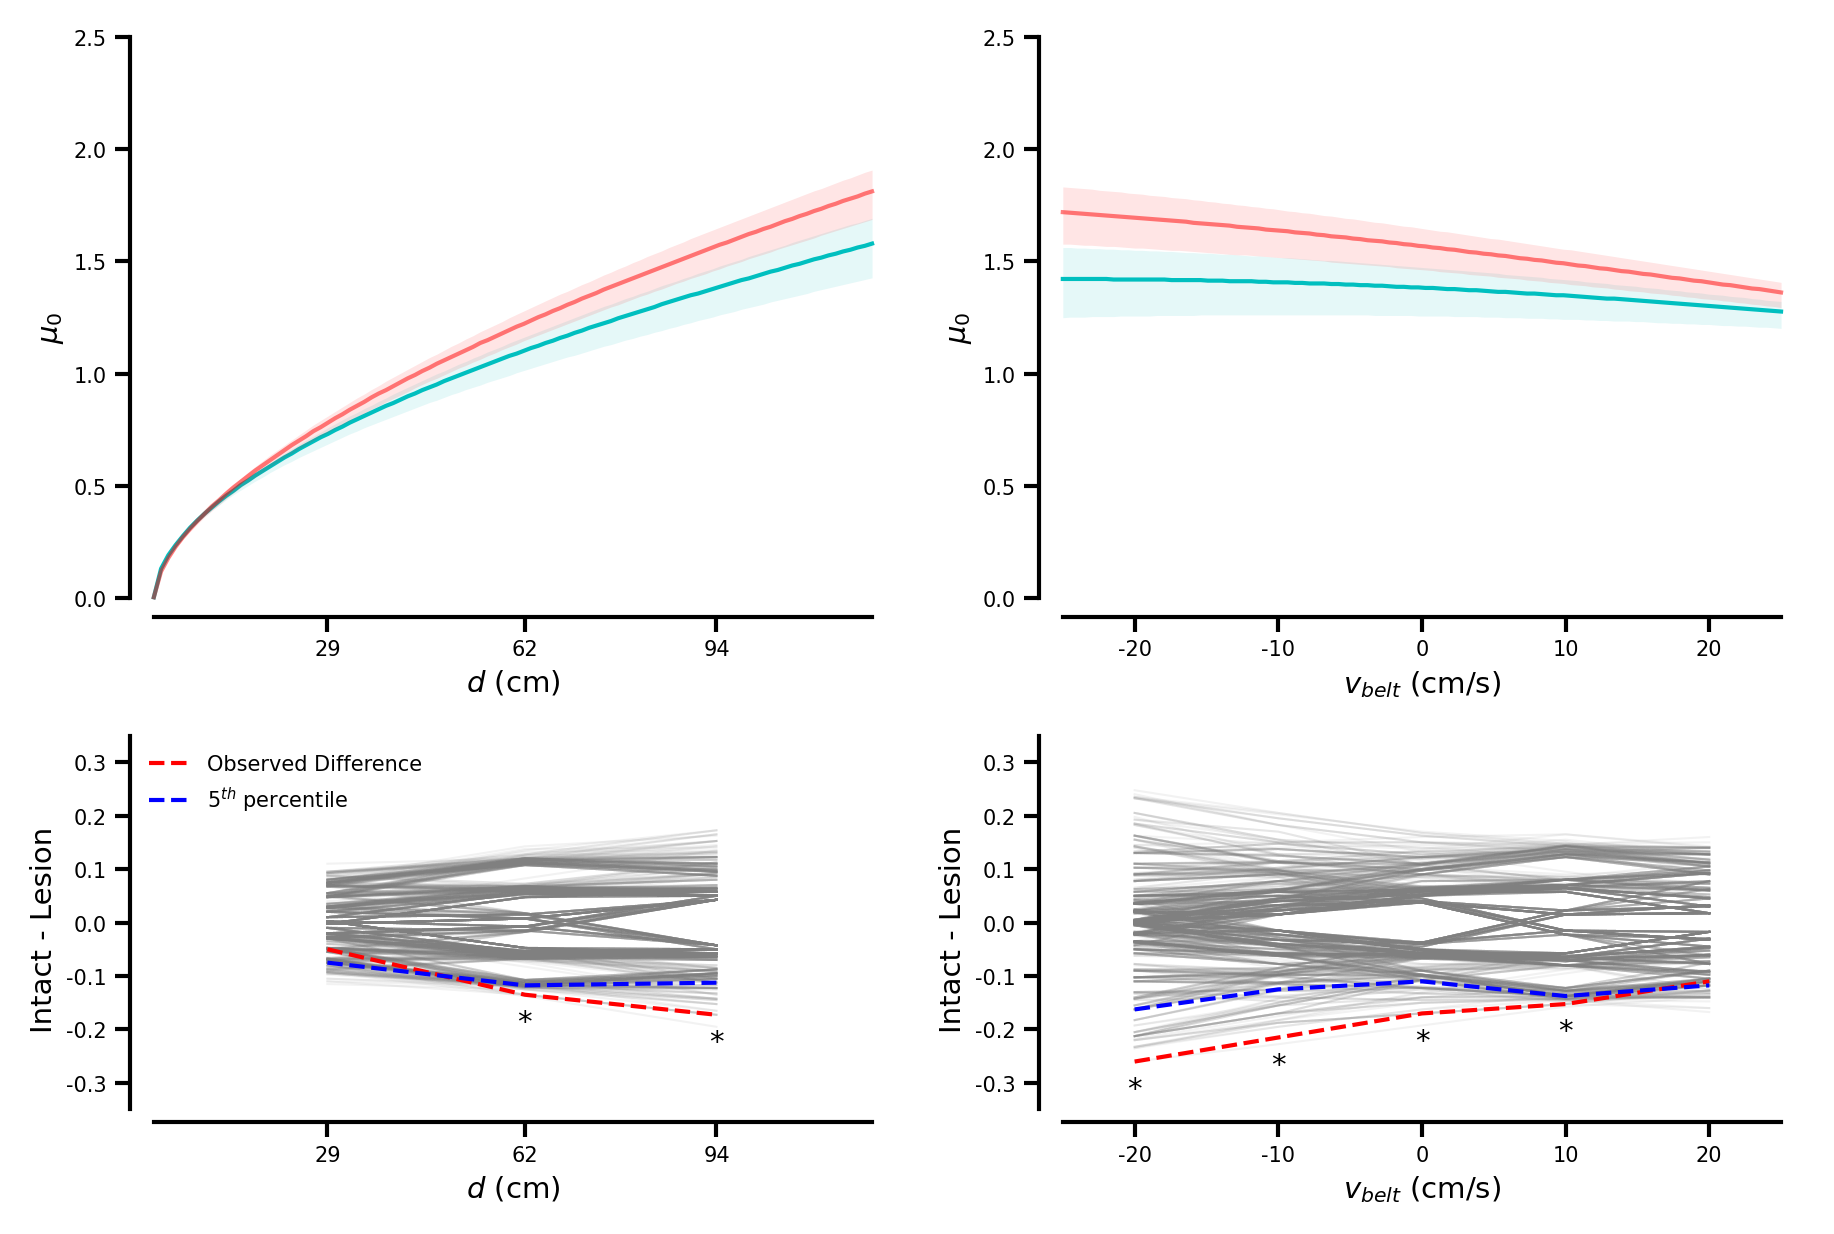

In [ ]:

# Topt as a function of D
def Figure3G(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(0, 1.2, 100)


    # plot median intact rat
    ax.plot(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for d in D], 
                    label=f'Median intact rats (n={len(animalList) - len(lesioned)})', c='c', lw=1, alpha=1, zorder=0)
    ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat - interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat - interquartile_power_intact_rat/2, power_time=3) for d in D],
                        [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat + interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat + interquartile_power_intact_rat/2, power_time=3) for d in D],
                        color='c', alpha=.1, lw=0, zorder=0)

    # plot median lesion rat
    ax.plot(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for d in D],
                    label=f'Example animal', c='r', lw=1, alpha=.5)
    ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat - interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat - interquartile_power_lesion_rat/2, power_time=3) for d in D],
                        [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat + interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat + interquartile_power_lesion_rat/2, power_time=3) for d in D],
                        label=f'Example animal', color='r', alpha=.1, lw=0)
    _ = r'$d$'
    ax.set_xlabel(f'{_} (cm)')
    ax.set_ylabel(r'$\mu_0$')
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([.29, .62, .94])
    ax.set_xticklabels([29, 62, 94])
    space_axes(ax)

    # handles, labels = ax.get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # ax.legend(*zip(*unique), loc='upper left',# bbox_to_anchor=(0.01, 0.99), 
    #                         frameon=True, fontsize=5, markerscale=1, 
    #                         edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)



# Topt as a function of Vbelt
def Figure3H(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(-.25, .25, 100)

    # plot median intact rat
    ax.plot(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for vbelt in VBELT], 
                    label=f'Example animal', c='c', lw=1, alpha=1, zorder=0)
    ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat - interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat - interquartile_power_intact_rat/2, power_time=3) for vbelt in VBELT],
                        [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat + interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat + interquartile_power_intact_rat/2, power_time=3) for vbelt in VBELT],
                        label=f'Example animal', color='c', alpha=.1, lw=0, zorder=0)

    # plot median lesion rat
    ax.plot(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for vbelt in VBELT],
                    label=f'Example animal', c='r', lw=1, alpha=.5)
    ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat - interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat - interquartile_power_lesion_rat/2, power_time=3) for vbelt in VBELT],
                        [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat + interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat + interquartile_power_lesion_rat/2, power_time=3) for vbelt in VBELT],
                        label=f'Example animal', color='r', alpha=.1, lw=0)
    _ = r'$d$'
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel(r'$\mu_0$')
    ax.set_xlim(-.25, 0.25)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([-.2, -.1, 0, .1, .2])
    ax.set_xticklabels([-20, -10, 0, 10, 20])
    space_axes(ax)


D = [.31, .63, .96]
VBELT = [-.2, -.1, 0, .1, .2]
Vbelt_cst = 0
D_cst = .94
group1_data = []
group2_data = []
for animal in animalList:
    if brainstatus[animal] == 'normal':
        # group1_data.append([mu_0[animal][cond] for cond in ['60', '90', '120', 'rev20', 'rev10', '2', '10', '20']])
        group1_data.append([T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D]+[T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT])
    else:
        # group2_data.append([mu_0[animal][cond] for cond in ['60', '90', '120', 'rev20', 'rev10', '2', '10', '20']])
        group2_data.append([T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D]+[T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT])

ngroup1 = len(group1_data)
num_permutations = 1000

observed_diff = np.median(group1_data, axis=0) - np.median(group2_data, axis=0)
permuted_diffs = np.zeros((num_permutations, 8))


for i in range(num_permutations):
    combined_data = np.concatenate([group1_data, group2_data], axis=0)
    np.random.shuffle(combined_data)

    permuted_diff = np.median(combined_data[:ngroup1], axis=0) - np.median(combined_data[ngroup1:], axis=0)
    permuted_diffs[i] = permuted_diff

p_values = np.mean(permuted_diffs <= observed_diff, axis=0)
print(p_values)


def plot_permutationDist(permuted_diffs, observed_diff, p_values, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    for i in range(len(permuted_diffs)):
        ax.plot([.29, .62, .94], permuted_diffs[i][0:3], alpha=0.1, color='gray', lw=0.5)
    
    ax.plot([.29, .62, .94], observed_diff[0:3], color='red', linestyle='--', label='Observed Difference')
    ax.plot([.29, .62, .94], np.percentile(permuted_diffs, 5, axis=0)[0:3], color='blue', linestyle='--', label=r'$5^{th}$ percentile')

    for i, (pos, p) in enumerate(zip([.29, .62, .94], p_values[0:3])):
        ax.annotate('*' if p < 0.05 else '', xy=(pos, observed_diff[i]), xytext=(pos, observed_diff[i]-0.025), fontsize=7, ha='center', va='top')

    ax.set_ylim(-0.35, 0.35)
    _ = r'$d$'
    ax.set_xlabel(f'{_} (cm)')
    ax.set_ylabel('Intact - Lesion')
    ax.set_xlim(0, 1.2)
    ax.set_xticks([.29, .62, .94])
    ax.set_xticklabels([29, 62, 94])
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left',# bbox_to_anchor=(0.01, 0.99), 
                            frameon=False, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)



def plot_permutationVbelt(permuted_diffs, observed_diff, p_values, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    for i in range(len(permuted_diffs)):
        ax.plot([-.2, -.1, 0, .1, .2], permuted_diffs[i][3:8], alpha=0.1, color='gray', lw=0.5)
    
    ax.plot([-.2, -.1, 0, .1, .2], observed_diff[3:8], color='red', linestyle='--', label='Observed Difference')
    ax.plot([-.2, -.1, 0, .1, .2], np.percentile(permuted_diffs, 5, axis=0)[3:8], color='blue', linestyle='--', label='5e percentile')

    for i, (pos, p) in enumerate(zip([-.2, -.1, 0, .1, .2], p_values[3:8])):
        ax.annotate('*' if p < 0.05 else '', xy=(pos, observed_diff[i+3]), xytext=(pos, observed_diff[i+3]-0.025), fontsize=7, ha='center', va='top')
    ax.set_ylim(-0.35, 0.35)
    _ = r'$d$'
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel('Intact - Lesion')
    ax.set_xlim(-.25, 0.25)
    ax.set_xticks([-.2, -.1, 0, .1, .2])
    ax.set_xticklabels([-20, -10, 0, 10, 20])
    space_axes(ax)

    
# fig, axs = plt.subplots(1, 2, figsize=(4, 1))
# plot_permutationDist(permuted_diffs, observed_diff, p_values, ax=axs[0])
# plot_permutationVbelt(permuted_diffs, observed_diff, p_values, ax=axs[1])



    
fig, axs = plt.subplots(2, 2, figsize=(6, 4), gridspec_kw={'height_ratios': [3, 2]})
Figure3G(ax=axs[0, 0])
Figure3H(ax=axs[0, 1])
plot_permutationDist(permuted_diffs, observed_diff, p_values, ax=axs[1, 0])
plot_permutationVbelt(permuted_diffs, observed_diff, p_values, ax=axs[1, 1])

In [ ]:
def plot_shuffle_difference(shuffles=np.random.randn(1000), observed=1, ylim=[-3, 3], xlim=[0, 1], ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    # half violin
    violin_parts = ax.violinplot(shuffles, positions=[0], showextrema=False, widths=0.5)
    for pc in violin_parts['bodies']:

        pc.set_facecolor('gray')
        pc.set_edgecolor('gray')
        pc.set_alpha(0.25)
        pc.set_linewidth(0)

    # observed
    ax.axhline(observed, 0, .5, color='red', linestyle='--', label='Observed Difference')

    ax.set_ylim(ylim)
    ax.set_ylabel('Intact - Lesion')
    ax.set_xlim(xlim)
    ax.set_xticks([])
    ax.spines['bottom'].set_visible(False)

plot_shuffle_difference()

Observed Slope: 106.7422
P-value: 0.0099
Observed Slope: 22.4002
P-value: 0.2676
Observed Slope: 22.2001
P-value: 0.2015
Observed Slope: -0.0102
P-value: 0.9907
Observed Slope: 1.7459
P-value: 0.2815
Observed Slope: -0.3713
P-value: 0.0764
Observed Slope: 0.1178
P-value: 0.7950
Observed Slope: -1.3507
P-value: 0.1307
Observed Slope: 0.0925
P-value: 0.4836
Observed Slope: 0.1799
P-value: 0.4412
Observed Slope: 1.8881
P-value: 0.0012
Observed Slope: -0.0663
P-value: 0.6384
Observed Slope: 0.2070
P-value: 0.1954
Observed Slope: -0.0000
P-value: 1.0000
Observed Slope: -0.0000
P-value: 1.0000
Observed Slope: -0.0000
P-value: 1.0000


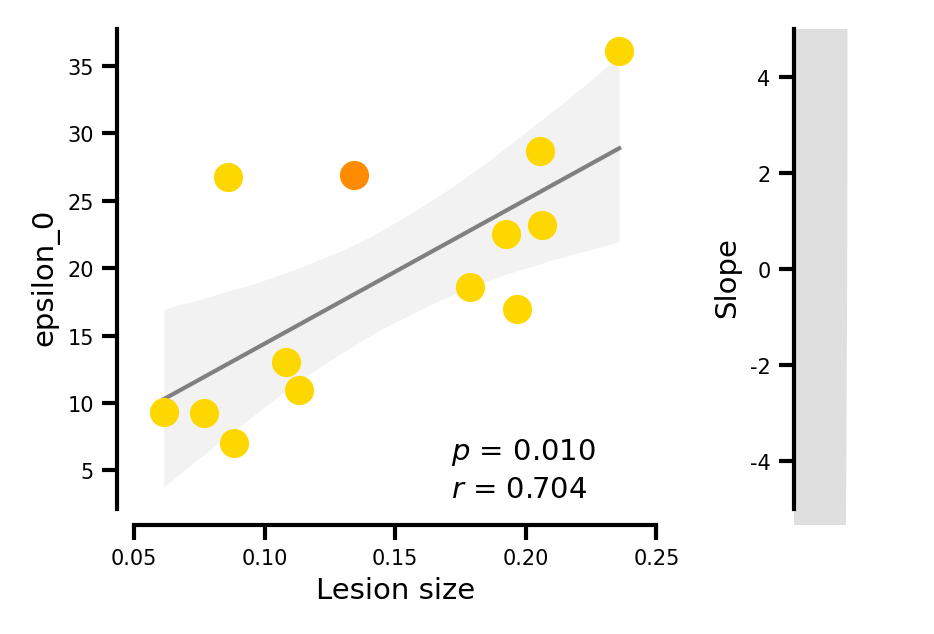

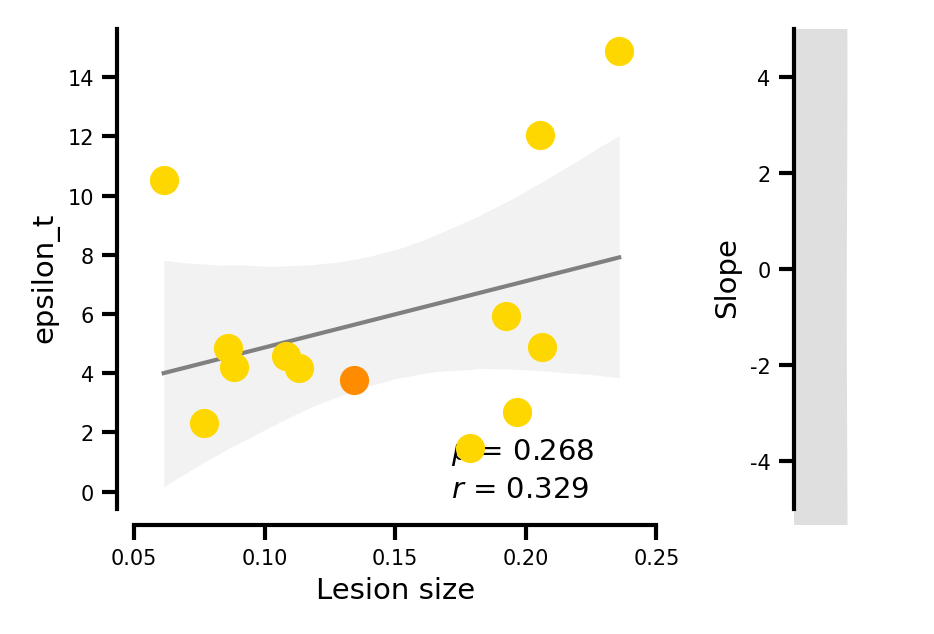

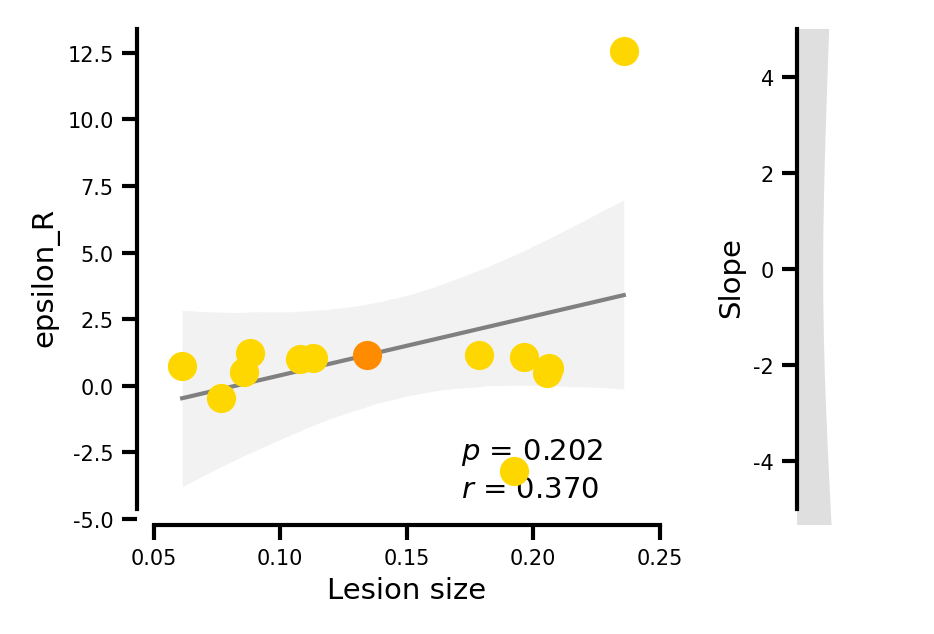

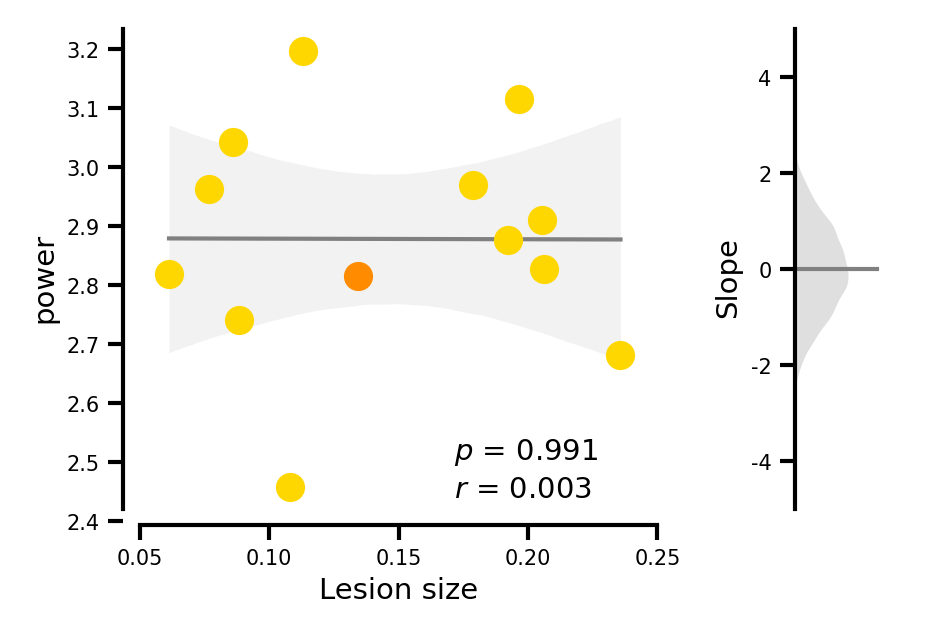

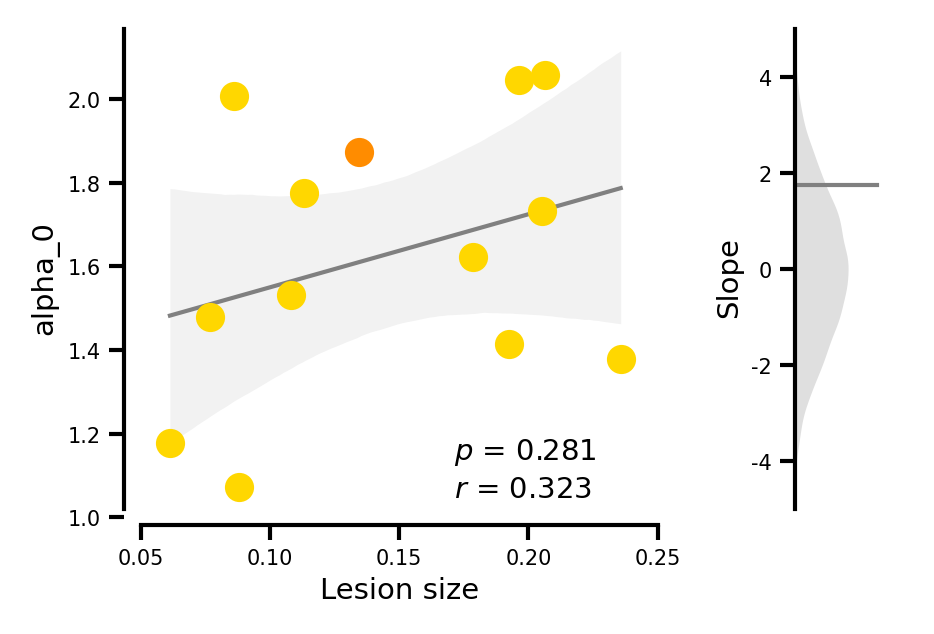

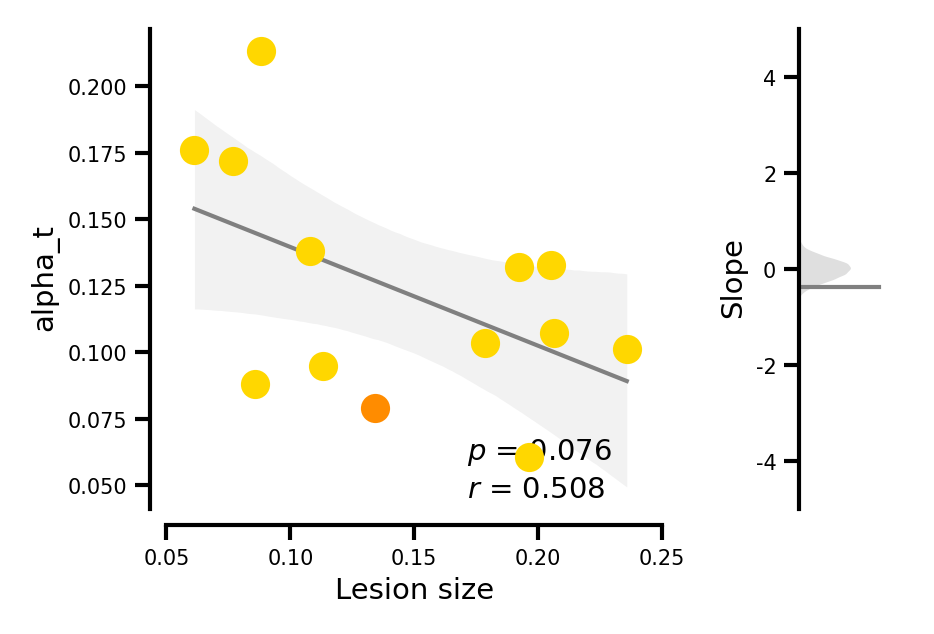

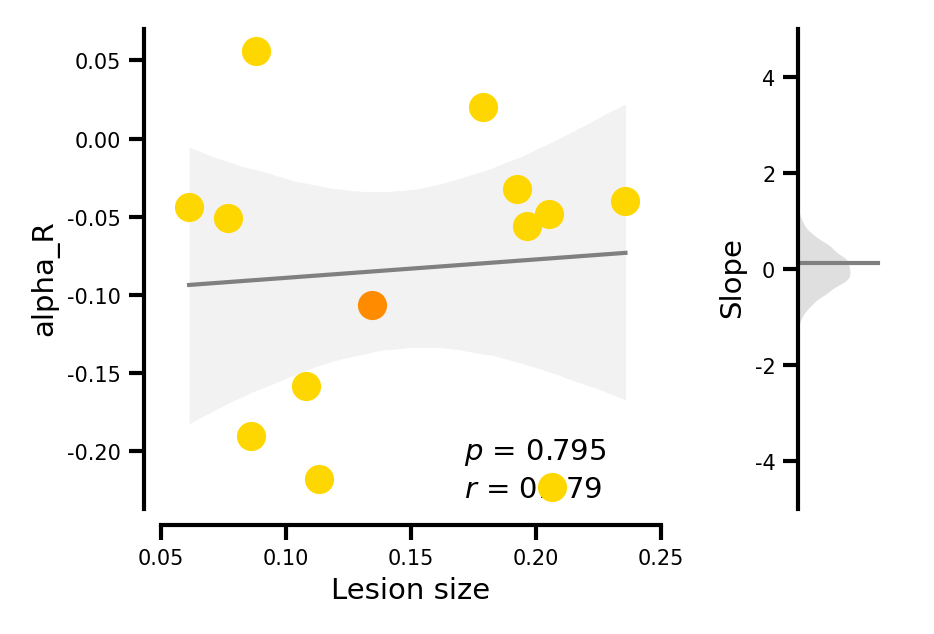

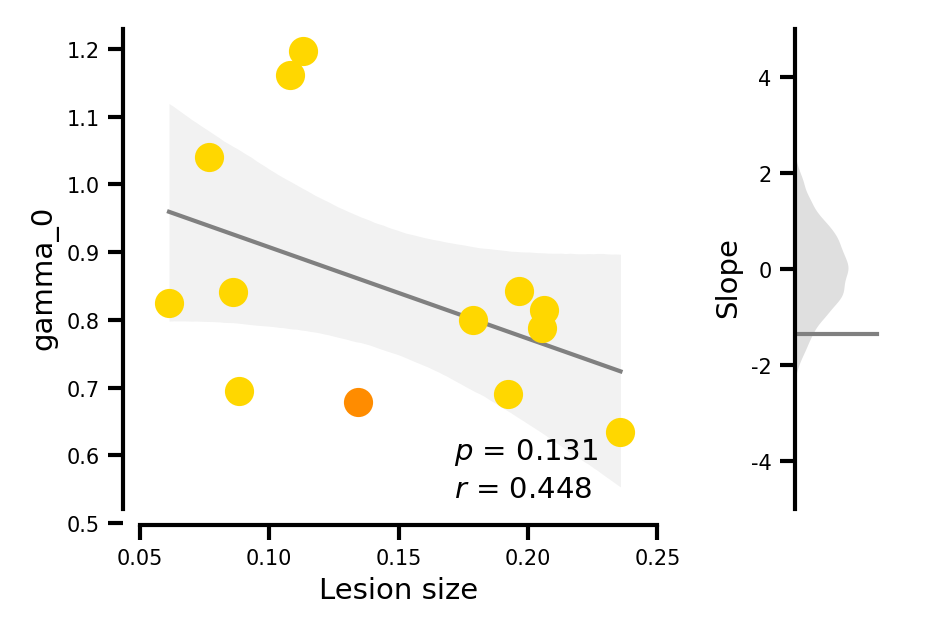

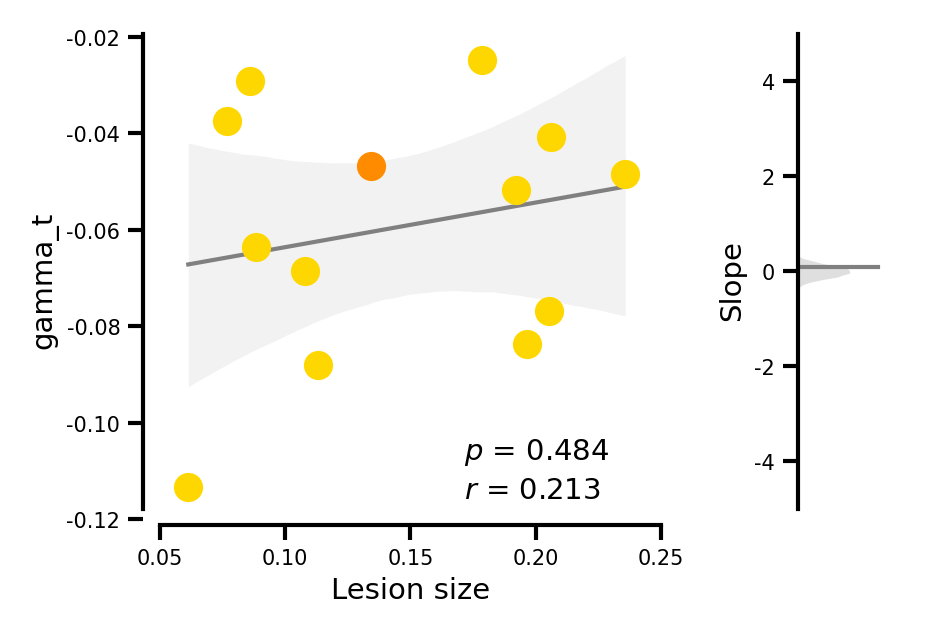

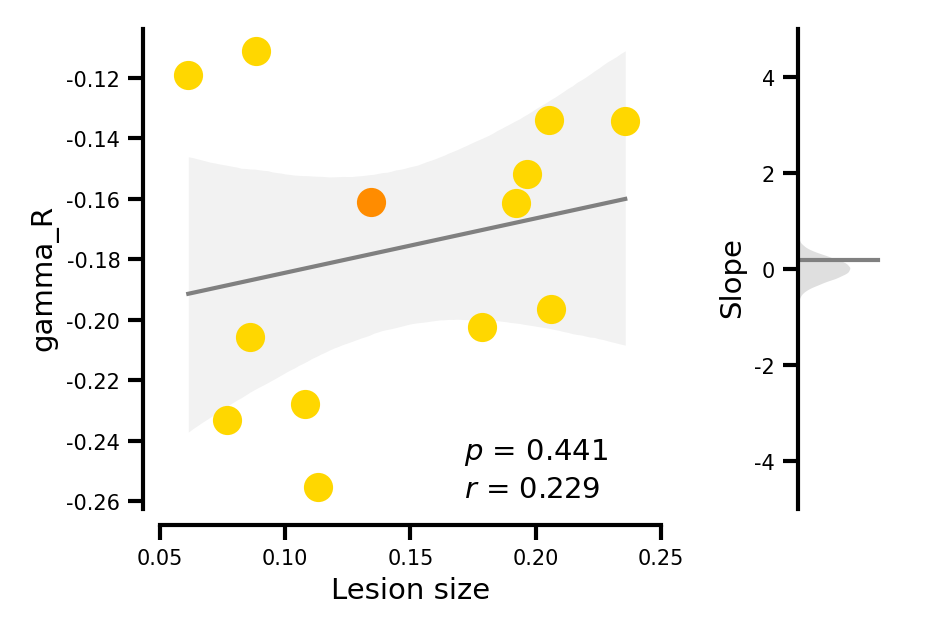

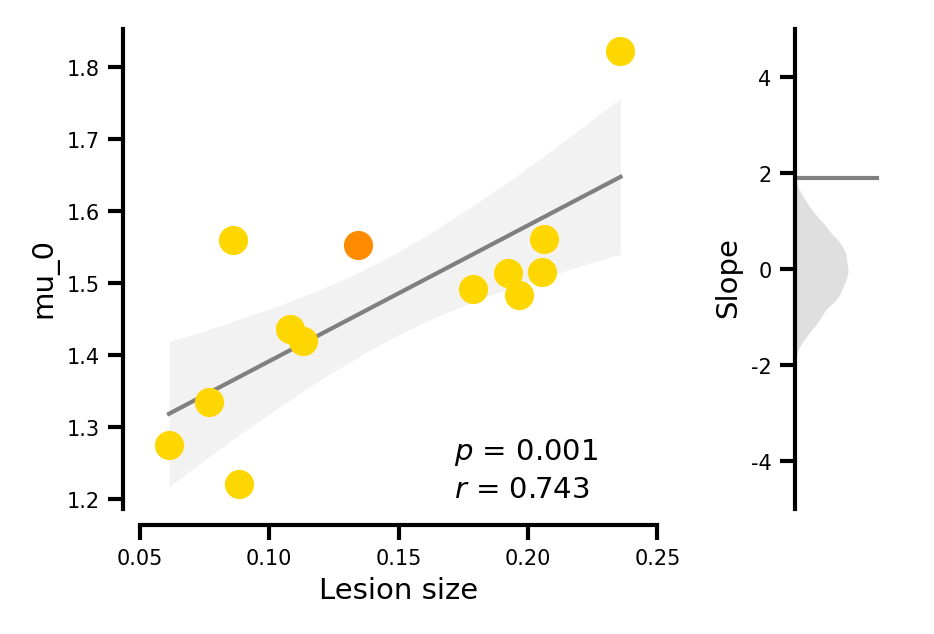

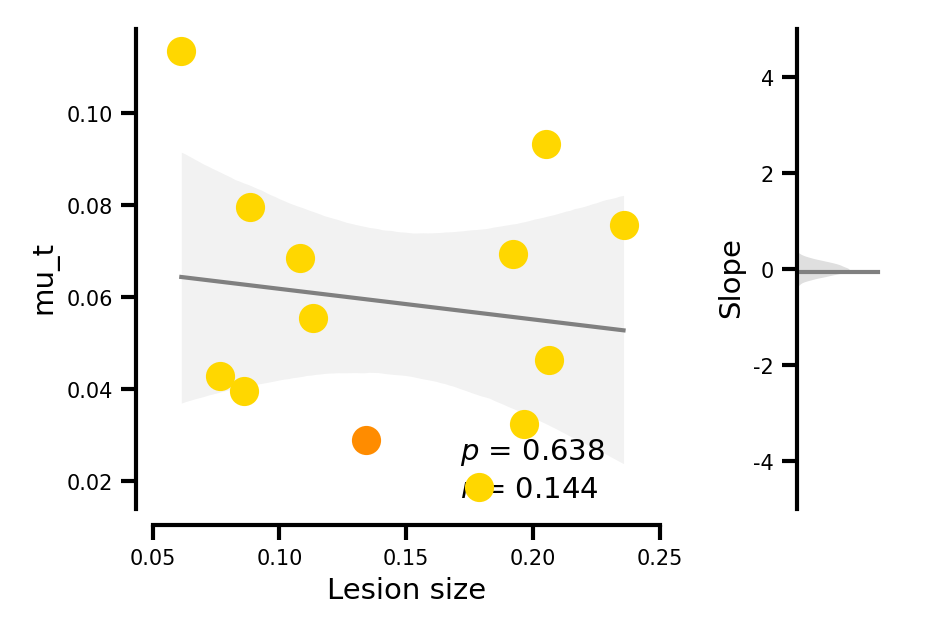

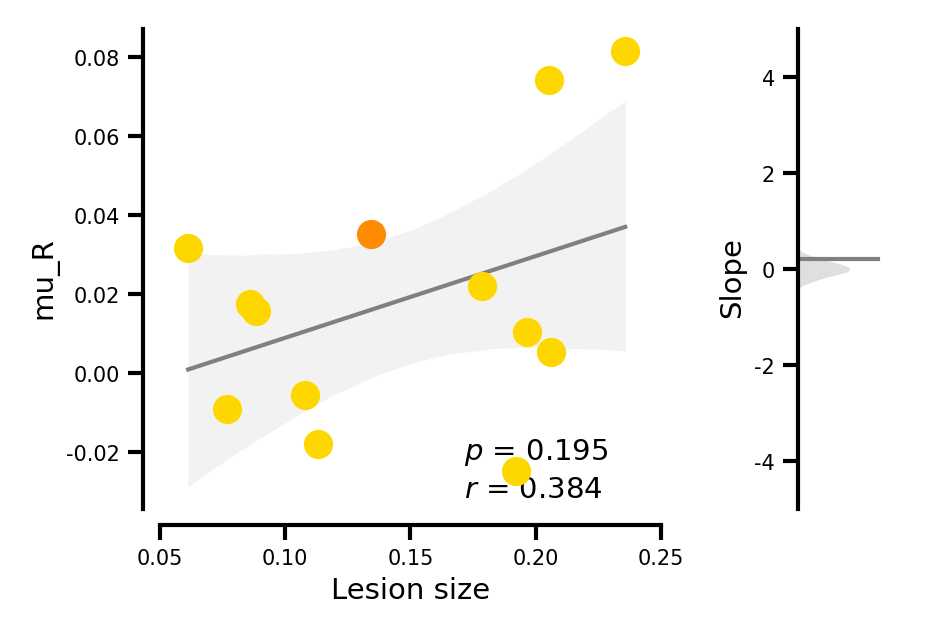

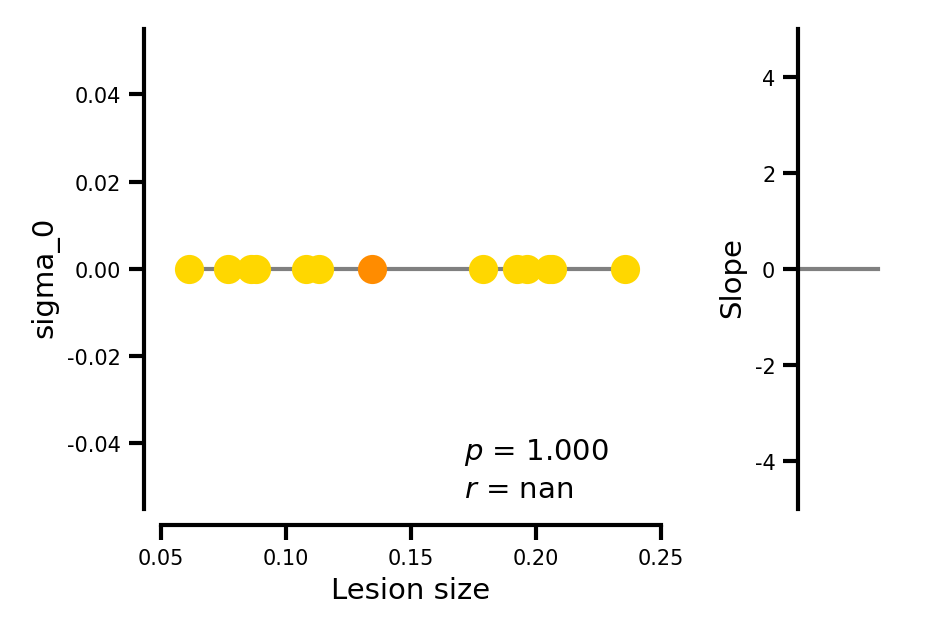

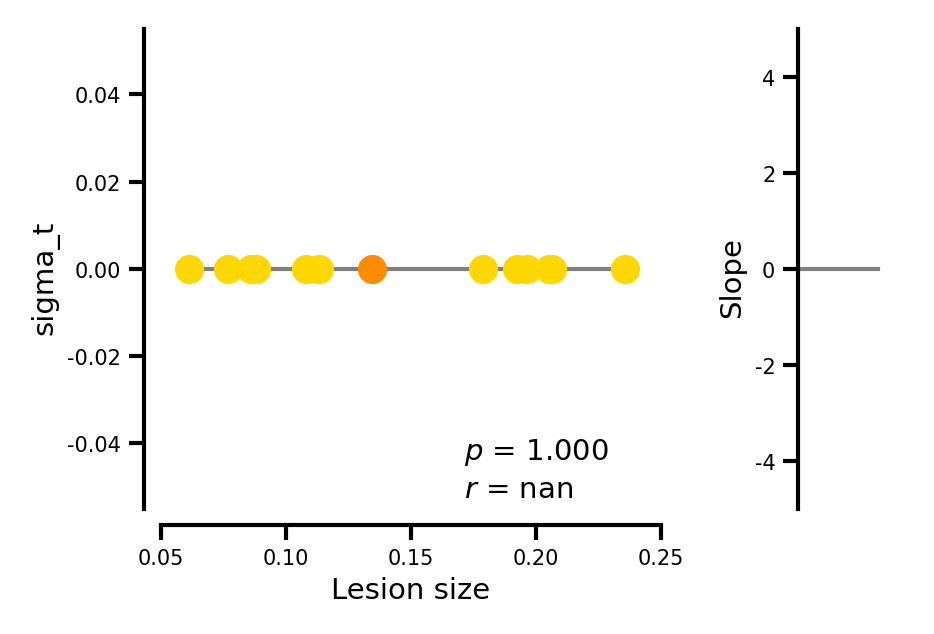

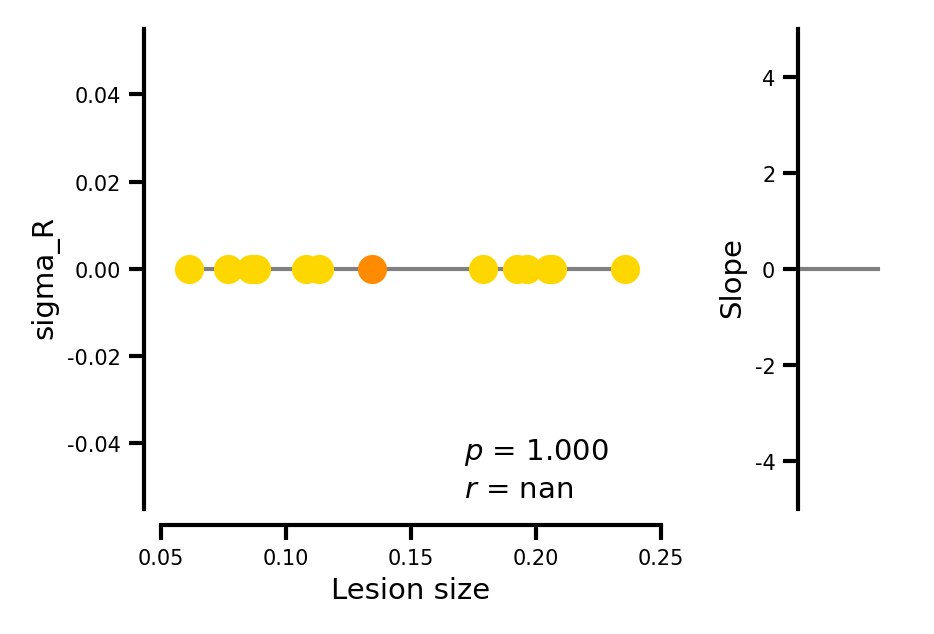

In [ ]:
from scipy.optimize import curve_fit

def Figure6_Ib(var, name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_area[animal], var[animal], color=rat_markers[animal][0], zorder=10)
        x.append(lesion_area[animal])
        y.append(var[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # calculate confidence intervals for fitted line
    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000)
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0)
    upper = np.percentile(ysample, 97.5, axis=0)

    # plot the regression and confidence intervals
    y_fit = np.poly1d(p)(xi)
    ax.plot(xi, y_fit, color='gray', zorder=1)
    ax.fill_between(xi, lower, upper, color='gray', alpha=.1, zorder=0, lw=0)


    # shuffle to get p-value
    observed_slope = p[0]
    num_iterations = 10000
    shuffled_slopes = []

    np.random.seed(0)
    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        p_shuffled, _ = curve_fit(f, x, shuffled_y, [1, 1])
        shuffled_slope = p_shuffled[0]
        shuffled_slopes.append(shuffled_slope)

    # Calculate the p-value
    p_value = (np.abs(shuffled_slopes) >= np.abs(observed_slope)).mean()

    # compute r
    y_mean = np.mean(y)
    y_pred = f(x, *p)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_total)
    r = np.sqrt(r_squared)

    # pvalue annotation
    ax.annotate(f"$p$ = {p_value:.3f}", xy=(.60, .18), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.3f}", xy=(.60, .1), xycoords='axes fraction', fontsize=7, ha='left', va='top')

    ax.set_xlabel('Lesion size')
    ax.set_xlim(0.05, .25)
    ax.set_ylabel(name)
    # ax.set_ylim(2, 4)
    space_axes(ax)
    
    print(f"Observed Slope: {observed_slope:.4f}")
    print(f"P-value: {p_value:.4f}")

    return shuffled_slopes, observed_slope

effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, power = pickle.load(open('picklejar/effort_sensitivity_fit.p', 'rb'))
alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
alpha_0 = {animal: np.median([alpha_0[animal][cond] for cond in conds]) for animal in lesioned}
alpha_t = {animal: np.median([alpha_t[animal][cond] for cond in conds]) for animal in lesioned}
alpha_u = {animal: np.median([alpha_u[animal][cond] for cond in conds]) for animal in lesioned}
gamma_0 = {animal: np.median([gamma_0[animal][cond] for cond in conds]) for animal in lesioned}
gamma_t = {animal: np.median([gamma_t[animal][cond] for cond in conds]) for animal in lesioned}
gamma_u = {animal: np.median([gamma_u[animal][cond] for cond in conds]) for animal in lesioned}
mu_0 = {animal: np.median([mu_0[animal][cond] for cond in conds]) for animal in lesioned}
mu_t = {animal: np.median([mu_t[animal][cond] for cond in conds]) for animal in lesioned}
mu_u = {animal: np.median([mu_u[animal][cond] for cond in conds]) for animal in lesioned}
sigma_0 = {animal: np.median([sigma_0[animal][cond] for cond in conds]) for animal in lesioned}
sigma_t = {animal: np.median([sigma_t[animal][cond] for cond in conds]) for animal in lesioned}
sigma_u = {animal: np.median([sigma_u[animal][cond] for cond in conds]) for animal in lesioned}

vars = [effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_u, power, alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u]
names = ['effort_sensitivity_0', 'effort_sensitivity_t', 'effort_sensitivity_u', 'power', 'alpha_0', 'alpha_t', 'alpha_u', 'gamma_0', 'gamma_t', 'gamma_u', 'mu_0', 'mu_t', 'mu_u', 'sigma_0', 'sigma_t', 'sigma_u']


for var, name in zip(vars, names):

    fig, axs = plt.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios': [5, 1]})
    shuffled_slopes, observed_slope = Figure6_Ib(var, name, ax=axs[0])
    plot_shuffling(shuffles=shuffled_slopes, observed=observed_slope, ylim=[-5, 5], ax=axs[1], ylabel='Slope')

In [ ]:

def Figure_6BLeft(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(1, 1))

    x_striatum_left, y_striatum_left = [], []
    x_lesion_left, y_lesion_left = [], []
    
    for animal in lesioned:
        animalFolder = histologyroot + '/' + animal
        slices = glob.glob(animalFolder + '/slice*.czi')

        for slice in slices:
            x = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x)
            offset_y = np.mean(y)
            # offset_x = np.max(x)
            # offset_y = np.max(y)

            ax.plot(x - offset_x, y - offset_y, 'k', alpha=0.2)
            x_striatum_left.append(x - offset_x)
            y_striatum_left.append(y - offset_y)

            x_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, 
                              True, facecolor='r', alpha=.075)
            # ax.add_patch(polygon)

            ax.plot(x_lesion - offset_x, y_lesion - offset_y, 'r', alpha=0.2)
            x_lesion_left.append(x_lesion - offset_x)
            y_lesion_left.append(y_lesion - offset_y)

            
    stat = 'Med.' #'Avg.' #'Med.'
    x, y = compute_median_contour(x_striatum_left, y_striatum_left, stat=stat)

    # ax.plot(x, y, 'k', lw=2)
    ax.plot(*smooth_polygon(x, y, num_points=25), 'k', lw=1)
    
    ax.set_xlim(-2100, 1600)
    ax.set_ylim(-2000, 1700)
    ax.axis('off')

def Figure_6BRight(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(1, 1))

    x_striatum_right, y_striatum_right = [], []
    x_lesion_right, y_lesion_right = [], []

    for animal in lesioned:
        animalFolder = histologyroot + '/' + animal
        slices = glob.glob(animalFolder + '/slice*.czi')

        for slice in slices:

            x = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x)
            offset_y = np.mean(y)
            # offset_x = np.max(x)
            # offset_y = np.max(y)

            ax.plot(x - offset_x, y - offset_y, 'k', alpha=0.2)
            x_striatum_right.append(x - offset_x)
            y_striatum_right.append(y - offset_y)


            x_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, 
                              True, facecolor='r', alpha=.075)
            ax.add_patch(polygon)

            # axs[i, 1].plot(x_lesion - offset_x, y_lesion - offset_y, 'r', alpha=0.2)
            x_lesion_right.append(x_lesion - offset_x)
            y_lesion_right.append(y_lesion - offset_y)

    stat = 'Med.' #'Avg.' #'Med.'
    x, y = compute_median_contour(x_striatum_right, y_striatum_right, stat=stat)
    # ax.plot(x, y, 'k', lw=2)
    ax.plot(*smooth_polygon(x, y, num_points=25), 'k', lw=1)
    ax.set_xlim(-1600, 2100)
    ax.set_ylim(-2000, 1700)
    ax.axis('off')


fig, axs = plt.subplots(1, 2, figsize=(4, 2))
Figure_6BLeft(axs[0])
Figure_6BRight(axs[1])

In [ ]:
# Topt as a function of D
def Figure3Fbottom(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(.29, .94, 100)


    # plot median intact rat
    ax.plot(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for d in D], 
                    label=f'Median intact rats (n={len(animalList) - len(lesioned)})', c='b', alpha=1, zorder=0)
    ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat - interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat - interquartile_power_intact_rat/2, power_time=3) for d in D],
                        [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_intact_rat + interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat + interquartile_power_intact_rat/2, power_time=3) for d in D],
                        color='b', alpha=.33, lw=0, zorder=0)

    # plot median lesion rat
    ax.plot(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for d in D],
                    label=f'Median lesion rats (n={len(lesioned)})', c='goldenrod', alpha=1)
    ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat - interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat - interquartile_power_lesion_rat/2, power_time=3) for d in D],
                        [T_opt_n(d, Vbelt_cst, median_effort_sensitivity_lesion_rat + interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat + interquartile_power_lesion_rat/2, power_time=3) for d in D],
                        color='gold', alpha=1, lw=0)



    # plot pvalues
    _, _, p_values = pickle.load(open('picklejar/fig6_permutation.p', 'rb'))
    p_values = np.array(p_values[0:3])  # first 3 values are for D

    for x, p in zip([.31, .63, .94], p_values):
        if p < .05:
            y = T_opt_n(x, Vbelt_cst, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3)
            ax.text(x, y + .25, stars(p), fontsize=7, ha='center', va='center')
    
    
    _ = r'$d$'
    ax.set_xlabel(f'{_} (cm)')
    ax.set_ylabel('Crossing duration (s)')
    ax.set_xlim(.29, .94)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([.29, .62, .94])
    ax.set_xticklabels([29, 62, 94])
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper center', bbox_to_anchor=(0.5, 1.33), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


# Topt as a function of Vbelt
def Figure3Gbottom(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(-.2, .2, 100)

    # plot median intact rat
    ax.plot(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat, power_effort=median_power_intact_rat, power_time=3) for vbelt in VBELT], 
                    c='b', alpha=1, zorder=0)
    ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat - interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat - interquartile_power_intact_rat/2, power_time=3) for vbelt in VBELT],
                        [T_opt_n(D_cst, vbelt, median_effort_sensitivity_intact_rat + interquartile_effort_sensitivity_intact_rat/2, power_effort=median_power_intact_rat + interquartile_power_intact_rat/2, power_time=3) for vbelt in VBELT],
                        color='b', alpha=.33, lw=0, zorder=0)

    # plot median lesion rat
    ax.plot(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3) for vbelt in VBELT],
                    c='goldenrod', alpha=1)
    ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat - interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat - interquartile_power_lesion_rat/2, power_time=3) for vbelt in VBELT],
                        [T_opt_n(D_cst, vbelt, median_effort_sensitivity_lesion_rat + interquartile_effort_sensitivity_lesion_rat/2, power_effort=median_power_lesion_rat + interquartile_power_lesion_rat/2, power_time=3) for vbelt in VBELT],
                        color='gold', alpha=1, lw=0)
    _ = r'$d$'
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel('Crossing duration (s)')
    ax.set_xlim(-.2, 0.2)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([-.2, -.1, 0, .1, .2])
    ax.set_xticklabels([-20, -10, 0, 10, 20])
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)

    # plot pvalues
    _, _, p_values = pickle.load(open('picklejar/fig6_permutation.p', 'rb'))
    p_values = np.array(p_values[3:])  # last 5 values are for Vbelt

    for x, p in zip([-.2, -.1, 0, .1, .2], p_values):
        if p < .05:
            y = T_opt_n(D_cst, x, median_effort_sensitivity_lesion_rat, power_effort=median_power_lesion_rat, power_time=3)
            ax.text(x, y + .25, stars(p), fontsize=7, ha='center', va='center')


    
fig, axs = plt.subplots(1, 2, figsize=(cm2inch(9), cm2inch(3)))
Figure3Fbottom(ax=axs[0])
Figure3Gbottom(ax=axs[1])

In [ ]:
def Figure_6B(ax=None):
    # lesioned = [rat_example_lesion]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(1, 1))

    x_striatum_left, y_striatum_left = [], []
    x_lesion_left, y_lesion_left = [], []
    
    for animal in lesioned:
        if brainstatus[animal] == 'DMS':
            continue
        animalFolder = histologyroot + '/' + animal
        slices = glob.glob(animalFolder + '/slice*.czi')

        for slice in [slices[0]]:
            print(slice)
            x = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x) + 1250
            offset_y = np.mean(y)
            x_striatum_left.append(x - offset_x)
            y_striatum_left.append(y - offset_y)

            ax.plot(x - offset_x, y - offset_y, 'k', alpha=0.2, lw=.5)

            x_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, 
                              True, facecolor='g' if brainstatus[animal] == 'DMS' else 'c', alpha=.075)
            ax.add_patch(polygon)

            # ax.plot(x_lesion - offset_x, y_lesion - offset_y, 'r', alpha=0.2)
            x_lesion_left.append(x_lesion - offset_x)
            y_lesion_left.append(y_lesion - offset_y)


            cx, cy = compute_centroid(read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv'))
            cx -= offset_x
            cy = -cy - offset_y
            ax.scatter(cx, cy, s=10, marker='+', zorder=10, c='g' if brainstatus[animal] == 'DMS' else 'r')

            

    x_striatum_right, y_striatum_right = [], []
    x_lesion_right, y_lesion_right = [], []

    for animal in lesioned:
        animalFolder = histologyroot + '/' + animal
        slices = glob.glob(animalFolder + '/slice*.czi')

        for slice in slices:

            x = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x) - 1250
            offset_y = np.mean(y)
            ax.plot(x - offset_x, y - offset_y, 'k', alpha=0.2, lw=.5)
            x_striatum_right.append(x - offset_x)
            y_striatum_right.append(y - offset_y)


            x_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, 
                              True, facecolor='g' if brainstatus[animal] == 'DMS' else 'c', alpha=.075)
            ax.add_patch(polygon)

            # axs[i, 1].plot(x_lesion - offset_x, y_lesion - offset_y, 'r', alpha=0.2)
            x_lesion_right.append(x_lesion - offset_x)
            y_lesion_right.append(y_lesion - offset_y)

            cx, cy = compute_centroid(read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv'))
            cx -= offset_x
            cy = -cy - offset_y
            ax.scatter(cx, cy, s=10, marker='+', zorder=10, c='g' if brainstatus[animal] == 'DMS' else 'r')


    stat = 'Med.' #'Avg.' #'Med.'
    x_left, y_left = compute_median_contour(x_striatum_left, y_striatum_left, stat=stat)
    ax.plot(*smooth_polygon(x_left, y_left, num_points=25), 'k', lw=1)
    print(list(smooth_polygon(x_left, y_left, num_points=25)))

    x_right, y_right = compute_median_contour(x_striatum_right, y_striatum_right, stat=stat)
    # ax.plot(x, y, 'k', lw=2)
    ax.plot(*smooth_polygon(x_right, y_right, num_points=25), 'k', lw=1)

    
    ax.set_xlim(-3000, 3000)  # 6000
    ax.set_ylim(-2150, 1850)  # 4000
    # ratio x/y is 1.5
    ax.axis('off')

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
Figure_6B(ax)

xx = [ -769, -1090, -1394, -1655, -1886, -2141, -2278, -2363, -2356, -2260, -2103, -1903, 
       -1633, -1361, -1088 ,  -889, -662,  -580,  -492,  -444 , -438,  -450,  -500 ,  -580, -650,  -769]

yy = [ 1300,  1300,  1200,   1050, 800,   449,   180,  -102, -423,  -852, -1105, -1333,
       -1437, -1448, -1322, -1142, -942,  -711,  -451,  -213, 73,   428,   728,   986, 1177,  1300]

ax.plot(xx, yy, 'r', lw=1)

xx = [ 769, 1090, 1394, 1655, 1886, 2141, 2278, 2363, 2356, 2260, 2103, 1903, 
       1633, 1361, 1088 , 889, 662, 580, 492, 444 , 438, 450, 500 , 580, 650, 769]

yy = [ 1300,  1300,  1200,   1050, 800,   449,   180,  -102, -423,  -852, -1105, -1333,
       -1437, -1448, -1322, -1142, -942,  -711,  -451,  -213, 73,   428,   728,   986, 1177,  1300]
ax.plot(xx, yy, 'r', lw=1)

In [ ]:
def Figure_6B(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(1, 1))

    x_striatum_left, y_striatum_left = [], []
    x_lesion_left, y_lesion_left = [], []
    
    for animal in lesioned:
        animalFolder = histologyroot + '/' + animal
        slices = glob.glob(animalFolder + '/slice*.czi')

        for slice in slices:
            x = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x) + 1250
            offset_y = np.mean(y)
            # offset_x = np.max(x)
            # offset_y = np.max(y)

            ax.plot(x - offset_x, y - offset_y, 'k', alpha=0.2, lw=.5)
            x_striatum_left.append(x - offset_x)
            y_striatum_left.append(y - offset_y)

            x_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, 
                              True, facecolor='r', alpha=.075)
            ax.add_patch(polygon)

            # ax.plot(x_lesion - offset_x, y_lesion - offset_y, 'r', alpha=0.2)
            x_lesion_left.append(x_lesion - offset_x)
            y_lesion_left.append(y_lesion - offset_y)

            

    x_striatum_right, y_striatum_right = [], []
    x_lesion_right, y_lesion_right = [], []

    for animal in lesioned:
        animalFolder = histologyroot + '/' + animal
        slices = glob.glob(animalFolder + '/slice*.czi')

        for slice in slices:

            x = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x) - 1250
            offset_y = np.mean(y)
            # offset_x = np.max(x)
            # offset_y = np.max(y)

            ax.plot(x - offset_x, y - offset_y, 'k', alpha=0.2, lw=.5)
            x_striatum_right.append(x - offset_x)
            y_striatum_right.append(y - offset_y)


            x_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, 
                              True, facecolor='r', alpha=.075)
            ax.add_patch(polygon)

            # axs[i, 1].plot(x_lesion - offset_x, y_lesion - offset_y, 'r', alpha=0.2)
            x_lesion_right.append(x_lesion - offset_x)
            y_lesion_right.append(y_lesion - offset_y)


    stat = 'Med.' #'Avg.' #'Med.'
    x_left, y_left = compute_median_contour(x_striatum_left, y_striatum_left, stat=stat)
    ax.plot(*smooth_polygon(x_left, y_left, num_points=25), 'w', lw=1)

    x_right, y_right = compute_median_contour(x_striatum_right, y_striatum_right, stat=stat)
    # ax.plot(x, y, 'k', lw=2)
    ax.plot(*smooth_polygon(x_right, y_right, num_points=25), 'w', lw=1)

    
    # ax.set_xlim(-2875, 2875)  # 5550
    # ax.set_ylim(-2000, 1700)  # 3700
    ax.set_xlim(-3000, 3000)  # 6000
    ax.set_ylim(-2150, 1850)  # 4000
    # ratio x/y is 1.5
    ax.axis('off')

fig, ax = plt.subplots(1, 1, figsize=(1, .66))
Figure_6B(ax)

In [ ]:
def Figure_6B(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(1, 1))

    x_striatum_left, y_striatum_left = [], []
    x_lesion_left, y_lesion_left = [], []
    stat = 'Med.'
    for animal in lesioned:
        animalFolder = histologyroot + '/' + animal
        slices = glob.glob(animalFolder + '/slice*.czi')
        # slices = [slices[-1]]

        average_lesion_left_x = []
        average_lesion_left_y = []

        for slice in slices:

            x = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis



            offset_x = np.mean(x) + 1250
            offset_y = np.mean(y)
            # offset_x = np.max(x)
            # offset_y = np.max(y)

            # ax.plot(x - offset_x, y - offset_y, 'k', alpha=0.2, lw=.5)
            x_striatum_left.append(x - offset_x)
            y_striatum_left.append(y - offset_y)


            cx, cy = compute_centroid(read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv'))
            cx -= offset_x
            cy = -cy - offset_y
            # ax.scatter(cx, cy, s=10, marker='+', zorder=10, c='g' if brainstatus[animal] == 'DMS' else 'c')


            x_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, 
                              True, facecolor='r', alpha=.075)
            # ax.add_patch(polygon)

            # ax.plot(x_lesion - offset_x, y_lesion - offset_y, alpha=0.2, lw=.5)
            x_lesion_left.append(x_lesion - offset_x)
            y_lesion_left.append(y_lesion - offset_y)
            average_lesion_left_x.append(x_lesion - offset_x)
            average_lesion_left_y.append(y_lesion - offset_y)

        x_left, y_left = compute_median_contour(average_lesion_left_x, average_lesion_left_y, stat=stat)
        # ax.plot(x_left, y_left, 'r', lw=1, alpha=.25)
        # ax.plot(*smooth_polygon(x_left, y_left, num_points=15), 'r', lw=1)
        polygon = Polygon(np.array([x_left, y_left]).T, True, facecolor='r', alpha=.075)
        ax.add_patch(polygon)
        cx, cy = compute_centroid(np.array([x_left, y_left]).T)
        ax.scatter(cx, cy, s=10, marker='+', zorder=10, c='g' if brainstatus[animal] == 'DMS' else 'c')

    x_striatum_right, y_striatum_right = [], []
    x_lesion_right, y_lesion_right = [], []

    for animal in lesioned:
        animalFolder = histologyroot + '/' + animal
        slices = glob.glob(animalFolder + '/slice*.czi')
        # slices = [slices[-1]]

        average_lesion_right_x = []
        average_lesion_right_y = []

        for slice in slices:

            x = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 0]
            y = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')[:, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            y = -y  # flip y axis

            offset_x = np.mean(x) - 1250
            offset_y = np.mean(y)
            # offset_x = np.max(x) - 1250
            # offset_y = np.max(y)

            # ax.plot(x - offset_x, y - offset_y, 'k', alpha=0.2, lw=.5)
            x_striatum_right.append(x - offset_x)
            y_striatum_right.append(y - offset_y)


            x_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 0]
            y_lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')[:, 1]
            x_lesion = np.append(x_lesion, x_lesion[0])
            y_lesion = np.append(y_lesion, y_lesion[0])
            y_lesion = -y_lesion  # flip y axis

            polygon = Polygon(np.array([x_lesion - offset_x, y_lesion - offset_y]).T, 
                              True, facecolor='r', alpha=.075)
            # ax.add_patch(polygon)

            cx, cy = compute_centroid(read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv'))
            cx -= offset_x
            cy = -cy - offset_y
            # ax.scatter(cx, cy, s=10, marker='+', zorder=10, c='g' if brainstatus[animal] == 'DMS' else 'c')

            # ax.plot(x_lesion - offset_x, y_lesion - offset_y, alpha=0.2)
            x_lesion_right.append(x_lesion - offset_x)
            y_lesion_right.append(y_lesion - offset_y)
            average_lesion_right_x.append(x_lesion - offset_x)
            average_lesion_right_y.append(y_lesion - offset_y)

        x_left, y_left = compute_median_contour(average_lesion_right_x, average_lesion_right_y, stat=stat)
        # ax.plot(*smooth_polygon(x_left, y_left, num_points=15), 'r', lw=1)

        polygon = Polygon(np.array([x_left, y_left]).T, True, facecolor='r', alpha=.075)
        ax.add_patch(polygon)
        cx, cy = compute_centroid(np.array([x_left, y_left]).T)
        ax.scatter(cx, cy, s=10, marker='+', zorder=10, c='g' if brainstatus[animal] == 'DMS' else 'c')



    stat = 'Med.' #'Avg.' #'Med.'
    x_left, y_left = compute_median_contour(x_striatum_left, y_striatum_left, stat=stat)
    ax.plot(*smooth_polygon(x_left, y_left, num_points=15), 'k', lw=1)

    x_right, y_right = compute_median_contour(x_striatum_right, y_striatum_right, stat=stat)
    ax.plot(*smooth_polygon(x_right, y_right, num_points=15), 'k', lw=1)

    

    ax.set_xlim(-3000, 3000)  # 6000
    ax.set_ylim(-2150, 1850)  # 4000
    # ratio x/y is 1.5
    # ax.axis('off')



fig, ax = plt.subplots(1, 1, figsize=(3, 2))
Figure_6B(ax)

xx = [ -769, -1400, -1752, -2167, -2360, -2331,  -2052, -1633, -1153,  -788,  -500,  -300,  -300,  -420,  -600,  -769]
yy = [1450, 1350,   1000,   414, -56,  -639, -1170, -1437, -1388, -1076,  -689,  -245,   295,   806,  1300,  1450]
ax.plot(xx, yy, 'g', lw=1)

xx = [769, 1400, 1752, 2167, 2360, 2331,  2052, 1633, 1153,  788,  500,  300,  300,  420,  600,  769]
yy = [1450, 1350,   1000,   414, -56,  -639, -1170, -1437, -1388, -1076,  -689,  -245,   295,   806,  1300,  1450]
ax.plot(xx, yy, 'g', lw=1)

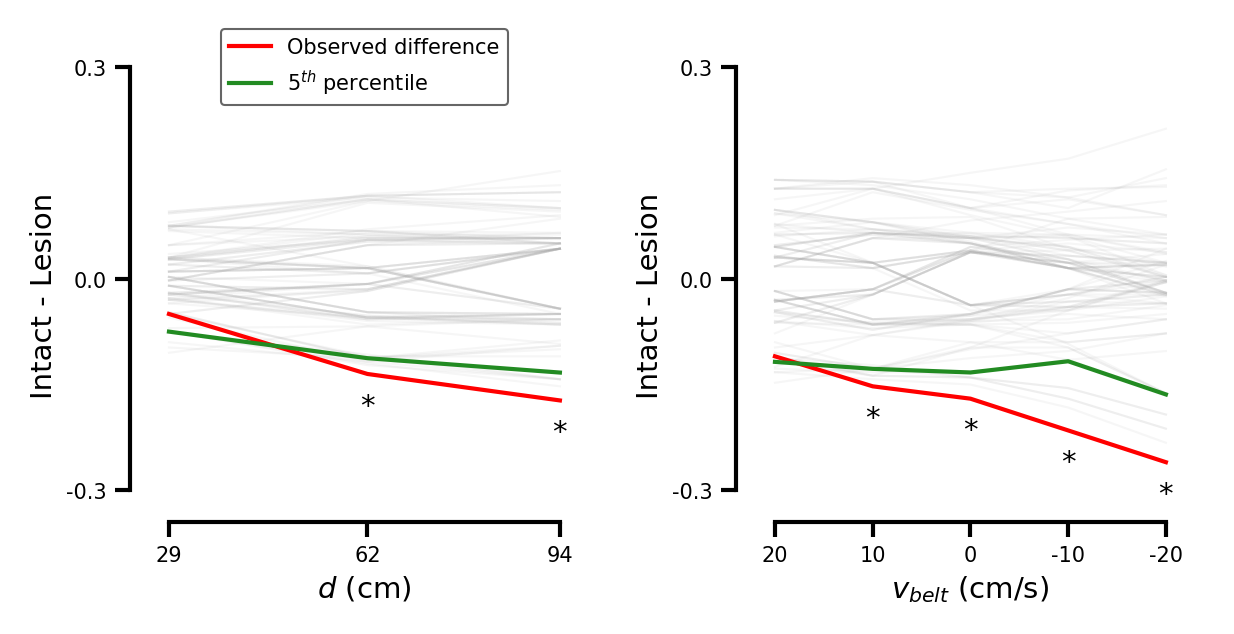

In [ ]:
def plot_permutationDist(permuted_diffs, observed_diff, p_values, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    for i in range(len(permuted_diffs)):
        ax.plot([.29, .62, .94], permuted_diffs[i][0:3], alpha=0.1, color='darkgray', lw=0.5, 
                # label='Individual shuffled difference'
                )
    
    ax.plot([.29, .62, .94], observed_diff[0:3], color='red', label='Observed difference')
    ax.plot([.29, .62, .94], np.percentile(permuted_diffs, 5, axis=0)[0:3], color='forestgreen', label=r'$5^{th}$ percentile')

    for i, (pos, p) in enumerate(zip([.29, .62, .94], p_values[0:3])):
        ax.annotate('*' if p < 0.05 else '', xy=(pos, observed_diff[i]), xytext=(pos, observed_diff[i]-0.025), fontsize=7, ha='center', va='top')

    ax.set_ylim(-0.3, 0.3)
    _ = r'$d$'
    ax.set_xlabel(f'{_} (cm)')
    ax.set_ylabel('Intact - Lesion')
    ax.set_yticks([-.3, 0, .3])
    ax.set_xlim(.29, .94)
    ax.set_xticks([.29, .62, .94])
    ax.set_xticklabels([29, 62, 94])
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1, y_ratio=.075)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.5, 1), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)



def plot_permutationVbelt(permuted_diffs, observed_diff, p_values, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    for i in range(len(permuted_diffs)):
        ax.plot([.2, .1, 0, -.1, -.2], permuted_diffs[i][3:8], alpha=0.1, color='darkgray', lw=0.5)
    
    ax.plot([.2, .1, 0, -.1, -.2], observed_diff[3:8], color='red', label='Observed Difference')
    ax.plot([.2, .1, 0, -.1, -.2], np.percentile(permuted_diffs, 5, axis=0)[3:8], color='forestgreen', label='5e percentile')

    for i, (pos, p) in enumerate(zip([.2, .1, 0, -.1, -.2], p_values[3:8])):
        ax.annotate('*' if p < 0.05 else '', xy=(pos, observed_diff[i+3]), xytext=(pos, observed_diff[i+3]-0.025), fontsize=7, ha='center', va='top')
    ax.set_ylim(-0.3, 0.3)
    _ = r'$d$'
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel('Intact - Lesion')
    ax.set_yticks([-.3, 0, .3])
    ax.set_xlim(.2, -.2)
    ax.set_xticks([.2, .1, 0, -.1, -.2])
    ax.set_xticklabels([20, 10, 0, -10, -20])
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1, y_ratio=.075)

    
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
plot_permutationDist(permuted_diffs, observed_diff, p_values, ax=axs[0])
plot_permutationVbelt(permuted_diffs, observed_diff, p_values, ax=axs[1])

mu_0 0.2204
mu_0 0.0009


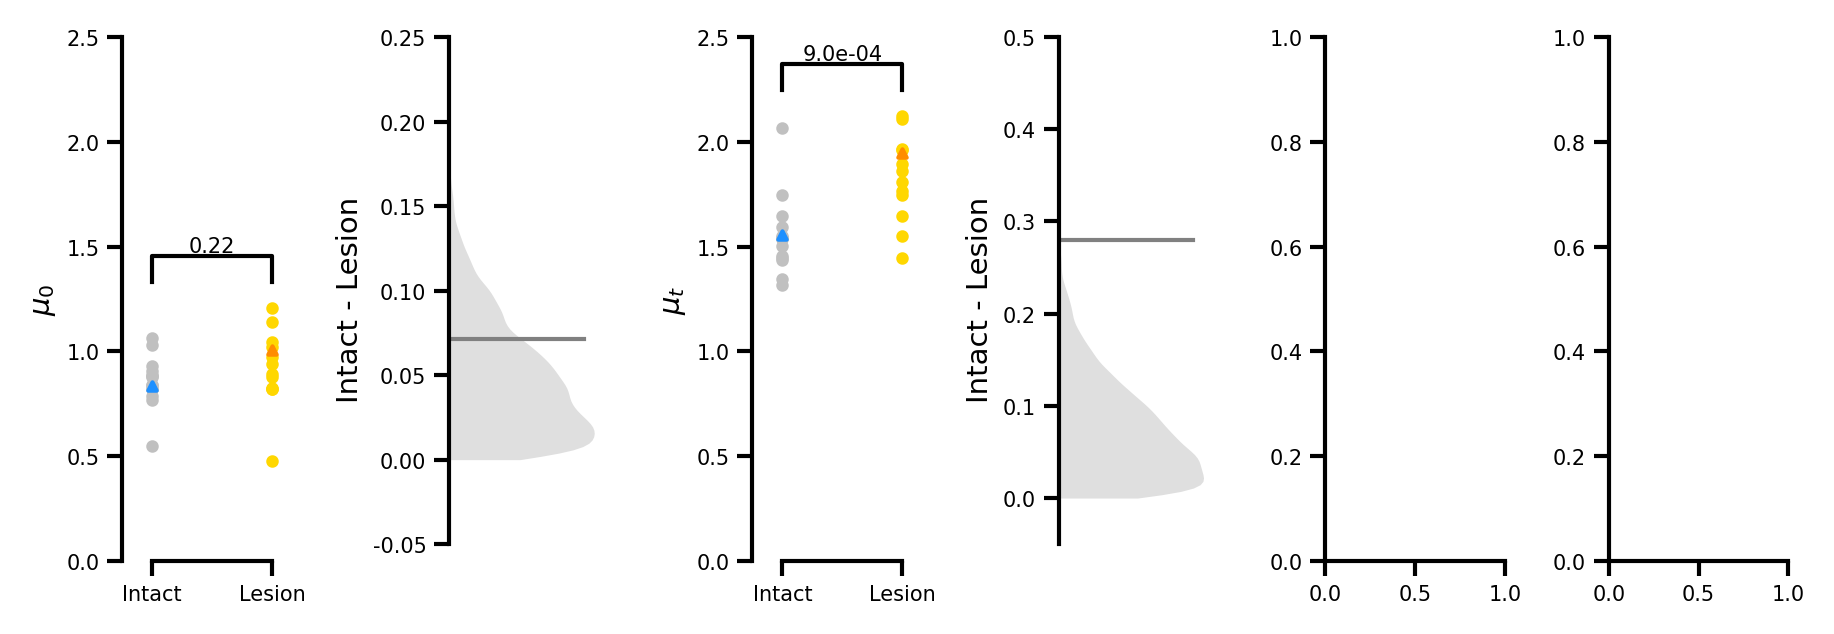

# test speed profile

In [ ]:

params = {}
sequence = {}
XtrackRunToLeftBin = {}
XtrackRunToRightBin = {}
trackTimeToLeftBin = {}
trackTimeToRightBin = {}
instantSpeedLeftBin = {}
instantSpeedRightBin = {}


TM1_pfPOS = [16.1, 97.3]
TM2_pfPOS = [17.2, 98.1]
TM1_virtualBoundary = [34.55, 80]  # in behav_params, should read_params(root, animal, session, "boundaryLeft")/11 ; read_params(root, animal, session, "boundaryRight")/11, but no change across sessions
TM2_virtualBoundary = [34.55, 80]


pfPOS = {'RatM00':TM2_pfPOS, 'RatF52':TM2_pfPOS}
virtualBoundary = {'RatM00':TM2_virtualBoundary, 'RatF52':TM2_virtualBoundary}



for index, animal in enumerate(animalList):

    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

        # get the preprocessed data from the pickle file
        biglesion = True if 'L' in session else False
        
        params[animal, session]     = get_from_pickle(root, animal, session, name="params.p")
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p")
        XtrackRunToLeftBin[animal, session], XtrackRunToRightBin[animal, session] = get_from_pickle(root, animal, session, name="trackPos.p")
        trackTimeToLeftBin[animal, session], trackTimeToRightBin[animal, session] = get_from_pickle(root, animal, session, name="trackTime.p")
        instantSpeedLeftBin[animal, session],instantSpeedRightBin[animal, session]= get_from_pickle(root, animal, session, name="trackSpeed.p")      

In [ ]:
for animal in animalList:
    print(animal, effort_sensitivity_0[animal])

RatF00 8.750695934751331
RatF01 10.420143656811938
RatF02 13.512953315250323
RatM00 11.90239776690201
RatM01 9.551820812874873
RatM02 9.40261754548387
RatF30 15.453225062662277
RatF31 6.5721302484179445
RatF32 5.487428677823306
RatF33 6.410641442586926
RatM30 17.512289649924448
RatM31 15.74859297950476
RatM32 16.008467052246036
RatF40 22.11287370805851
RatF41 54.01500785620064
RatF42 5.5962190707351755
RatM40 9.323232052588871
RatM41 8.605001993981384
RatM42 15.443805453476834
RatM43 12.279061707076924
RatF50 21.790595601760828
RatF51 17.097240149020212
RatF52 24.919052135086705
RatM50 9.310575750655993
RatM51 27.06016271717598
RatM52 12.491748755035129
RatM53 28.336664802156065
RatM54 15.053000400146338


In [ ]:
rat_example_intact, rat_example_lesion

('RatM00', 'RatF52')

In [ ]:
from VIGOR_Functions import compute_median_trajectory

# utility plot functions
def plot_speed_profile(posdataRight, timedataRight, xylim,
                color, xyLabels=["", ""], ax=None):
    '''Plot speed profile for each run
    Args:
        posdataRight: list of lists, position data for each run
        timedataRight: list of lists, time data for each run
        xylim: list of 4 scalars, x and y limits for the plot
        color: list of 2 colors, color of the plot
        xyLabels: list of 2 strings, x and y labels for the plot
        ax: matplotlib axis object, if None, create a new figure and axis
    Returns:
        ax: matplotlib axis object
    '''
    if ax is None:
        ax = plt.gca()

    for pos, time in zip(posdataRight, timedataRight):
        t = np.subtract(time, time[0])
        abs_speed = [abs(_) for _ in pos]
        ax.plot(t, abs_speed, color=color, linewidth=0.1, alpha=0.5)

    ax.set_xlabel(xyLabels[0])
    ax.set_ylabel(xyLabels[1])
    ax.set_xlim([xylim[0], xylim[1]])
    ax.set_ylim([xylim[2], xylim[3]])
    return ax

# remove treadmill speed from speed profile
def removeTMspeed(datap, datas, TMspeed, 
                    pfPOS, virtualBoundary, k=.5):
    """remove treadmill speed between platform and virtual boundary
        for speed profiles in which the treadmill is on
    Args:
        datap: list of lists, position data for each run
        datas: list of lists, speed data for each run
        TMspeed: scalar, treadmill speed
        pfPOS: list of 2 scalars, platform position
        virtualBoundary: list of 2 scalars, virtual boundary position
        k: scalar, steepness of the function
    Returns:
        output: list of lists, corrected speed data for each run
    """
    def _correctTM(x, k=k, mu1=20, mu2=85, amp=20):
        """
        (approximation of the Heaviside function)
        Args:
            x: scalar, position 
            k: scalar, steepness of the function 
            mu1: scalar, start location, end of platform
            mu2: scalar, end location, virutal boundary location
            amp: scalar, height of the  function, treadmill speed
        Returns:
            p: scalar, f(x)
        """  
        LEFT = 1/(1+np.exp(-k*(x-mu1)))
        RIGHT = 1/(1+np.exp(k*(x-mu2)))
        return LEFT * RIGHT * amp

    output = copy.deepcopy(datas)

    if np.all([isinstance(dat, float) for dat in datap]):  # if only one run is available
        for j, (pos, speed) in enumerate(zip(datap, datas)):  # loop through time points in a run
            if datap[0] < datap[-1]:  # going to right, treadmill effect when not on left platform until right virtual boundary
                output[j] -= _correctTM(pos, k=k, mu1=pfPOS[0], mu2=virtualBoundary[1], amp=TMspeed)
            elif datap[0] > datap[-1]:  # going to left, treadmill effect when not on right platform until left virtual boundary
                output[j] -= _correctTM(pos, k=k, mu1=virtualBoundary[0], mu2=pfPOS[1], amp=TMspeed)
    else:
        for i, (positionarray, speedarray) in enumerate(zip(datap, datas)):  # loop through individual runs
            for j, (pos, speed) in enumerate(zip(positionarray, speedarray)):  # loop through time points in a run
                if positionarray[0] < positionarray[-1]:  # going to right, treadmill effect when not on left platform until right virtual boundary
                    output[i][j] -= _correctTM(pos, k=k, mu1=pfPOS[0], mu2=virtualBoundary[1], amp=TMspeed)
                elif positionarray[0] > positionarray[-1]:  # going to left, treadmill effect when not on right platform until left virtual boundary
                    output[i][j] -= _correctTM(pos, k=k, mu1=virtualBoundary[0], mu2=pfPOS[1], amp=TMspeed)
    return output


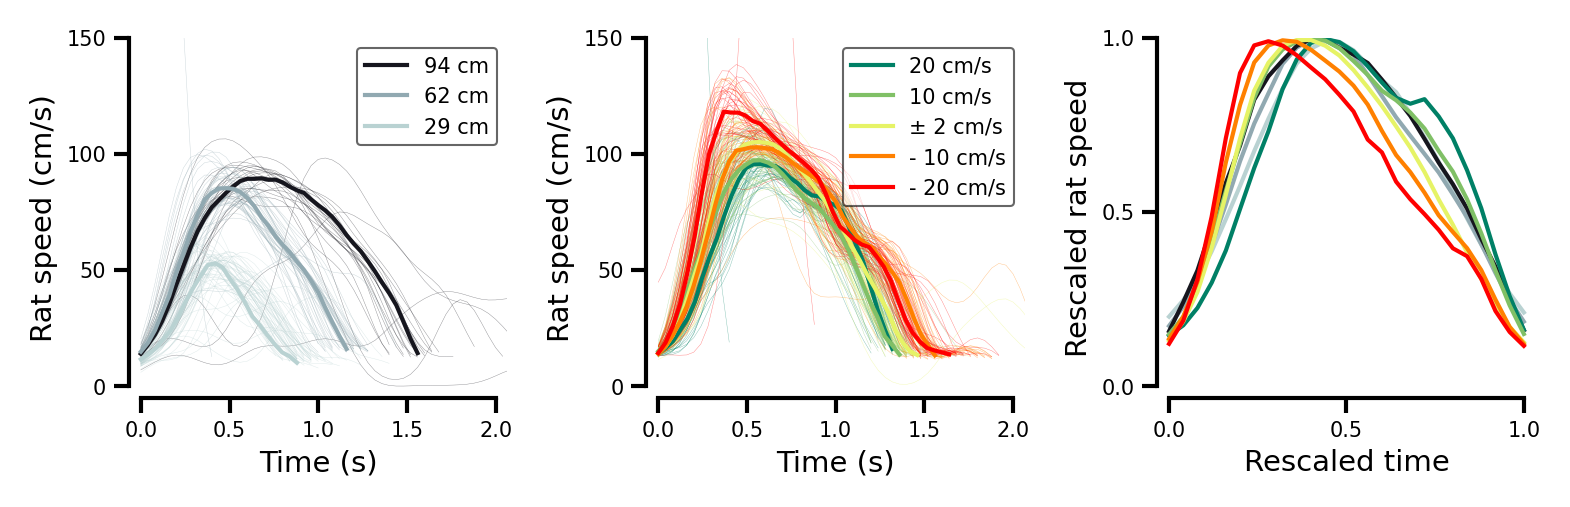

In [ ]:
# A, plot speed profiles for each experimental condition
# B, same but rescaled by average speed and movement time
condition_color_code = {'29 cm': plt.cm.get_cmap('bone')(0.8), '62 cm': plt.cm.get_cmap('bone')(0.65), '94 cm': plt.cm.get_cmap('bone')(.1),
                        '20 cm/s': plt.cm.get_cmap('summer')(0), '10 cm/s': plt.cm.get_cmap('summer')(.5), '± 2 cm/s': plt.cm.get_cmap('summer')(.9),
                        '- 10 cm/s': plt.cm.get_cmap('autumn')(.5), '- 20 cm/s': plt.cm.get_cmap('autumn')(0)}


def Figure3A(animal, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # example session
    index_session_example = -2  #last AM session
    index_block_example = 0 # first block

    for condition, conditionname in zip([dist120, dist90, dist60], ['94 cm', '62 cm', '29 cm']):
        session = matchsession(animal, condition)[index_session_example]
        example_time = trackTimeToRightBin[animal, session][index_block_example]

        # keep treadmill speed for dist sessions
        if session in dist60+dist90+dist120:
            example_speed = instantSpeedRightBin[animal, session][index_block_example]
        
        # remove treadmill speed for TM sessions
        elif session in TM20+TM10+TM2+TMrev10+TMrev20:
            p = XtrackRunToRightBin[animal, session][index_block_example]
            s = instantSpeedRightBin[animal, session][index_block_example]
            t = trackTimeToRightBin[animal, session][index_block_example]
            tm_speed = params[animal, session]['treadmillSpeed'][index_block_example]
            example_speed = removeTMspeed(p, s, tm_speed, pfPOS[animal], virtualBoundary[animal])

        # plot individual speed profiles
        plot_speed_profile(example_speed, example_time, 
                    xylim = [0, 2, 0, 150], color=condition_color_code[conditionname], 
                    xyLabels=["Time (s)", "Rat speed (cm/s)"], ax=ax) 

        # plot median trajectory
        ax.plot(*compute_median_trajectory(example_speed, example_time), 
                    color=condition_color_code[conditionname], lw=1, alpha=1, zorder = 3, label=conditionname)

        ax.set_yticks([0, 50, 100, 150])
        space_axes(ax)

        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(*zip(*unique), loc='best',
                                frameon=True, fontsize=5,
                                edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

def Figure3Abis(animal, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    index_session_example = -2  #last AM session
    index_block_example = 0 # first block

    for condition, conditionname in zip([TM20, TM10, TM2, TMrev10, TMrev20], ['20 cm/s', '10 cm/s', '± 2 cm/s', '- 10 cm/s', '- 20 cm/s']):
        session = matchsession(animal, condition)[index_session_example]
        example_time = trackTimeToRightBin[animal, session][index_block_example]

        # keep treadmill speed for dist sessions
        if session in dist60+dist90+dist120:
            example_speed = instantSpeedRightBin[animal, session][index_block_example]
        
        # remove treadmill speed for TM sessions
        elif session in TM20+TM10+TM2+TMrev10+TMrev20:
            p = XtrackRunToRightBin[animal, session][index_block_example]
            s = instantSpeedRightBin[animal, session][index_block_example]
            t = trackTimeToRightBin[animal, session][index_block_example]
            tm_speed = params[animal, session]['treadmillSpeed'][index_block_example]
            example_speed = removeTMspeed(p, s, tm_speed, pfPOS[animal], virtualBoundary[animal])   

        # plot individual speed profiles
        plot_speed_profile(example_speed, example_time, 
                    xylim = [0, 2, 0, 150], color=condition_color_code[conditionname],
                    xyLabels=["Time (s)", "Rat speed (cm/s)"], ax=ax) 

        # plot median trajectory
        ax.plot(*compute_median_trajectory(example_speed, example_time), 
                    color=condition_color_code[conditionname], lw=1, alpha=1, zorder = 3, label=conditionname)

        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(*zip(*unique), loc='best',
                                frameon=True, fontsize=5,
                                edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
        ax.set_yticks([0, 50, 100, 150])
        space_axes(ax)
        # ax.set_yticks([])
        # ax.spines['left'].set_visible(False)

def Figure3B(animal, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))


    index_session_example = -2  #last AM session
    index_block_example = 0 # first block

    for condition, conditionname in zip([dist60, dist90, dist120, TM20, TM10, TM2, TMrev10, TMrev20], 
    ['29 cm', '62 cm', '94 cm', '20 cm/s', '10 cm/s', '± 2 cm/s', '- 10 cm/s', '- 20 cm/s']):
        session = matchsession(animal, condition)[index_session_example]
        example_time = trackTimeToRightBin[animal, session][index_block_example]

        # keep treadmill speed for dist sessions
        if session in dist60+dist90+dist120:
            example_speed = instantSpeedRightBin[animal, session][index_block_example]
        
        # remove treadmill speed for TM sessions
        elif session in TM20+TM10+TM2+TMrev10+TMrev20:
            p = XtrackRunToRightBin[animal, session][index_block_example]
            s = instantSpeedRightBin[animal, session][index_block_example]
            t = trackTimeToRightBin[animal, session][index_block_example]
            tm_speed = params[animal, session]['treadmillSpeed'][index_block_example]
            example_speed = removeTMspeed(p, s, tm_speed, pfPOS[animal], virtualBoundary[animal])

        #rescale by average speed and movement time
        rescaled_time = copy.deepcopy(example_time)
        for i in range(len(example_time)):
            rescaled_time[i] = np.array(example_time[i])/(example_time[i][-1]-example_time[i][0])

        rescaled_speed = copy.deepcopy(example_speed)
        for i in range(len(example_speed)):
            # rescaled_speed[i] = np.array(example_speed[i])/np.nanmean(example_speed[i])
            rescaled_speed[i] = np.array(example_speed[i])/np.nanmax(example_speed[i])

        # plot median trajectory
        ax.plot(*compute_median_trajectory(rescaled_speed, rescaled_time), 
                    color=condition_color_code[conditionname], lw=1, alpha=1, zorder = 3, label=conditionname)

    ax.set_xlabel("Rescaled time")
    ax.set_ylabel("Rescaled rat speed")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([0.0, 0.5, 1.0])
    ax.set_yticklabels([0.0, 0.5, 1.0])
    space_axes(ax)
    
fig, axs = plt.subplots(1, 3, figsize=(cm2inch(13), cm2inch(4)), dpi=300)
Figure3A(rat_example_intact, axs[0])
Figure3Abis(rat_example_intact, axs[1])
Figure3B(rat_example_intact, axs[2])

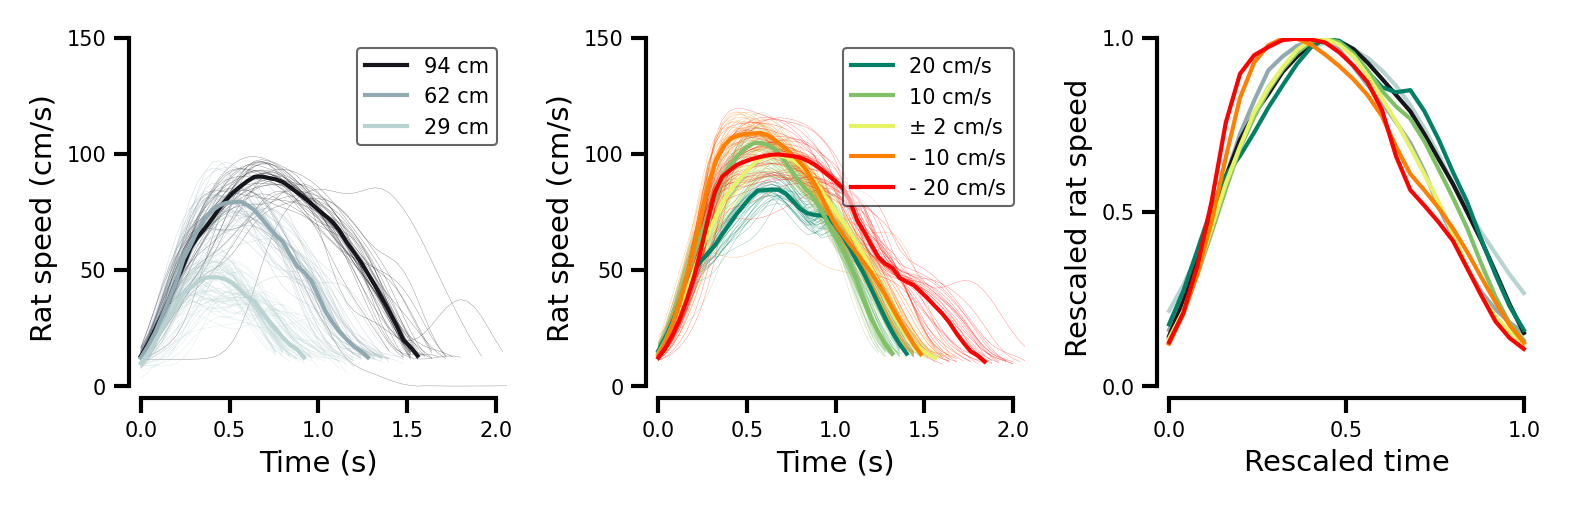

In [ ]:
a='RatF50'
fig, axs = plt.subplots(1, 3, figsize=(cm2inch(13), cm2inch(4)), dpi=300)
Figure3A(a, axs[0])
Figure3Abis(a, axs[1])
Figure3B(a, axs[2])

In [ ]:
pfPOS = {animal:TM1_pfPOS for animal in animalList}
virtualBoundary = {animal:TM1_virtualBoundary for animal in animalList}

# beta?

Observed Slope: 121.9824
P-value: 0.0128
Observed Slope: 0.0560
P-value: 0.9620
Observed Slope: -0.0073
P-value: 0.5663
Observed Slope: 0.0000
P-value: 0.9037


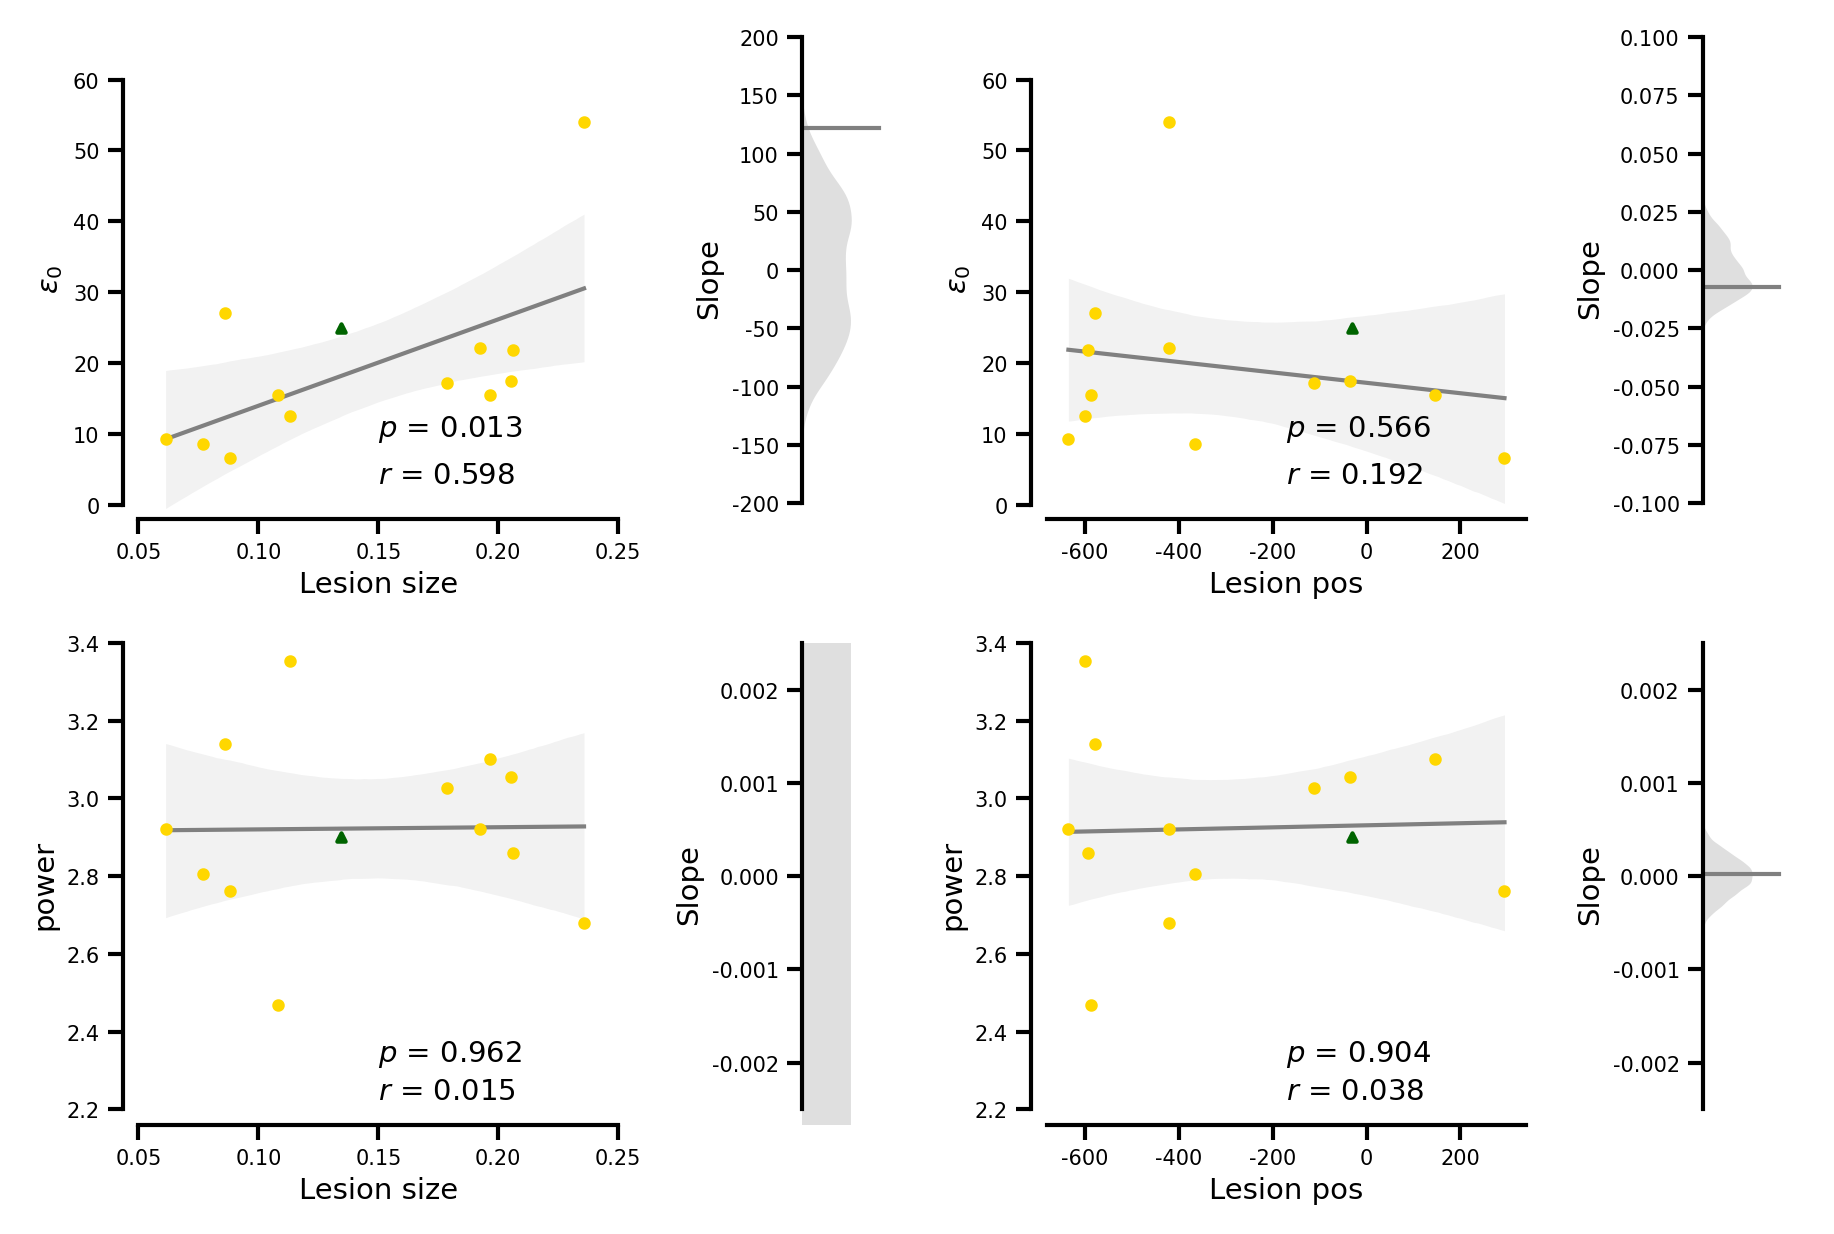

In [ ]:
from scipy.optimize import curve_fit

def Figure6_I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_area[animal], effort_sensitivity_0[animal], color=rat_markers[animal][0], zorder=10, s=4, marker=rat_markers[animal][1])
        x.append(lesion_area[animal])
        y.append(effort_sensitivity_0[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # calculate confidence intervals for fitted line
    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000)
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0)
    upper = np.percentile(ysample, 97.5, axis=0)

    # plot the regression and confidence intervals
    y_fit = np.poly1d(p)(xi)
    ax.plot(xi, y_fit, color='gray', zorder=1)
    ax.fill_between(xi, lower, upper, color='gray', alpha=.1, zorder=0, lw=0)


    # shuffle to get p-value
    observed_slope = p[0]
    num_iterations = 10000
    shuffled_slopes = []

    np.random.seed(0)
    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        p_shuffled, _ = curve_fit(f, x, shuffled_y, [1, 1])
        shuffled_slope = p_shuffled[0]
        shuffled_slopes.append(shuffled_slope)

    # Calculate the p-value
    p_value = (np.abs(shuffled_slopes) >= np.abs(observed_slope)).mean()

    # compute r
    y_mean = np.mean(y)
    y_pred = f(x, *p)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_total)
    r = np.sqrt(r_squared)

    # pvalue annotation
    ax.annotate(f"$p$ = {p_value:.3f}", xy=(.50, .22), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.3f}", xy=(.50, .12), xycoords='axes fraction', fontsize=7, ha='left', va='top')

    ax.set_xlabel('Lesion size')
    ax.set_xlim(0.05, .25)
    ax.set_ylabel(r'$\varsigma_0$')
    ax.set_ylim(0, 60)
    ax.set_yticks([0, 10, 20, 30, 40, 50, 60])
    space_axes(ax, top_y=.1)
    
    print(f"Observed Slope: {observed_slope:.4f}")
    print(f"P-value: {p_value:.4f}")

    return shuffled_slopes, observed_slope

def Figure6_Ipower(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_area[animal], power[animal], color=rat_markers[animal][0], zorder=10, s=4, marker=rat_markers[animal][1])
        x.append(lesion_area[animal])
        y.append(power[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # calculate confidence intervals for fitted line
    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000)
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0)
    upper = np.percentile(ysample, 97.5, axis=0)

    # plot the regression and confidence intervals
    y_fit = np.poly1d(p)(xi)
    ax.plot(xi, y_fit, color='gray', zorder=1)
    ax.fill_between(xi, lower, upper, color='gray', alpha=.1, zorder=0, lw=0)


    # shuffle to get p-value
    observed_slope = p[0]
    num_iterations = 10000
    shuffled_slopes = []

    np.random.seed(0)
    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        p_shuffled, _ = curve_fit(f, x, shuffled_y, [1, 1])
        shuffled_slope = p_shuffled[0]
        shuffled_slopes.append(shuffled_slope)

    # Calculate the p-value
    p_value = (np.abs(shuffled_slopes) >= np.abs(observed_slope)).mean()

    # compute r
    y_mean = np.mean(y)
    y_pred = f(x, *p)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_total)
    r = np.sqrt(r_squared)

    # pvalue annotation
    ax.annotate(f"$p$ = {p_value:.3f}", xy=(.50, .18), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.3f}", xy=(.50, .1), xycoords='axes fraction', fontsize=7, ha='left', va='top')

    ax.set_xlabel('Lesion size')
    ax.set_xlim(0.05, .25)
    ax.set_ylabel(r'power')
    ax.set_ylim(2.2, 3.4)
    space_axes(ax)
    
    print(f"Observed Slope: {observed_slope:.4f}")
    print(f"P-value: {p_value:.4f}")

    return shuffled_slopes, observed_slope

def Figure6_Iloc(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_pos[animal], effort_sensitivity_0[animal], color=rat_markers[animal][0], zorder=10, s=4, marker=rat_markers[animal][1])
        x.append(lesion_pos[animal])
        y.append(effort_sensitivity_0[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # calculate confidence intervals for fitted line
    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000)
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0)
    upper = np.percentile(ysample, 97.5, axis=0)

    # plot the regression and confidence intervals
    y_fit = np.poly1d(p)(xi)
    ax.plot(xi, y_fit, color='gray', zorder=1)
    ax.fill_between(xi, lower, upper, color='gray', alpha=.1, zorder=0, lw=0)


    # shuffle to get p-value
    observed_slope = p[0]
    num_iterations = 10000
    shuffled_slopes = []

    np.random.seed(0)
    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        p_shuffled, _ = curve_fit(f, x, shuffled_y, [1, 1])
        shuffled_slope = p_shuffled[0]
        shuffled_slopes.append(shuffled_slope)

    # Calculate the p-value
    p_value = (np.abs(shuffled_slopes) >= np.abs(observed_slope)).mean()

    # compute r
    y_mean = np.mean(y)
    y_pred = f(x, *p)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_total)
    r = np.sqrt(r_squared)

    # pvalue annotation
    ax.annotate(f"$p$ = {p_value:.3f}", xy=(.50, .22), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.3f}", xy=(.50, .12), xycoords='axes fraction', fontsize=7, ha='left', va='top')

    ax.set_xlabel('Lesion pos')
    # ax.set_xlim(0.05, .25)
    ax.set_ylabel(r'$\varsigma_0$')
    ax.set_ylim(0, 60)
    ax.set_yticks([0, 10, 20, 30, 40, 50, 60])
    space_axes(ax, top_y=.1)
    
    print(f"Observed Slope: {observed_slope:.4f}")
    print(f"P-value: {p_value:.4f}")

    return shuffled_slopes, observed_slope

def Figure6_Ipowerloc(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_pos[animal], power[animal], color=rat_markers[animal][0], zorder=10, s=4, marker=rat_markers[animal][1])
        x.append(lesion_pos[animal])
        y.append(power[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # calculate confidence intervals for fitted line
    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000)
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0)
    upper = np.percentile(ysample, 97.5, axis=0)

    # plot the regression and confidence intervals
    y_fit = np.poly1d(p)(xi)
    ax.plot(xi, y_fit, color='gray', zorder=1)
    ax.fill_between(xi, lower, upper, color='gray', alpha=.1, zorder=0, lw=0)


    # shuffle to get p-value
    observed_slope = p[0]
    num_iterations = 10000
    shuffled_slopes = []

    np.random.seed(0)
    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        p_shuffled, _ = curve_fit(f, x, shuffled_y, [1, 1])
        shuffled_slope = p_shuffled[0]
        shuffled_slopes.append(shuffled_slope)

    # Calculate the p-value
    p_value = (np.abs(shuffled_slopes) >= np.abs(observed_slope)).mean()

    # compute r
    y_mean = np.mean(y)
    y_pred = f(x, *p)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_total)
    r = np.sqrt(r_squared)

    # pvalue annotation
    ax.annotate(f"$p$ = {p_value:.3f}", xy=(.50, .18), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.3f}", xy=(.50, .1), xycoords='axes fraction', fontsize=7, ha='left', va='top')

    ax.set_xlabel('Lesion pos')
    # ax.set_xlim(0.05, .25)
    ax.set_ylabel(r'power')
    ax.set_ylim(2.2, 3.4)
    space_axes(ax)
    
    print(f"Observed Slope: {observed_slope:.4f}")
    print(f"P-value: {p_value:.4f}")

    return shuffled_slopes, observed_slope


fig, axs = plt.subplots(2, 4, figsize=(6, 4), gridspec_kw={'width_ratios': [5, 1, 5, 1]})
shuffled_slopes, observed_slope = Figure6_I(ax=axs[0, 0])
plot_shuffling(shuffles=shuffled_slopes, observed=observed_slope, ylim=[-200, 200], ax=axs[0, 1], ylabel='Slope')

shuffled_slopes, observed_slope = Figure6_Ipower(ax=axs[1, 0])
plot_shuffling(shuffles=shuffled_slopes, observed=observed_slope, ylim=[-.0025, .0025], ax=axs[1, 1], ylabel='Slope')

shuffled_slopes, observed_slope = Figure6_Iloc(ax=axs[0, 2])
plot_shuffling(shuffles=shuffled_slopes, observed=observed_slope, ylim=[-.1, .1], ax=axs[0, 3], ylabel='Slope')

shuffled_slopes, observed_slope = Figure6_Ipowerloc(ax=axs[1, 2])
plot_shuffling(shuffles=shuffled_slopes, observed=observed_slope, ylim=[-.0025, .0025], ax=axs[1, 3], ylabel='Slope')

Observed Slope: -10.0688
P-value: 0.5132


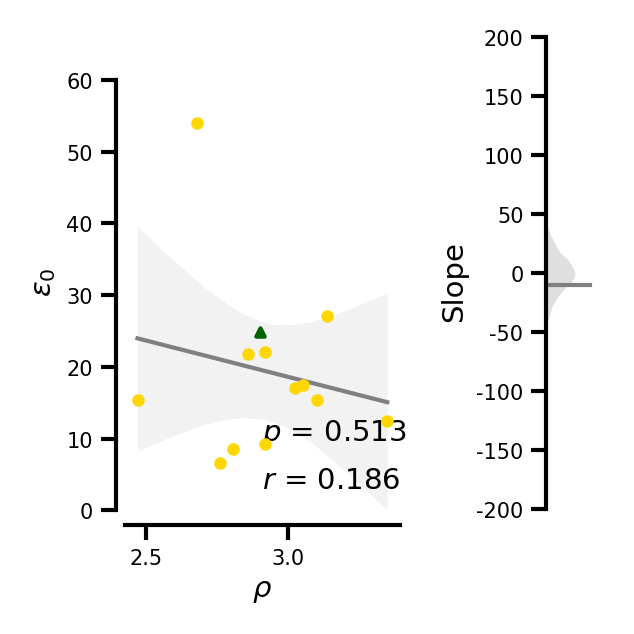

In [ ]:
def Figure6_Itest(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in lesioned:
        ax.scatter(power[animal], effort_sensitivity_0[animal], color=rat_markers[animal][0], zorder=10, s=4, marker=rat_markers[animal][1])
        x.append(power[animal])
        y.append(effort_sensitivity_0[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # calculate confidence intervals for fitted line
    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000)
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0)
    upper = np.percentile(ysample, 97.5, axis=0)

    # plot the regression and confidence intervals
    y_fit = np.poly1d(p)(xi)
    ax.plot(xi, y_fit, color='gray', zorder=1)
    ax.fill_between(xi, lower, upper, color='gray', alpha=.1, zorder=0, lw=0)


    # shuffle to get p-value
    observed_slope = p[0]
    num_iterations = 10000
    shuffled_slopes = []

    np.random.seed(0)
    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        p_shuffled, _ = curve_fit(f, x, shuffled_y, [1, 1])
        shuffled_slope = p_shuffled[0]
        shuffled_slopes.append(shuffled_slope)

    # Calculate the p-value
    p_value = (np.abs(shuffled_slopes) >= np.abs(observed_slope)).mean()

    # compute r
    y_mean = np.mean(y)
    y_pred = f(x, *p)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_total)
    r = np.sqrt(r_squared)

    # pvalue annotation
    ax.annotate(f"$p$ = {p_value:.3f}", xy=(.50, .22), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.3f}", xy=(.50, .12), xycoords='axes fraction', fontsize=7, ha='left', va='top')

    ax.set_xlabel(r'$\beta$')
    # ax.set_xlim(0.05, .25)
    ax.set_ylabel(r'$\varsigma_0$')
    ax.set_ylim(0, 60)
    ax.set_yticks([0, 10, 20, 30, 40, 50, 60])
    space_axes(ax, top_y=.1)
    
    print(f"Observed Slope: {observed_slope:.4f}")
    print(f"P-value: {p_value:.4f}")

    return shuffled_slopes, observed_slope

fig, axs = plt.subplots(1, 2, figsize=(2, 2), gridspec_kw={'width_ratios': [5, 1]})
shuffled_slopes, observed_slope = Figure6_Itest(ax=axs[0])
plot_shuffling(shuffles=shuffled_slopes, observed=observed_slope, ylim=[-200, 200], ax=axs[1], ylabel='Slope')
